In [1]:

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Graphing
# import importlib
import graph_config

import tqdm as tqdm

from pathlib import Path
import sys
from io import StringIO

# importlib.reload(graph_config)  # This reloads the updated graph_config.py

# from graph_config import plt


NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


In [2]:
# Color and Style
plt.style.use('ggplot')
custom_colors = ['#071d33', '#63adf2', '#a7cced', '#82a0bc', '#2f4b26']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
sns.set_palette(custom_colors)

# Figure & Font
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'font.family': ['Helvetica', 'Arial', 'sans-serif'],
    'font.size': 13,
    'text.antialiased': True,
})

# Axes & Grid
plt.rcParams.update({
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.labelpad': 10,
    'axes.titleweight': 'bold',
    'axes.titlesize': 14,
    'axes.titlepad': 15,
    'grid.color': '#E5E5E5',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'grid.alpha': 0.3,
})

# Ticks
plt.rcParams.update({
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
})

# Legends
plt.rcParams.update({
    'legend.frameon': True,
    'legend.facecolor': 'white',
    'legend.framealpha': 0.95,
    'legend.edgecolor': '#CCCCCC',
    'legend.loc': 'upper right',
    'legend.borderaxespad': 0.5,
    'legend.labelspacing': 0.4,
    'legend.handlelength': 2.0,
    'legend.handletextpad': 0.5,
})

# Lines
plt.rcParams['lines.linewidth'] = 2

# 2. Turbine Telemetry (Supply)

In [3]:
df_tt = pd.read_csv(RAW_DATASET_PATH / 'Turbine_telemetry.csv')

df_tt['Timestamp'] = pd.to_datetime(df_tt['Timestamp'], format='%Y-%m-%d %H:%M:%S') # convert to datetime

# rename columns for clarity
df_tt.rename(columns={
    'Power_kw': 'turbine_power_kw',
    'Setpoint_kw': 'turbine_setpoint_kw',
    'Wind_ms': 'wind_baseline_ms'
}, inplace=True)

ts_tt = df_tt.set_index('Timestamp') #as a time series

ts_tt_og = ts_tt.copy() # keep original for later
ts_tt.head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms
Timestamp                                                                   
2015-05-28 00:00:23              80.0                900.0               4.9
2015-05-28 00:01:23              78.0                900.0               5.4
2015-05-28 00:02:23              52.0                900.0               4.9
2015-05-28 00:03:23              57.0                900.0               4.6
2015-05-28 00:04:23              54.0                900.0               4.6

## 2.1 Explatory Data Analysis

### 2.1.1 Check Missing Data

In [4]:
print(f'Min Timestamp: {ts_tt.index.min()}')
print(f'Max Timestamp: {ts_tt.index.max()}')

Min Timestamp: 2015-05-28 00:00:23
Max Timestamp: 2018-01-11 06:14:32


In [5]:
print("Missing values in Turbine Data:")
pd.DataFrame(ts_tt.isna().sum()).rename(columns={0: 'Missing values'}).T


Missing values in Turbine Data:


turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms
Missing values              2702                 2715              2705

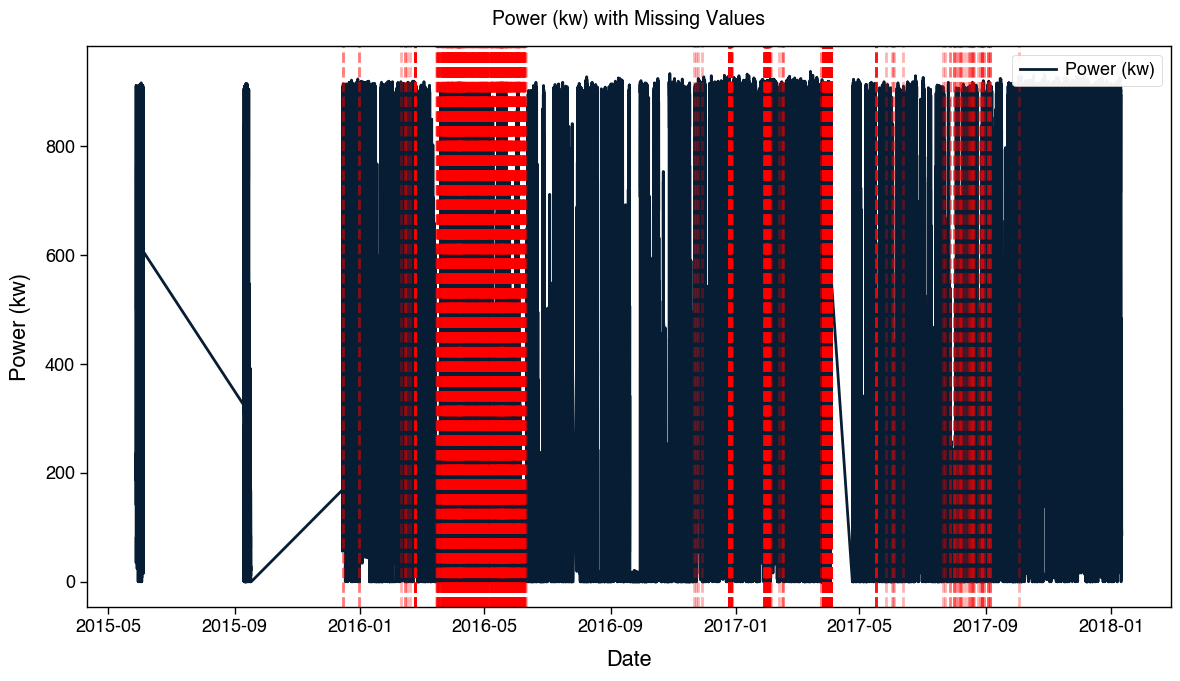

In [6]:
is_nan = ts_tt['turbine_power_kw'].isna()

plt.figure(figsize=(12,7))
plt.plot(ts_tt.index, ts_tt['turbine_power_kw'], label='Power (kw)')
for t in ts_tt.index[is_nan]:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.3)
plt.title('Power (kw) with Missing Values')
plt.xlabel('Date')
plt.ylabel('Power (kw)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
ts_tt['delta'] = ts_tt.index.diff()
ts_tt_diff = pd.DataFrame(ts_tt['delta'].value_counts()).reset_index().sort_values('count', ascending=False)

# What is the most common time difference?
most_common_diff = ts_tt_diff.head(1)
print(f'Most common time difference is {most_common_diff["delta"][0].seconds} seconds with {most_common_diff["count"][0]:,.1f} occurrences {round(most_common_diff["count"][0] / len(ts_tt) * 100, 2)}% of the data')
print(f'Unique time differences: {len(ts_tt_diff)}')


ts_tt_diff.head(5)

Most common time difference is 60 seconds with 1,051,543.0 occurrences 98.31% of the data
Unique time differences: 143


delta    count
0 0 days 00:01:00  1051543
1 0 days 00:00:59     6914
2 0 days 00:01:01     4305
3 0 days 00:00:01     2740
4 0 days 00:00:04     1124

In [8]:
ts_tt['prev_timestamp'] = ts_tt.index.to_series().shift(1)

ts_tt['delta'] = ts_tt.index.to_series().diff()
ts_tt['prev_delta'] = ts_tt['delta'].shift(1)

irregular_context = ts_tt[ts_tt['delta'] != pd.Timedelta(minutes=1)].copy()

irregular_context['Timestamp'] = irregular_context.index

irregular_context = irregular_context[['prev_timestamp', 'Timestamp', 'delta']]
irregular_context = irregular_context.sort_values(by='delta', ascending=False).reset_index(drop=True)

display(irregular_context.head(10))

prev_timestamp           Timestamp            delta
0 2015-06-03 23:59:23 2015-09-10 00:00:30 98 days 00:01:07
1 2015-09-16 23:59:30 2015-12-14 21:03:10 88 days 21:03:40
2 2017-04-03 15:08:44 2017-04-24 03:20:06 20 days 12:11:22
3 2016-07-26 08:30:36 2016-07-29 21:38:56  3 days 13:08:20
4 2015-12-15 20:15:47 2015-12-17 13:47:31  1 days 17:31:44
5 2016-01-13 09:37:34 2016-01-14 09:20:34  0 days 23:43:00
6 2016-09-20 19:03:37 2016-09-21 14:21:37  0 days 19:18:00
7 2017-12-13 22:25:32 2017-12-14 05:31:32  0 days 07:06:00
8 2017-05-17 02:01:07 2017-05-17 08:38:50  0 days 06:37:43
9 2016-09-20 05:13:37 2016-09-20 11:49:37  0 days 06:36:00

There are two types of missing data in our turbine telemetry dataset:

1. **Rows with NaN values in one or more columns**, and
2. **Missing timestamps** — periods where data was not recorded or is entirely absent.

Upon inspection, we found that the data for **2015 is incomplete**, with approximately six months missing. Notably, the available data only begins in **May 2015**, meaning the year is not fully represented.
To ensure the integrity and consistency of our analysis, we have decided to **exclude 2015 from the dataset**, as it does not provide a complete annual record.

In [9]:
# remove data from 2015
ts_tt = ts_tt[ts_tt.index.year != 2015].copy()

ts_tt.head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-01-01 00:00:34             904.0                900.0              17.0   
2016-01-01 00:01:34             899.0                900.0              15.1   
2016-01-01 00:02:34             911.0                900.0              18.1   
2016-01-01 00:03:34             900.0                900.0              23.1   
2016-01-01 00:04:34             903.0                900.0              19.4   

                              delta      prev_timestamp      prev_delta  
Timestamp                                                                
2016-01-01 00:00:34 0 days 00:01:00 2015-12-31 23:59:34 0 days 00:01:00  
2016-01-01 00:01:34 0 days 00:01:00 2016-01-01 00:00:34 0 days 00:01:00  
2016-01-01 00:02:34 0 days 00:01:00 2016-01-01 00:01:34 0 days 00:01:00  
2016-01-01 00:03:34 0 days 00:01:00 2016-01-01 00:02:34 0 days 00:01:00  
2016-01-01 00:04:34 0 days 00:01:00 2016-01-01 00:03:34 0 days 00:01:00

In [10]:
# Check when delta and prev delta are less than 1 minute
ts_tt[(ts_tt['delta'] < pd.Timedelta(minutes=1)) & (ts_tt['prev_delta'] < pd.Timedelta(minutes=1))].head(5)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-02-08 20:18:34             895.0                900.0              12.1   
2016-02-08 20:19:16               0.0                900.0              13.3   
2016-02-08 20:19:34             722.0                900.0              11.4   
2016-02-08 20:20:16               0.0                900.0              12.4   
2016-02-08 20:20:34             793.0                900.0              11.9   

                              delta      prev_timestamp      prev_delta  
Timestamp                                                                
2016-02-08 20:18:34 0 days 00:00:18 2016-02-08 20:18:16 0 days 00:00:42  
2016-02-08 20:19:16 0 days 00:00:42 2016-02-08 20:18:34 0 days 00:00:18  
2016-02-08 20:19:34 0 days 00:00:18 2016-02-08 20:19:16 0 days 00:00:42  
2016-02-08 20:20:16 0 days 00:00:42 2016-02-08 20:19:34 0 days 00:00:18  
2016-02-08 20:20:34 0 days 00:00:18 2016-02-08 20:20:16 0 days 00:00:42

Moreover, since 98% of our dataset have a 1 minute sampling interval and we find that sampling rate under 1 minute shows a delay in data ingestion where turbine power is set to 0 where a couple of second later it reveals the actual power. If we resample it rightaway it will skew our turbine power result when we take an average of it.
\
\
So, we need to find the cut-in speed that can reveal where there should have been a power but our dataset do not capture it

In [11]:
cut_in_speed = ts_tt[(ts_tt.loc[:, 'turbine_power_kw'] >= 10.)].loc[:, 'wind_baseline_ms'].quantile(0.1)

print(f'Cut-in speed: {cut_in_speed:.2f} m/s')

Cut-in speed: 4.90 m/s


In [12]:
# Define a threshold for what counts as "real" turbine activity
ts_tt_ingestion_delay = ts_tt.copy()
real_power_threshold = 5

# Shift to get the next 2 data points
ts_tt_ingestion_delay['next_power'] = ts_tt_ingestion_delay['turbine_power_kw'].shift(-1)
ts_tt_ingestion_delay['next2_power'] = ts_tt_ingestion_delay['turbine_power_kw'].shift(-2)

# Likely ingestion delay if:
# - Current power is zero
# - Wind speed is above cut-in (e.g., 3 m/s)
# - A significant (> threshold) power reading occurs within next 2 steps
ts_tt_ingestion_delay['likely_delay'] = (
    (ts_tt_ingestion_delay['turbine_power_kw'] == 0) &
    (ts_tt_ingestion_delay['wind_baseline_ms'] >= 3) &
    (ts_tt_ingestion_delay['delta'] != pd.Timedelta(minutes=1)) &
    (
        (ts_tt_ingestion_delay['next_power'] >= real_power_threshold) |
        (ts_tt_ingestion_delay['next2_power'] >= real_power_threshold)
    )
)

print(f"Total likely ingestion delay: {ts_tt_ingestion_delay['likely_delay'].sum()}")

display(ts_tt_ingestion_delay[ts_tt_ingestion_delay.likely_delay == True].head())


Total likely ingestion delay: 269


turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-02-08 20:18:16               0.0                900.0               6.3   
2016-02-08 20:19:16               0.0                900.0              13.3   
2016-02-08 20:20:16               0.0                900.0              12.4   
2016-03-15 00:18:54               0.0                900.0               7.6   
2016-03-15 00:19:54               0.0                900.0               7.2   

                              delta      prev_timestamp      prev_delta  \
Timestamp                                                                 
2016-02-08 20:18:16 0 days 00:00:42 2016-02-08 20:17:34 0 days 00:01:00   
2016-02-08 20:19:16 0 days 00:00:42 2016-02-08 20:18:34 0 days 00:00:18   
2016-02-08 20:20:16 0 days 00:00:42 2016-02-08 20:19:34 0 days 00:00:18   
2016-03-15 00:18:54 0 days 00:00:17 2016-03-15 00:18:37 0 days 00:01:00   
2016-03-15 00:19:54 0 days 00:00:17 2016-03-15 00:19:37 0 days 00:00:43   

                     next_power  next2_power  likely_delay  
Timestamp                                                   
2016-02-08 20:18:16       895.0          0.0          True  
2016-02-08 20:19:16       722.0          0.0          True  
2016-02-08 20:20:16       793.0        721.0          True  
2016-03-15 00:18:54        81.0          0.0          True  
2016-03-15 00:19:54        79.0         79.0          True

In [13]:
# ts_tt 2016-02-08 20:18:16	
ts_tt[ts_tt.index <= '2016-02-08 20:19:00'].tail(2)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-02-08 20:18:16               0.0                900.0               6.3   
2016-02-08 20:18:34             895.0                900.0              12.1   

                              delta      prev_timestamp      prev_delta  
Timestamp                                                                
2016-02-08 20:18:16 0 days 00:00:42 2016-02-08 20:17:34 0 days 00:01:00  
2016-02-08 20:18:34 0 days 00:00:18 2016-02-08 20:18:16 0 days 00:00:42

Our analysis identified 269 likely ingestion delays. We subsequently investigated whether any single minute contained more than two ingestion events.

In [14]:
# check for multiple ingestion in 1 minute
ts_tt_ingestion_delay['minute'] = ts_tt_ingestion_delay.index.floor('min')

# Count how many rows exist in each 1-minute bucket
minute_counts = ts_tt_ingestion_delay['minute'].value_counts()

# Filter for minutes that have multiple ingestions
multi_ingest_minutes = minute_counts[minute_counts > 1]

df_multi_ingest_minutes = pd.DataFrame(multi_ingest_minutes).rename(columns={'minute': 'count'}).sort_values('count', ascending=False)

print(f"Total minutes with more than 2 ingestions: {len(df_multi_ingest_minutes[df_multi_ingest_minutes['count']>2])}")
print(f"Total minutes with 2 ingestions: {len(df_multi_ingest_minutes[df_multi_ingest_minutes['count']==2])}")
display(df_multi_ingest_minutes.head(10))


# ts_tt_multi_ingest = ts_tt[ts_tt['minute'].isin(multi_ingest_minutes.index)]

# ts_tt_multi_ingest.head()


Total minutes with more than 2 ingestions: 182
Total minutes with 2 ingestions: 3201


count
minute                    
2016-12-27 07:46:00     19
2017-09-05 02:37:00     19
2017-05-17 08:50:00     19
2017-05-17 08:52:00     19
2016-12-27 07:35:00     19
2017-05-17 08:59:00     19
2017-11-09 03:56:00     18
2017-05-17 08:47:00     18
2016-07-21 03:34:00     18
2016-12-27 07:36:00     18

Notably, there are cases where more than two ingestion events occur within the same minute. This anomaly warrants closer inspection.

In [15]:
# check at timestamp 2017-05-17 08:50:00
ts_tt_ingestion_delay[ts_tt_ingestion_delay.minute == '2017-05-17 08:50:00']

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-05-17 08:50:02             371.0                900.0               8.6   
2017-05-17 08:50:04             357.0                900.0               8.7   
2017-05-17 08:50:07               NaN                900.0               8.8   
2017-05-17 08:50:08             360.0                  NaN               NaN   
2017-05-17 08:50:11             356.0                900.0               8.7   
2017-05-17 08:50:15             373.0                900.0               9.2   
2017-05-17 08:50:18             381.0                900.0               9.5   
2017-05-17 08:50:22             359.0                900.0               9.7   
2017-05-17 08:50:26             350.0                900.0               9.4   
2017-05-17 08:50:29             340.0                900.0               8.8   
2017-05-17 08:50:33             332.0                900.0               9.0   
2017-05-17 08:50:36             327.0                900.0               8.6   
2017-05-17 08:50:38             344.0                900.0               9.0   
2017-05-17 08:50:42             390.0                900.0               9.2   
2017-05-17 08:50:46             426.0                900.0               9.1   
2017-05-17 08:50:49             382.0                900.0               9.3   
2017-05-17 08:50:53             357.0                900.0               9.2   
2017-05-17 08:50:56               NaN                900.0               9.1   
2017-05-17 08:50:57             324.0                  NaN               NaN   

                              delta      prev_timestamp      prev_delta  \
Timestamp                                                                 
2017-05-17 08:50:02 0 days 00:00:04 2017-05-17 08:49:58 0 days 00:00:03   
2017-05-17 08:50:04 0 days 00:00:02 2017-05-17 08:50:02 0 days 00:00:04   
2017-05-17 08:50:07 0 days 00:00:03 2017-05-17 08:50:04 0 days 00:00:02   
2017-05-17 08:50:08 0 days 00:00:01 2017-05-17 08:50:07 0 days 00:00:03   
2017-05-17 08:50:11 0 days 00:00:03 2017-05-17 08:50:08 0 days 00:00:01   
2017-05-17 08:50:15 0 days 00:00:04 2017-05-17 08:50:11 0 days 00:00:03   
2017-05-17 08:50:18 0 days 00:00:03 2017-05-17 08:50:15 0 days 00:00:04   
2017-05-17 08:50:22 0 days 00:00:04 2017-05-17 08:50:18 0 days 00:00:03   
2017-05-17 08:50:26 0 days 00:00:04 2017-05-17 08:50:22 0 days 00:00:04   
2017-05-17 08:50:29 0 days 00:00:03 2017-05-17 08:50:26 0 days 00:00:04   
2017-05-17 08:50:33 0 days 00:00:04 2017-05-17 08:50:29 0 days 00:00:03   
2017-05-17 08:50:36 0 days 00:00:03 2017-05-17 08:50:33 0 days 00:00:04   
2017-05-17 08:50:38 0 days 00:00:02 2017-05-17 08:50:36 0 days 00:00:03   
2017-05-17 08:50:42 0 days 00:00:04 2017-05-17 08:50:38 0 days 00:00:02   
2017-05-17 08:50:46 0 days 00:00:04 2017-05-17 08:50:42 0 days 00:00:04   
2017-05-17 08:50:49 0 days 00:00:03 2017-05-17 08:50:46 0 days 00:00:04   
2017-05-17 08:50:53 0 days 00:00:04 2017-05-17 08:50:49 0 days 00:00:03   
2017-05-17 08:50:56 0 days 00:00:03 2017-05-17 08:50:53 0 days 00:00:04   
2017-05-17 08:50:57 0 days 00:00:01 2017-05-17 08:50:56 0 days 00:00:03   

                     next_power  next2_power  likely_delay              minute  
Timestamp                                                                       
2017-05-17 08:50:02       357.0          NaN         False 2017-05-17 08:50:00  
2017-05-17 08:50:04         NaN        360.0         False 2017-05-17 08:50:00  
2017-05-17 08:50:07       360.0        356.0         False 2017-05-17 08:50:00  
2017-05-17 08:50:08       356.0        373.0         False 2017-05-17 08:50:00  
2017-05-17 08:50:11       373.0        381.0         False 2017-05-17 08:50:00  
2017-05-17 08:50:15       381.0        359.0         False 2017-05-17 08:50:00  
2017-05-17 08:50:18       359.0        350.0         False 2017-05-17 08:50:00  
2017-05-17 08:50:22       350.0    

There is also a case where in one minute interval the ingestion is corrupted, where Power and Setpoint and wind is seperately ingested

In [16]:
# check 2017-09-04 17:12:32
ts_tt[ts_tt.index <= '2017-09-04 17:13:00'].tail(2)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-09-04 17:12:32               NaN                900.0               6.7   
2017-09-04 17:12:33             150.0                  NaN               NaN   

                              delta      prev_timestamp      prev_delta  
Timestamp                                                                
2017-09-04 17:12:32 0 days 00:00:59 2017-09-04 17:11:33 0 days 00:01:00  
2017-09-04 17:12:33 0 days 00:00:01 2017-09-04 17:12:32 0 days 00:00:59

In [17]:
ts_tt['minute'] = ts_tt.index.floor('min')
# Step 3: Filter minutes with exactly 2 ingestions
two_ingest_minutes = ts_tt['minute'].value_counts()
two_ingest_minutes = two_ingest_minutes[two_ingest_minutes == 2].index

df_two = ts_tt[ts_tt['minute'].isin(two_ingest_minutes)]

# Step 4: Define key columns to check
key_cols = ['turbine_power_kw', 'turbine_setpoint_kw', 'wind_baseline_ms']

# Step 5: Group by minute and inspect combinations
def is_mismatched_pair(group):
    if len(group) != 2:
        return False

    mask = group[key_cols].notna()

    # If both rows are partially filled and together form a complete row
    row1, row2 = mask.iloc[0], mask.iloc[1]

    # Case: Each row is partially filled (at least one True and one False)
    if all([
        (1 <= row1.sum() < 3),
        (1 <= row2.sum() < 3),
        ((row1 | row2).sum() == 3)
    ]):
        return True
    return False

# Step 6: Apply to find all mismatch minutes
mismatched_minutes = df_two.groupby('minute').filter(is_mismatched_pair)

mismatched_minutes.tail(4)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-09-04 17:31:32               NaN                900.0               NaN   
2017-09-04 17:31:33             150.0                  NaN               6.9   
2017-09-04 17:32:32               NaN                900.0               7.1   
2017-09-04 17:32:33             170.0                  NaN               NaN   

                              delta      prev_timestamp      prev_delta  \
Timestamp                                                                 
2017-09-04 17:31:32 0 days 00:00:59 2017-09-04 17:30:33 0 days 00:01:00   
2017-09-04 17:31:33 0 days 00:00:01 2017-09-04 17:31:32 0 days 00:00:59   
2017-09-04 17:32:32 0 days 00:00:59 2017-09-04 17:31:33 0 days 00:00:01   
2017-09-04 17:32:33 0 days 00:00:01 2017-09-04 17:32:32 0 days 00:00:59   

                                 minute  
Timestamp                                
2017-09-04 17:31:32 2017-09-04 17:31:00  
2017-09-04 17:31:33 2017-09-04 17:31:00  
2017-09-04 17:32:32 2017-09-04 17:32:00  
2017-09-04 17:32:33 2017-09-04 17:32:00

There are three cases of data ingestion error we encountered:
1. Ingestion Delay,
    * Two readings in the same minute.
    * One has **0.0 `turbine_power_kw`** but valid wind speed & setpoint.
    * Followed shortly (a few seconds) by a valid power reading.
2. Ingestion Burtst (>2 in the same minute)
    * Multiple readings per minute.
    * Possibly includes `NaN` rows and inconsistent data quality.
3. Ingestion Corrupted
    * A row has **`NaN` in its rows**.
    * Followed by a row with valid timestamp but **missing other key values** (`wind_baseline_ms`, `setpoint`, etc.).
    * Implies **data misalignment** or ingestion out-of-order.


For each cases we will take the last Non-NaN rows as our data. For corrupted ingestion we will try to forward fill this rows. We found that the delay is 1s for these occurences



In [18]:
ts_tt = ts_tt.sort_index()

# Shift previous row values
ts_tt['prev_power'] = ts_tt['turbine_power_kw'].shift(1)
ts_tt['prev_setpoint'] = ts_tt['turbine_setpoint_kw'].shift(1)
ts_tt['prev_wind'] = ts_tt['wind_baseline_ms'].shift(1)
ts_tt['delta'] = ts_tt.index.to_series().diff()

# Find rows where:
# - delta is 1 second
# - current row has power but missing setpoint or wind
# - previous row has missing power but has setpoint/wind
mask = (
    (ts_tt['delta'] == pd.Timedelta(seconds=1)) &
    (ts_tt['turbine_power_kw'].notna()) &
    ((ts_tt['turbine_setpoint_kw'].isna()) | (ts_tt['wind_baseline_ms'].isna())) &
    (ts_tt['prev_power'].isna()) &
    ((ts_tt['prev_setpoint'].notna()) | (ts_tt['prev_wind'].notna()))
)

# Fill current row's missing values with previous row
ts_tt.loc[mask, 'turbine_setpoint_kw'] = ts_tt.loc[mask, 'prev_setpoint']
ts_tt.loc[mask, 'wind_baseline_ms'] = ts_tt.loc[mask, 'prev_wind']

# Drop the previous row (which is redundant now)
rows_to_drop = ts_tt.index[mask] - pd.Timedelta(seconds=1)
ts_tt = ts_tt.drop(index=rows_to_drop)


In [19]:
ts_tt.isna().sum()

turbine_power_kw          2
turbine_setpoint_kw      14
wind_baseline_ms       1852
delta                     1
prev_timestamp            0
prev_delta                0
minute                    0
prev_power             2699
prev_setpoint          2482
prev_wind              2629
dtype: int64

By forward filling our dataset we reduce the missing turbine_power_kw substantially down to 2 rows. However, setpoint and wind still has a lot of missing values

In [20]:
ts_tt[ts_tt.wind_baseline_ms.isna()].head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-01-31 12:42:34             424.0                  NaN               NaN   
2016-02-09 16:13:16             897.0                900.0               NaN   
2016-02-13 17:06:16             198.0                900.0               NaN   
2016-02-13 18:59:16             264.0                900.0               NaN   
2016-02-15 15:20:16               0.0                900.0               NaN   

                              delta      prev_timestamp      prev_delta  \
Timestamp                                                                 
2016-01-31 12:42:34 0 days 00:15:00 2016-01-31 12:27:34 0 days 00:01:00   
2016-02-09 16:13:16 0 days 00:00:01 2016-02-09 16:13:15 0 days 00:00:59   
2016-02-13 17:06:16 0 days 00:00:01 2016-02-13 17:06:15 0 days 00:01:00   
2016-02-13 18:59:16 0 days 00:00:01 2016-02-13 18:59:15 0 days 00:00:59   
2016-02-15 15:20:16 0 days 00:00:01 2016-02-15 15:20:15 0 days 00:00:59   

                                 minute  prev_power  prev_setpoint  prev_wind  
Timestamp                                                                      
2016-01-31 12:42:34 2016-01-31 12:42:00       175.0          900.0        6.6  
2016-02-09 16:13:16 2016-02-09 16:13:00         NaN          900.0        NaN  
2016-02-13 17:06:16 2016-02-13 17:06:00         NaN          900.0        NaN  
2016-02-13 18:59:16 2016-02-13 18:59:00         NaN          900.0        NaN  
2016-02-15 15:20:16 2016-02-15 15:20:00         NaN          900.0        NaN

In [21]:
ts_tt_og[ts_tt_og.index <= '2016-01-31 12:43:34'].tail(4)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms
Timestamp                                                                   
2016-01-31 12:26:34             180.0                900.0               7.9
2016-01-31 12:27:34             175.0                900.0               6.6
2016-01-31 12:42:34             424.0                  NaN               NaN
2016-01-31 12:43:34             402.0                900.0               9.3

This is a new case of corrupted data, since the power is there but setpoint and wind is not available. For this row we are going to keep it since to calculate curtailment in the chapter to be followed we will compare it to the turbine power. Next we are going to see cases where turbine setpoint is NaN

In [22]:
ts_tt[ts_tt.turbine_setpoint_kw.isna()].head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-01-14 09:20:34             331.0                  NaN               8.3   
2016-01-23 09:46:34             252.0                  NaN               8.1   
2016-01-23 13:18:34             199.0                  NaN               7.4   
2016-01-31 12:42:34             424.0                  NaN               NaN   
2016-02-20 11:36:16             901.0                  NaN              16.5   

                              delta      prev_timestamp      prev_delta  \
Timestamp                                                                 
2016-01-14 09:20:34 0 days 23:43:00 2016-01-13 09:37:34 0 days 00:01:00   
2016-01-23 09:46:34 0 days 00:19:00 2016-01-23 09:27:34 0 days 00:01:00   
2016-01-23 13:18:34 0 days 00:19:00 2016-01-23 12:59:34 0 days 00:01:00   
2016-01-31 12:42:34 0 days 00:15:00 2016-01-31 12:27:34 0 days 00:01:00   
2016-02-20 11:36:16 0 days 00:27:00 2016-02-20 11:09:16 0 days 00:01:00   

                                 minute  prev_power  prev_setpoint  prev_wind  
Timestamp                                                                      
2016-01-14 09:20:34 2016-01-14 09:20:00       901.0          900.0       14.5  
2016-01-23 09:46:34 2016-01-23 09:46:00       176.0          900.0        6.9  
2016-01-23 13:18:34 2016-01-23 13:18:00       142.0          900.0        6.9  
2016-01-31 12:42:34 2016-01-31 12:42:00       175.0          900.0        6.6  
2016-02-20 11:36:16 2016-02-20 11:36:00       895.0          900.0       16.9

In [23]:
# 2016-01-14 09:20:34
ts_tt_og[ts_tt_og.index <= '2016-01-14 09:22:00'].tail(4)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms
Timestamp                                                                   
2016-01-13 09:36:34             901.0                900.0              14.5
2016-01-13 09:37:34             901.0                900.0              14.5
2016-01-14 09:20:34             331.0                  NaN               8.3
2016-01-14 09:21:34             388.0                900.0               9.5

Another case is the turbine setpoint is not ingested properly, here the setpoint is set to NaN but we have data on wind. Since this column is less significant later we will not be dropping or filling this values

### 2.1.2 Resampling our Dataset to 1 Minute

From our analysis, we found that data is expected to arrive at 1-minute intervals for 98% of the dataset. However, we also identified silent gaps,periods where no data was ingested, indicating potential missing records. To address this, we began by cleaning the dataset to resolve cases of multiple ingestions within a single minute. Our approach was to retain only the last recorded value within each 1-minute window. Since we had already forward-filled partially corrupted rows, we can be confident that these final entries contain complete and reliable information. With the cleaned data in place, we then introduced a continuous set of timestamps to account for and explicitly represent missing intervals.

In [24]:
ts_tt_clean = ts_tt.groupby('minute').tail(1).copy()
ts_tt_clean = ts_tt_clean.set_index('minute')
#rename index to Timestamp
ts_tt_clean.index.name = 'Timestamp'

# drop delta, prev_delta, prev_timestamp, prev_power, prev_setpoint, prev_wind
ts_tt_clean = ts_tt_clean.drop(columns=['delta', 'prev_delta', 'prev_power', 'prev_setpoint', 'prev_wind','prev_timestamp'])

ts_tt_clean['turbine_power_baseline_missing'] = ts_tt_clean['turbine_power_kw'].isna()

ts_tt_resampled = ts_tt_clean.copy()

# check for missing values
display(ts_tt_clean.isna().sum())

#recalculate delta, prev_delta, prev_timestamp, prev_power, prev_setpoint, prev_wind
ts_tt_clean['prev_timestamp'] = ts_tt_clean.index.to_series().shift(1)
ts_tt_clean['delta'] = ts_tt_clean.index.to_series().diff()
ts_tt_clean['prev_delta'] = ts_tt_clean['delta'].shift(1)
ts_tt_clean['prev_power'] = ts_tt_clean['turbine_power_kw'].shift(1)
ts_tt_clean['prev_setpoint'] = ts_tt_clean['turbine_setpoint_kw'].shift(1)
ts_tt_clean['prev_wind'] = ts_tt_clean['wind_baseline_ms'].shift(1)



turbine_power_kw                     2
turbine_setpoint_kw                 13
wind_baseline_ms                  1842
turbine_power_baseline_missing       0
dtype: int64

In [25]:
# introduce complete timestamp
ts_tt_resampled = ts_tt_resampled.reindex(pd.date_range(start=ts_tt_resampled.index.min(), end=ts_tt_resampled.index.max(), freq='1min'))

ts_tt_resampled.isna().sum()

turbine_power_kw                  45020
turbine_setpoint_kw               45031
wind_baseline_ms                  46860
turbine_power_baseline_missing    45018
dtype: int64

### 2.1.3 Time Series Analysis

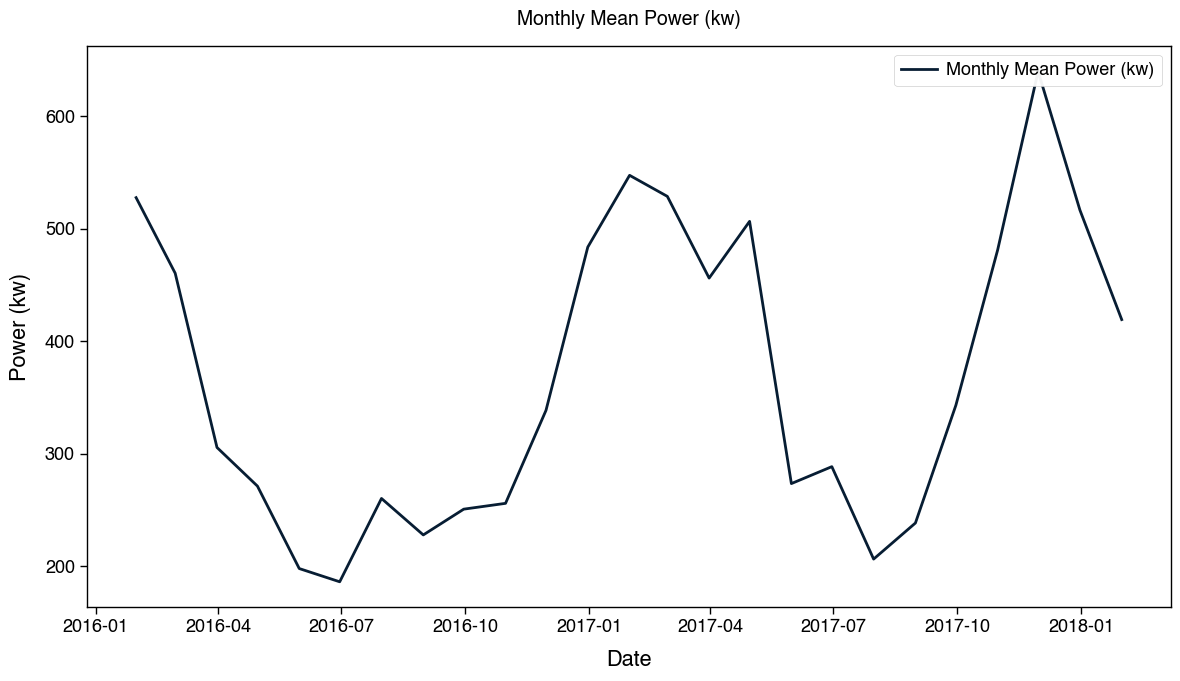

In [26]:
monthly_resample = ts_tt_clean.resample('ME').mean()

plt.figure(figsize=(12,7))
plt.plot(monthly_resample.index, monthly_resample['turbine_power_kw'], label='Monthly Mean Power (kw)')
plt.title('Monthly Mean Power (kw)')
plt.xlabel('Date')
plt.ylabel('Power (kw)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

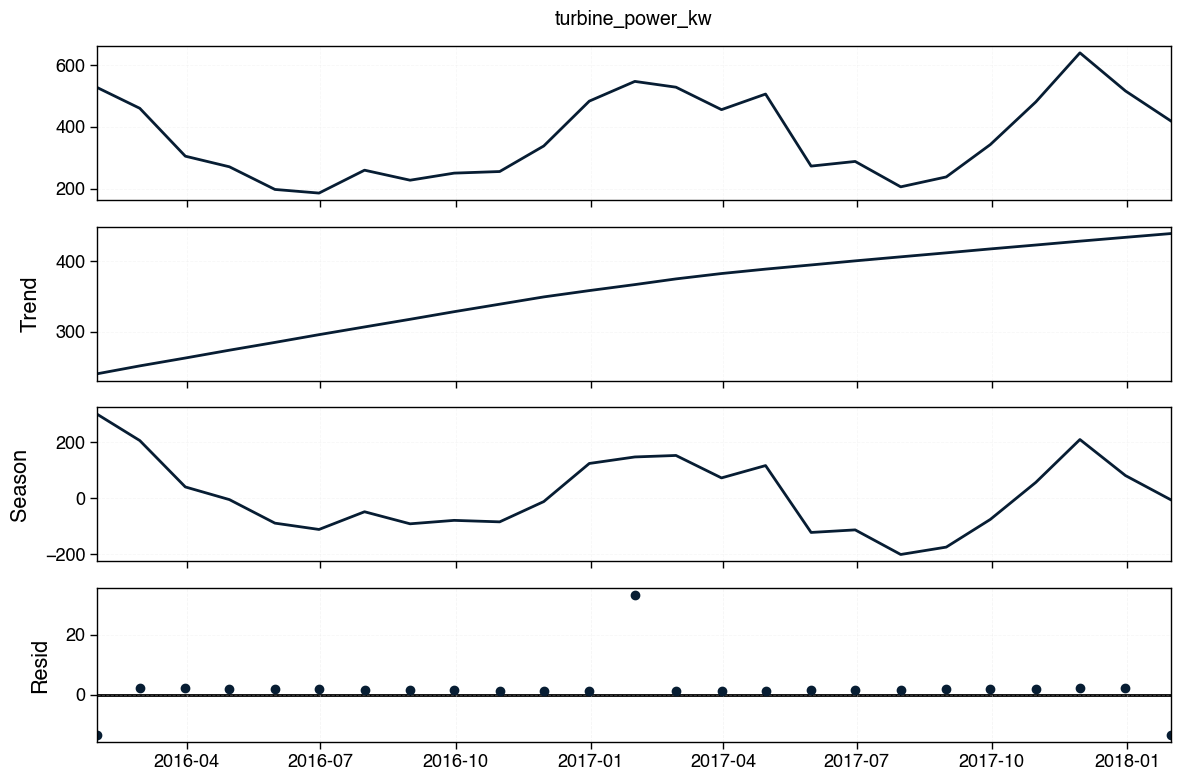

In [27]:
# STL decomposition for monthly_resample
from statsmodels.tsa.seasonal import STL
stl = STL(monthly_resample['turbine_power_kw'], seasonal=13)
res = stl.fit()

# Plot with custom size and layout
fig = res.plot()
fig.set_size_inches(12, 8)  # width, height in inches
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()


### 2.1.4 Period of Zero Turbine Power

In [28]:
# Create a boolean column where power is 0
ts_tt_clean['power_zero'] = ts_tt_clean['turbine_power_kw'] == 0

# Identify start of a new zero-power period
ts_tt_clean['zero_group'] = (ts_tt_clean['power_zero'] != ts_tt_clean['power_zero'].shift()).cumsum()

# Filter only zero-power periods
zero_periods = ts_tt_clean[ts_tt_clean['power_zero']].copy()

# Group by the identified zero period
grouped = zero_periods.groupby('zero_group')

# Compute duration and metadata
durations = grouped.agg(
    start_time=('turbine_power_kw', lambda x: x.index[0]),
    end_time=('turbine_power_kw', lambda x: x.index[-1]),
    duration=('turbine_power_kw', lambda x: x.index[-1] - x.index[0] + pd.Timedelta(minutes=1)),  # add 1 min if sampled by minute
    count=('turbine_power_kw', 'count'),
    max_wind=('wind_baseline_ms', 'max'),
    min_wind=('wind_baseline_ms', 'min'),
    avg_wind=('wind_baseline_ms', 'mean'),
    avg_setpoint=('turbine_setpoint_kw', 'mean')
)
durations.sort_values('duration', ascending=False, inplace=True)

durations.head(10)


start_time            end_time        duration  count  \
zero_group                                                                  
422        2016-02-01 13:39:00 2016-02-04 09:56:00 2 days 20:18:00   4013   
4880       2016-06-28 08:18:00 2016-06-30 15:09:00 2 days 06:52:00   3291   
8350       2016-12-25 11:48:00 2016-12-27 15:27:00 2 days 03:40:00   2333   
5452       2016-07-25 15:21:00 2016-07-26 08:30:00 0 days 17:10:00   1029   
1818       2016-04-13 15:41:00 2016-04-14 07:33:00 0 days 15:53:00    952   
6738       2016-10-01 19:48:00 2016-10-02 09:30:00 0 days 13:43:00    823   
5172       2016-07-16 06:43:00 2016-07-16 18:47:00 0 days 12:05:00    725   
4898       2016-07-04 21:16:00 2016-07-05 09:12:00 0 days 11:57:00    717   
3866       2016-06-06 19:24:00 2016-06-07 07:07:00 0 days 11:44:00    674   
11200      2017-07-10 18:14:00 2017-07-11 05:35:00 0 days 11:22:00    624   

            max_wind  min_wind   avg_wind  avg_setpoint  
zero_group                                               
422             38.1       0.0  10.341166    895.290307  
4880            12.3       0.0   6.506077      0.000000  
8350            47.2       0.0  19.149761    827.518217  
5452            17.7       8.5  11.861808      0.000000  
1818            13.9       3.2   8.703256      0.000000  
6738             2.9       0.0   1.203767    900.000000  
5172            28.5      10.2  16.316552      0.000000  
4898             4.1       0.0   0.850907    900.000000  
3866             3.8       0.0   1.167262    900.000000  
11200            3.2       0.5   1.542308    900.000000

Extended zero-power periods can occur due to different operational or technical reasons:

* **Planned maintenance or scheduled downtime**: Both power and setpoint are zero, indicating an intentional shutdown.
  *Example: Group 4880 (Jun 28–30) and Group 5452 (Jul 25–26) show setpoint consistently at 0.*

* **Grid curtailment or export limitations**: Power is zero despite wind, but setpoint may also be reduced to zero due to external grid constraints.
  *Example: Group 1818 (Apr 13–14) shows moderate wind but zero power and setpoint.*

* **Turbine faults or emergency stops**: High wind and high setpoint with zero power suggest fault-triggered shutdowns.
  *Example: Group 8350 (Dec 25–27) shows high wind (19.1 m/s) and high setpoint (827.5 kW) but zero power.*

* **Extreme weather conditions**: Very high wind speeds may cause the turbine to shut down automatically to prevent damage.
  *Could apply to Group 8350 due to high wind values.*

* **Sensor or data logging errors**: Zero power readings with normal wind and setpoint may result from communication failures or faulty sensors.
  *Example: Group 6738 (Oct 1–2) has normal setpoint (900 kW) but very low wind and no power output.*


In [29]:
ts_tt_clean['2016-06-06 19:24:00':'2016-06-07 07:07:00'].tail(10)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-06-07 06:58:00               0.0                900.0               2.3   
2016-06-07 06:59:00               0.0                900.0               2.8   
2016-06-07 07:00:00               0.0                900.0               1.1   
2016-06-07 07:01:00               0.0                900.0               1.2   
2016-06-07 07:02:00               0.0                900.0               1.3   
2016-06-07 07:03:00               0.0                900.0               2.8   
2016-06-07 07:04:00               0.0                900.0               3.2   
2016-06-07 07:05:00               0.0                900.0               3.4   
2016-06-07 07:06:00               0.0                900.0               3.1   
2016-06-07 07:07:00               0.0                900.0               3.1   

                     turbine_power_baseline_missing      prev_timestamp  \
Timestamp                                                                 
2016-06-07 06:58:00                           False 2016-06-07 06:57:00   
2016-06-07 06:59:00                           False 2016-06-07 06:58:00   
2016-06-07 07:00:00                           False 2016-06-07 06:59:00   
2016-06-07 07:01:00                           False 2016-06-07 07:00:00   
2016-06-07 07:02:00                           False 2016-06-07 07:01:00   
2016-06-07 07:03:00                           False 2016-06-07 07:02:00   
2016-06-07 07:04:00                           False 2016-06-07 07:03:00   
2016-06-07 07:05:00                           False 2016-06-07 07:04:00   
2016-06-07 07:06:00                           False 2016-06-07 07:05:00   
2016-06-07 07:07:00                           False 2016-06-07 07:06:00   

                              delta      prev_delta  prev_power  \
Timestamp                                                         
2016-06-07 06:58:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 06:59:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 07:00:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 07:01:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 07:02:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 07:03:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 07:04:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 07:05:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 07:06:00 0 days 00:01:00 0 days 00:01:00         0.0   
2016-06-07 07:07:00 0 days 00:01:00 0 days 00:01:00         0.0   

                     prev_setpoint  prev_wind  power_zero  zero_group  
Timestamp                                                              
2016-06-07 06:58:00          900.0        1.4        True        3866  
2016-06-07 06:59:00          900.0        2.3        True        3866  
2016-06-07 07:00:00          900.0        2.8        True        3866  
2016-06-07 07:01:00          900.0        1.1        True        3866  
2016-06-07 07:02:00          900.0        1.2        True        3866  
2016-06-07 07:03:00          900.0        1.3        True        3866  
2016-06-07 07:04:00          900.0        2.8        True        3866  
2016-06-07 07:05:00          900.0        3.2        True        3866  
2016-06-07 07:06:00          900.0        3.4        True        3866  
2016-06-07 07:07:00          900.0        3.1        True        3866

### 2.1.5 Relationship of Power and Setpoint

In [30]:
ts_tt_filtered_213 = ts_tt_clean[ts_tt_clean['turbine_power_kw'] > ts_tt_clean['turbine_setpoint_kw']].copy()
ts_tt_filtered_213['exceeds_setpoint'] = (ts_tt_filtered_213['turbine_power_kw'] - ts_tt_filtered_213['turbine_setpoint_kw']).clip(lower=0)


print(f"Average turbine power exceeding setpoint: {ts_tt_filtered_213['exceeds_setpoint'].mean():.2f} kw")
print(f"Max turbine power exceeding setpoint: {ts_tt_filtered_213['exceeds_setpoint'].max():.2f} kw")
print(f"Min turbine power exceeding setpoint: {ts_tt_filtered_213['exceeds_setpoint'].min():.2f} kw")
print(f"\nTotal number of rows with turbine power greater than setpoint: {len(ts_tt_filtered_213)}")

Average turbine power exceeding setpoint: 17.80 kw
Max turbine power exceeding setpoint: 915.00 kw
Min turbine power exceeding setpoint: 1.00 kw

Total number of rows with turbine power greater than setpoint: 133849


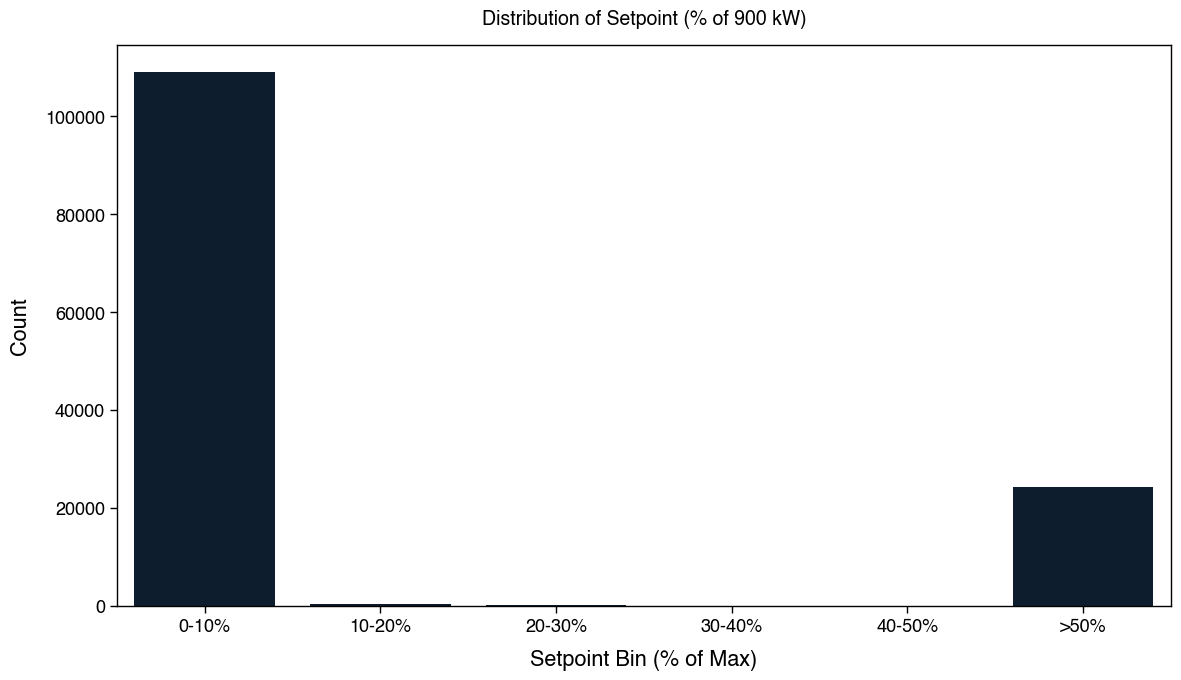

In [31]:
ts_tt_filtered_213['exceedance_pct'] = (
    ts_tt_filtered_213['exceeds_setpoint'] / ts_tt_filtered_213['turbine_setpoint_kw']
)

# Update bin range
exceedance_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, float('inf')]
exceedance_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '>50%']

# Apply cut
ts_tt_filtered_213['exceedance_pct_bin'] = pd.cut(
    ts_tt_filtered_213['exceedance_pct'],
    bins=exceedance_bins,
    labels=exceedance_labels,
    include_lowest=True,
    right=True
)

# Plot
plt.figure(figsize=(12, 7))
sns.countplot(data=ts_tt_filtered_213, x='exceedance_pct_bin', order=exceedance_labels)
plt.title('Distribution of Setpoint (% of 900 kW)')
plt.xlabel('Setpoint Bin (% of Max)')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [32]:
ts_tt_filtered_213[(ts_tt_filtered_213.exceedance_pct>0.1)].head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-01-14 09:49:00             374.0                  0.0               9.1   
2016-01-14 10:33:00              10.0                  0.0               9.1   
2016-01-16 20:23:00              33.0                  0.0               4.2   
2016-01-17 04:00:00              75.0                  0.0               4.7   
2016-01-17 06:28:00               6.0                  0.0              10.3   

                     turbine_power_baseline_missing      prev_timestamp  \
Timestamp                                                                 
2016-01-14 09:49:00                           False 2016-01-14 09:48:00   
2016-01-14 10:33:00                           False 2016-01-14 10:32:00   
2016-01-16 20:23:00                           False 2016-01-16 20:22:00   
2016-01-17 04:00:00                           False 2016-01-17 03:59:00   
2016-01-17 06:28:00                           False 2016-01-17 06:27:00   

                              delta      prev_delta  prev_power  \
Timestamp                                                         
2016-01-14 09:49:00 0 days 00:01:00 0 days 00:01:00       400.0   
2016-01-14 10:33:00 0 days 00:01:00 0 days 00:01:00       332.0   
2016-01-16 20:23:00 0 days 00:01:00 0 days 00:01:00        39.0   
2016-01-17 04:00:00 0 days 00:01:00 0 days 00:01:00       122.0   
2016-01-17 06:28:00 0 days 00:01:00 0 days 00:01:00       226.0   

                     prev_setpoint  prev_wind  power_zero  zero_group  \
Timestamp                                                               
2016-01-14 09:49:00          900.0        9.8       False         109   
2016-01-14 10:33:00          700.0        8.5       False         111   
2016-01-16 20:23:00          900.0        4.2       False         153   
2016-01-17 04:00:00          900.0        5.8       False         157   
2016-01-17 06:28:00          900.0        7.8       False         159   

                     exceeds_setpoint  exceedance_pct exceedance_pct_bin  
Timestamp                                                                 
2016-01-14 09:49:00             374.0             inf               >50%  
2016-01-14 10:33:00              10.0             inf               >50%  
2016-01-16 20:23:00              33.0             inf               >50%  
2016-01-17 04:00:00              75.0             inf               >50%  
2016-01-17 06:28:00               6.0             inf               >50%

There are cases where it is exceeded by infinity where setpoint is 0 but there is still power. We are going to check one of the timestamps of this

In [33]:
# 2016-01-14 09:49:00
ts_tt_og[ts_tt_og.index <= '2016-01-14 10:00:00'].tail(12)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms
Timestamp                                                                   
2016-01-14 09:48:34             400.0                900.0               9.8
2016-01-14 09:49:34             374.0                  0.0               9.1
2016-01-14 09:50:34               0.0                  0.0              10.3
2016-01-14 09:51:34               0.0                  0.0              10.7
2016-01-14 09:52:34               0.0                  0.0              10.5
2016-01-14 09:53:34               0.0                  0.0              10.6
2016-01-14 09:54:34               0.0                  0.0               9.2
2016-01-14 09:55:34               0.0                  0.0               9.5
2016-01-14 09:56:34               0.0                  0.0              10.0
2016-01-14 09:57:34               0.0                  0.0               9.5
2016-01-14 09:58:34               0.0                  0.0              10.9
2016-01-14 09:59:34               0.0                  0.0              10.7

The data suggests that the turbine underwent a controlled shutdown, likely for maintenance or curtailment reasons. Here is the reasoning:

* At 09:48:34, the turbine setpoint is at 900 kW, and the turbine is generating 400 kW, which indicates normal operation.
* At 09:49:34, the setpoint suddenly drops to 0 kW, indicating that the turbine was commanded to stop generating power.
* Despite the setpoint being zero, the turbine still produces 374 kW of power. This is expected, as the turbine blades continue to spin momentarily due to inertia and sustained wind.
* Over the next several minutes, the turbine power gradually falls to 0 kW, even though wind speeds remain high (9 to 11 meters per second). This confirms that the shutdown was not due to a lack of wind, but rather a deliberate decision to halt production.

This pattern, where the setpoint drops suddenly and is followed by a gradual decline in power while wind remains strong, is a typical signature of a turbine shutdown sequence. It may have been triggered by scheduled maintenance, a safety condition, or grid curtailment.

\
\
Next, we will check the case where the turbine power exceed the setpoint greater than 0.1%


In [34]:
ts_tt_filtered_213[(ts_tt_filtered_213.exceedance_pct>0.1) & (ts_tt_filtered_213.exceedance_pct != np.inf)].head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2016-02-22 14:45:00             647.0                250.0              18.1   
2016-02-22 17:09:00             798.0                521.0              17.4   
2016-02-22 23:06:00             797.0                514.0              16.2   
2016-02-23 00:05:00             654.0                496.0              15.5   
2016-02-23 00:19:00             655.0                479.0              18.8   

                     turbine_power_baseline_missing      prev_timestamp  \
Timestamp                                                                 
2016-02-22 14:45:00                           False 2016-02-22 14:44:00   
2016-02-22 17:09:00                           False 2016-02-22 17:08:00   
2016-02-22 23:06:00                           False 2016-02-22 23:05:00   
2016-02-23 00:05:00                           False 2016-02-23 00:04:00   
2016-02-23 00:19:00                           False 2016-02-23 00:18:00   

                              delta      prev_delta  prev_power  \
Timestamp                                                         
2016-02-22 14:45:00 0 days 00:01:00 0 days 00:01:00       903.0   
2016-02-22 17:09:00 0 days 00:01:00 0 days 00:01:00       908.0   
2016-02-22 23:06:00 0 days 00:01:00 0 days 00:01:00       888.0   
2016-02-23 00:05:00 0 days 00:01:00 0 days 00:01:00       819.0   
2016-02-23 00:19:00 0 days 00:01:00 0 days 00:01:00       900.0   

                     prev_setpoint  prev_wind  power_zero  zero_group  \
Timestamp                                                               
2016-02-22 14:45:00          900.0       16.5       False         487   
2016-02-22 17:09:00          900.0       14.6       False         487   
2016-02-22 23:06:00          900.0       17.4       False         487   
2016-02-23 00:05:00          900.0       13.4       False         487   
2016-02-23 00:19:00          900.0       18.3       False         487   

                     exceeds_setpoint  exceedance_pct exceedance_pct_bin  
Timestamp                                                                 
2016-02-22 14:45:00             397.0        1.588000               >50%  
2016-02-22 17:09:00             277.0        0.531670               >50%  
2016-02-22 23:06:00             283.0        0.550584               >50%  
2016-02-23 00:05:00             158.0        0.318548             30-40%  
2016-02-23 00:19:00             176.0        0.367432             30-40%

In [35]:
# 2016-02-22 14:45:00
ts_tt_og[ts_tt_og.index <= '2016-02-22 14:50:00'].tail(12)

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms
Timestamp                                                                   
2016-02-22 14:38:16             900.0                900.0              20.7
2016-02-22 14:39:16             905.0                900.0              18.7
2016-02-22 14:40:16             903.0                900.0              19.8
2016-02-22 14:41:16             897.0                900.0              17.0
2016-02-22 14:42:16             888.0                900.0              19.6
2016-02-22 14:43:16             902.0                900.0              19.3
2016-02-22 14:44:16             903.0                900.0              16.5
2016-02-22 14:45:16             647.0                250.0              18.1
2016-02-22 14:46:16             656.0                751.0              20.3
2016-02-22 14:47:16             900.0                900.0              17.8
2016-02-22 14:48:16             882.0                900.0              17.9
2016-02-22 14:49:16             893.0                900.0              16.7

The data suggests that the turbine experienced a brief period of curtailment or grid response.

* From 14:38:16 to 14:44:16, the turbine setpoint remains steady at 900 kW, and the turbine consistently generates close to full capacity, with power readings between 888 and 905 kW.
* At 14:45:16, the setpoint drops sharply to 250 kW, while the turbine still produces 647 kW. This suggests that the curtailment command was issued, but the turbine had not yet fully responded due to residual power from spinning blades.
* At 14:46:16, the setpoint rises to 751 kW, and turbine power increases slightly to 656 kW, indicating a gradual recovery from the curtailment.
* By 14:47:16, the setpoint returns to 900 kW, and the turbine resumes generating around 900 kW, continuing normal operation.

This pattern, where the setpoint drops and then quickly recovers while wind speeds remain high, is typical of a short-duration curtailment event. It may have been triggered by grid congestion, power balancing requirements, or other temporary grid stability measures.

#### 2.1.5.1 Curtailment on Wind Turbine Data

year      curtailment_type  proportion
0  2016         not_curtailed   84.262248
1  2016       fully_curtailed   12.109087
2  2016  marginally_curtailed    3.628665
3  2017         not_curtailed   92.555228
4  2017       fully_curtailed    5.038496
5  2017  marginally_curtailed    2.406276
6  2018         not_curtailed   99.966115
7  2018  marginally_curtailed    0.033885

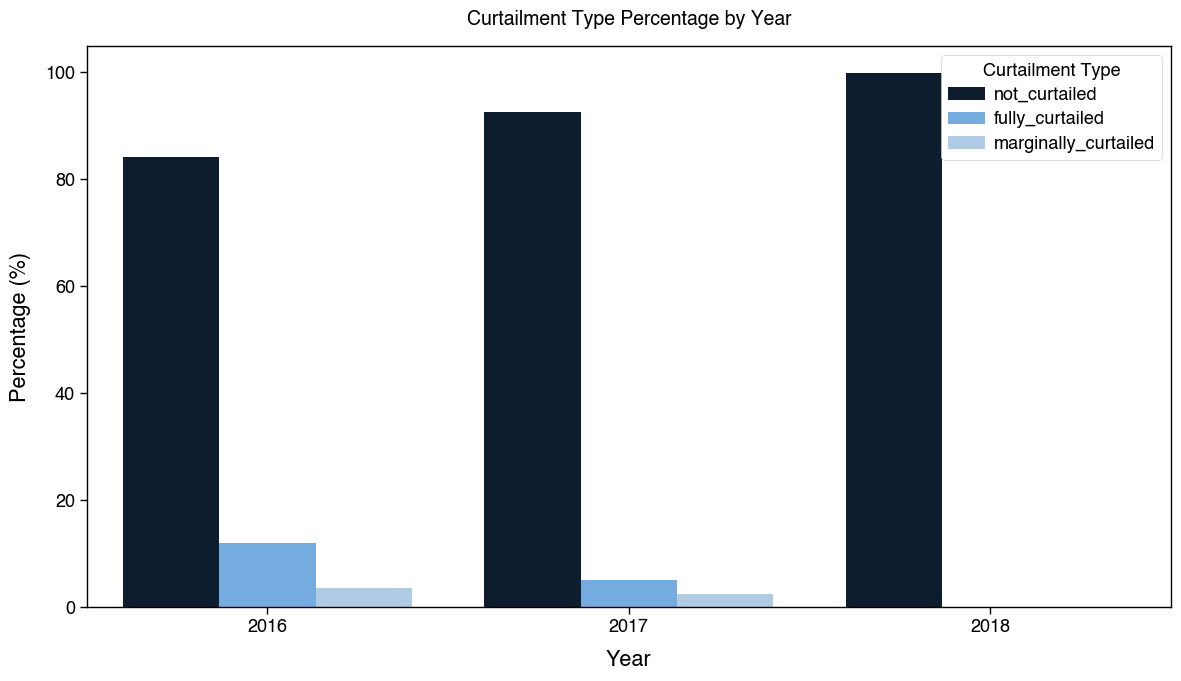

In [36]:
# fully_curtailed when setpoint is 0
# marginally curtailed when setpoint is less than 900

ts_tt_clean['curtailment_type'] = 'not_curtailed'
ts_tt_clean.loc[ts_tt_clean['turbine_setpoint_kw'] == 0, 'curtailment_type'] = 'fully_curtailed'
ts_tt_clean.loc[
    (ts_tt_clean['turbine_setpoint_kw'] < 900) & 
    (ts_tt_clean['turbine_setpoint_kw'] > 0),
    'curtailment_type'
] = 'marginally_curtailed'

ts_tt_clean['curtailment_kw'] = 900 - ts_tt_clean['turbine_setpoint_kw']
ts_tt_clean.loc[ts_tt_clean['curtailment_kw'] < 0, 'curtailment_kw'] = 0  # avoid negative values

# calculate percentage of curtailment_type for each year
ts_tt_clean['year'] = ts_tt_clean.index.year
curtailment_type_counts = ts_tt_clean.groupby('year')['curtailment_type'].value_counts(normalize=True) * 100
curtailment_type_counts = pd.DataFrame(curtailment_type_counts).rename(columns={'curtailment_type': 'Percentage'}).reset_index()
display(curtailment_type_counts)
# plot the results
plt.figure(figsize=(12, 7))
sns.barplot(data=curtailment_type_counts, x='year', y='proportion', hue='curtailment_type')
plt.title('Curtailment Type Percentage by Year')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend(title='Curtailment Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 2.1.6 Relationship of Power and Wind

Power output of a wind turbine is influenced by wind speed. Stronger winds cause the turbine blades to rotate faster, which increases mechanical power and leads to higher electrical generation. Wind turbines operate within a specific wind speed range defined by the cut-in and cut-off limits. If the wind speed is below the cut-in threshold, the turbine does not generate power. If the wind speed exceeds the cut-off limit, it becomes mechanically unsafe for the turbine to continue operating, as it may lead to faults or damage.


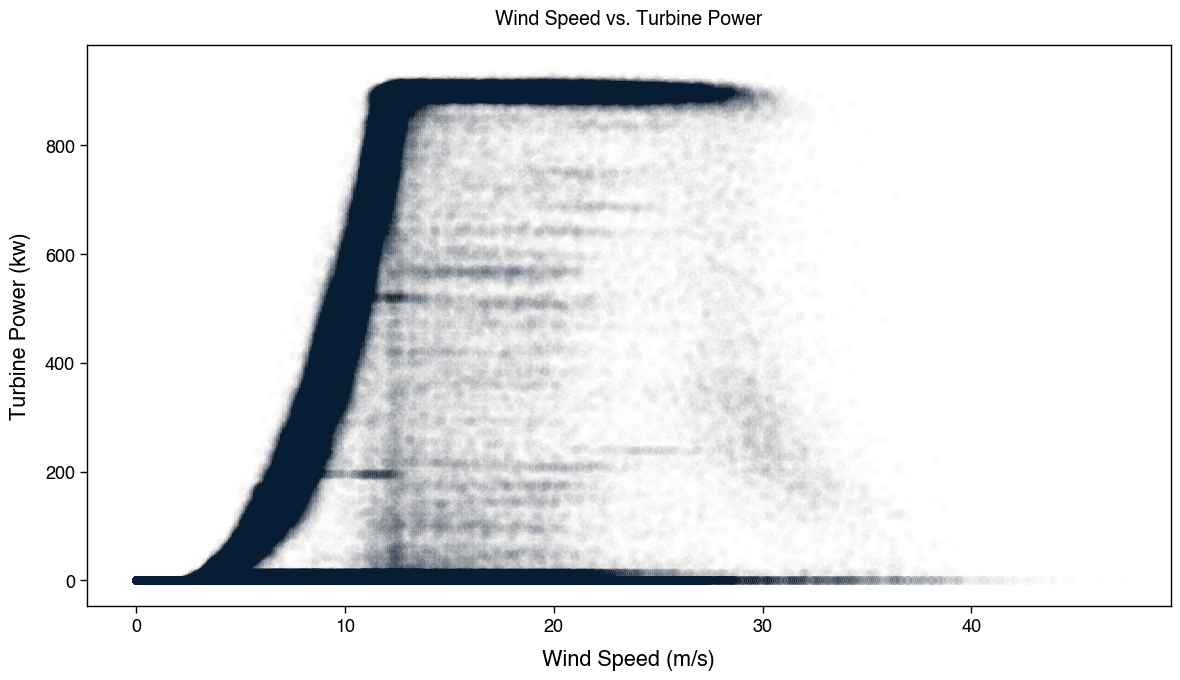

In [37]:
plt.figure(figsize=(12, 7))
plt.scatter(ts_tt_clean.wind_baseline_ms, ts_tt_clean.turbine_power_kw, alpha=0.01)
plt.title('Wind Speed vs. Turbine Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Turbine Power (kw)')
plt.grid()
plt.tight_layout()
plt.show()

The relationship between wind speed and power output is typically provided by the turbine manufacturer in the form of a turbine power curve, which represents the theoretical power generation of a turbine based on wind speed. However, when manufacturer specifications are not available, the power curve must be estimated from measured data. Common approaches include binning techniques, such as those outlined in the IEC 61400-12-1 standard (IEC, 2017), and parametric curve fitting methods, including sigmoid, logistic, or polynomial models.

#### 2.1.6.1 Weibull Distribution Model

To derive the power curve using the baseline wind speed and power output we will use a derivation of weibull distribution model to measure the distribution. 


$$
P(\nu) = P_r \left(1 - e^{- \left(\frac{\nu - v_0}{c}\right)^3} \right)
$$

Where:

* $\nu$ = wind speed
* $v_0$ = minimum wind speed (`cut_in_speed`)
* $c$ = scale parameter
* $P_r$ = rated power

In [38]:
def delayed_weibull(v:float, v0:float, c:float, pr:float):
    """
    Weibull model for wind speed distribution.
    
    Parameters:
    pr (float): Power rating of the turbine in kW. (or setpoint in our case i think)
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the Weibull distribution in m/s.
    
    Returns:
    float: Power output in kW.
    """
    v = np.asarray(v)
    power = np.zeros_like(v)
    mask = v > v0
    power[mask] = pr * (1 - np.exp(-((v[mask] - v0) / c) ** 3))
    return power

df_power_curve = ts_tt_clean.copy()
df_power_curve = df_power_curve.drop(columns=['prev_timestamp','delta','prev_delta','prev_power','prev_setpoint','prev_wind','curtailment_type','curtailment_kw','year'])

To fit the wind and power to a curve using weibull distribution we need to properly filter out the data where curtailment occur both marginally and fully. As these points does not properly explain the correlation of wind and power

In [39]:
df_power_curve = df_power_curve[df_power_curve['turbine_setpoint_kw'] == 900]

We also need to exclude datapoints where wind speed is  above the cut-in point but there is no power. This could be that the turbine is manually switch off or there is a fault in the turbine.

In [40]:
cut_in_speed = ts_tt_clean[(ts_tt_clean.loc[:, 'turbine_power_kw'] >= 10.)].loc[:, 'wind_baseline_ms'].quantile(0.1) # 10% quantile

df_power_curve.loc[
    (df_power_curve.wind_baseline_ms >= cut_in_speed) & (df_power_curve.turbine_power_kw.abs() <= 1e-5),
    'turbine_power_kw'
] = np.nan

df_power_curve = df_power_curve.dropna(subset=['turbine_power_kw','wind_baseline_ms'])

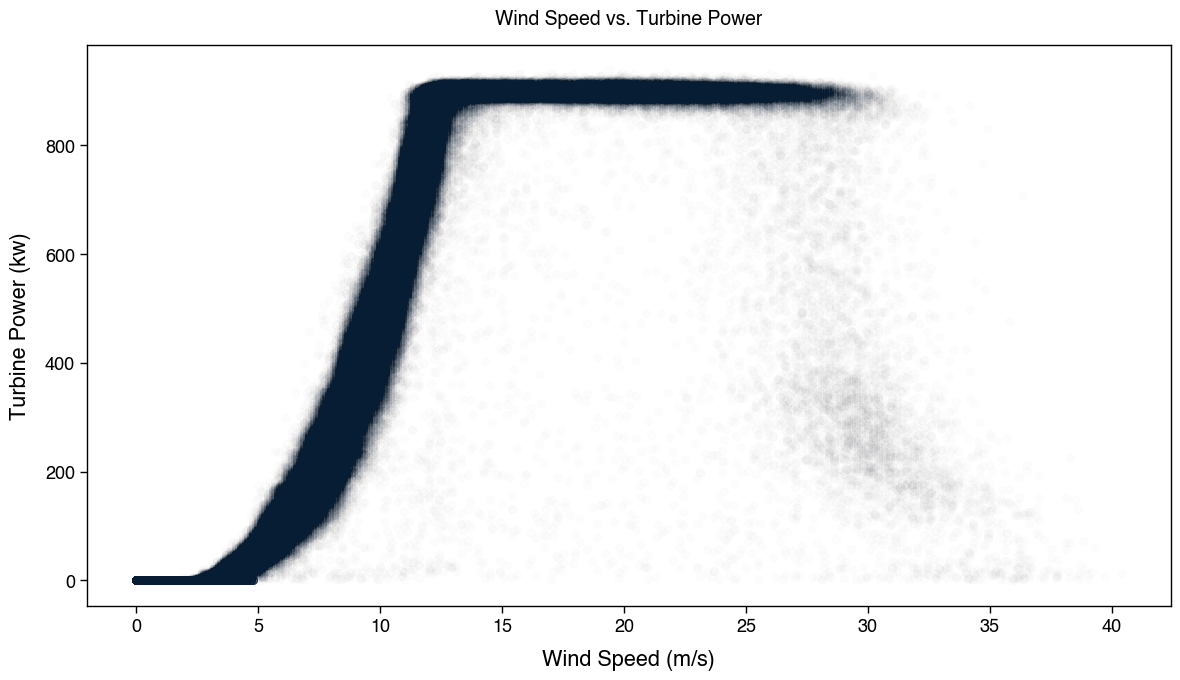

In [41]:
# plot the power curve
plt.figure(figsize=(12, 7))
plt.scatter(df_power_curve['wind_baseline_ms'], df_power_curve['turbine_power_kw'], alpha=0.01)
plt.title('Wind Speed vs. Turbine Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Turbine Power (kw)')
plt.grid()
plt.tight_layout()
plt.show()

The figure above illustrates the relationship between wind speed and turbine power output. As shown, the power curve exhibits a characteristic "S" shape, which reflects the physical behavior of a typical wind turbine.

At low wind speeds (below approximately 3–4 m/s), the turbine remains inactive due to insufficient wind force to overcome mechanical inertia and generate electricity. This region corresponds to the **cut-in wind speed**, below which power output is effectively zero.

As wind speed increases beyond the cut-in threshold, the turbine begins to operate, and power output rises rapidly. In this region, power output increases approximately with the **cube of wind speed**, which is consistent with the physics of wind energy capture, where $P \propto v^3$ under ideal conditions.

Once the wind speed reaches around 11–12 m/s, the turbine approaches its **rated power**. Beyond this point, the turbine is controlled to maintain a constant output—typically through blade pitch adjustment or generator control—to prevent mechanical overload. This plateau is the **rated region** of the turbine.

At very high wind speeds (typically above 25 m/s), the turbine shuts down as a safety measure to avoid structural damage. This is known as the **cut-out wind speed**, after which power output drops sharply back to zero. In the plot, this can be seen as a drop-off in data density beyond 25–30 m/s.

The scattered points beyond the rated wind speed region may represent transient or abnormal operating conditions, measurement noise, or incomplete curtailment during high winds.

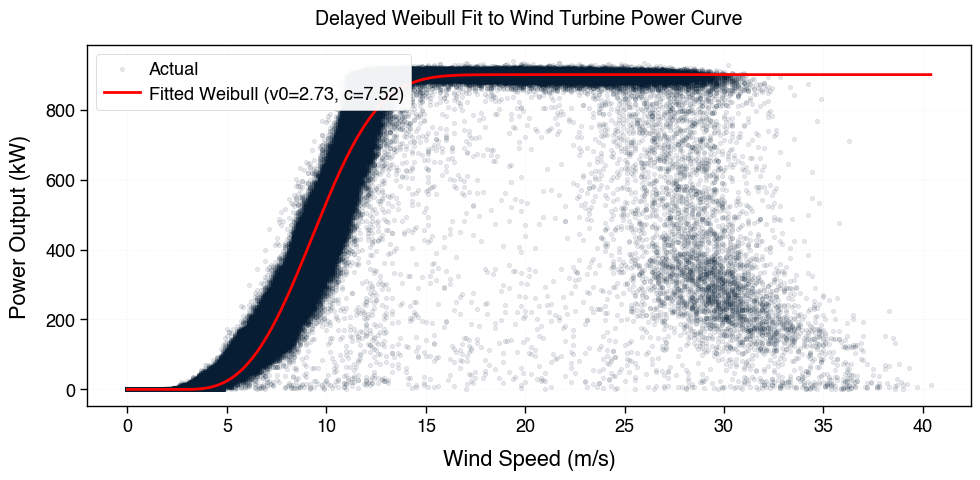

(np.float64(2.7333188761004665), np.float64(7.524894149118479))

In [42]:
wind = df_power_curve['wind_baseline_ms'].values
power = df_power_curve['turbine_power_kw'].values

## Initial guesses for v0 and c
initial_guess = [2.7, 6.5]

## Fit curve
popt, pcov = curve_fit(lambda v, v0, c: delayed_weibull(v, v0, c, pr=900), wind, power, p0=initial_guess)

## Predicted values using fitted parameters
v0_fit, c_fit = popt
predicted_power = delayed_weibull(wind, v0_fit, c_fit, pr=900)

## Plot actual vs fitted curve
v_sorted = np.sort(wind)

predicted_sorted = delayed_weibull(v_sorted, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, label='Actual', s=10, alpha=0.1,)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Wind Turbine Power Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

In [43]:
weibull_compare = pd.DataFrame({
    'Wind Speed (m/s)': wind,
    'Power Output (kW)': power,
    'Predicted Power Output (kW)': predicted_power
})

weibull_compare['Residuals'] = weibull_compare['Power Output (kW)'] - weibull_compare['Predicted Power Output (kW)']
weibull_compare['Residuals'] = weibull_compare['Residuals'].abs()

r_score = r2_score(weibull_compare['Power Output (kW)'], weibull_compare['Predicted Power Output (kW)'])
rmse = root_mean_squared_error(weibull_compare['Power Output (kW)'], weibull_compare['Predicted Power Output (kW)'])
mae = mean_absolute_error(weibull_compare['Power Output (kW)'], weibull_compare['Predicted Power Output (kW)'])
mse = mean_squared_error(weibull_compare['Power Output (kW)'], weibull_compare['Predicted Power Output (kW)'])

weibull_metrics = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE', 'MSE'],
    'Value': [r_score, rmse, mae, mse]
})

display(weibull_metrics)

Metric        Value
0    R^2     0.961444
1   RMSE    65.974801
2    MAE    38.533740
3    MSE  4352.674347

#### 2.1.6.2 Binning Method

/var/folders/9s/vnh0yrb52292pp21phjjlqpm0000gn/T/ipykernel_11710/4287350407.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_curve = df_power_curve.groupby('wind_bin').agg(


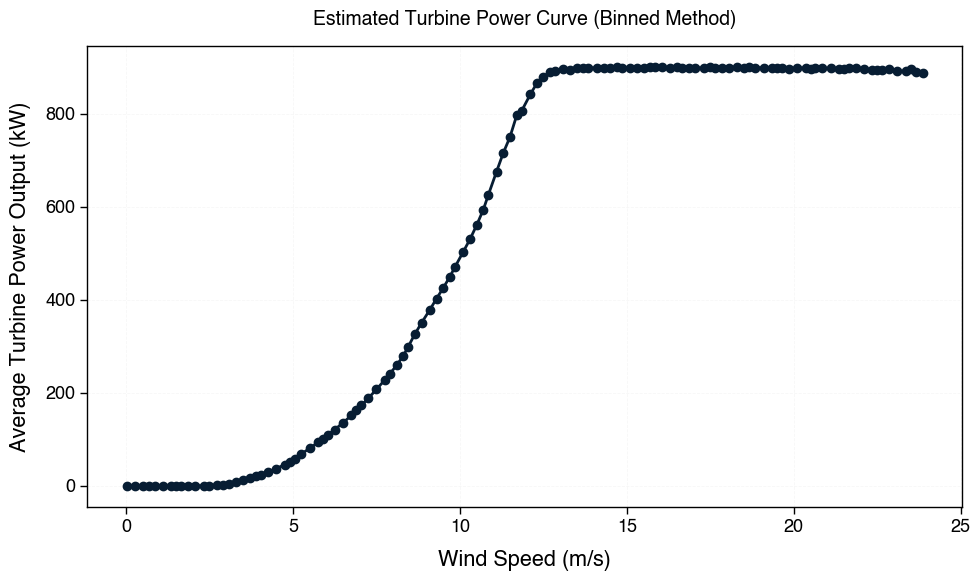

In [44]:
# Define bin width (e.g., 0.5 m/s) and bin edges
bin_width = 0.2
wind_min = cut_in_speed
wind_max = df_power_curve[df_power_curve.turbine_power_kw == df_power_curve.turbine_power_kw.quantile(0.90)].wind_baseline_ms.quantile(0.95)
bins = np.arange(0, wind_max + bin_width, bin_width)

# Assign each row to a wind speed bin
df_power_curve['wind_bin'] = pd.cut(df_power_curve['wind_baseline_ms'], bins=bins, right=False)

# Group by wind speed bin and calculate mean wind speed and power
binned_curve = df_power_curve.groupby('wind_bin').agg(
    mean_wind_speed=('wind_baseline_ms', 'mean'),
    mean_power_output=('turbine_power_kw', 'mean'),
    count=('turbine_power_kw', 'count')
).dropna()

# Plotting the estimated power curve and the power and wind
plt.figure(figsize=(10, 6))
plt.plot(binned_curve['mean_wind_speed'], binned_curve['mean_power_output'], marker='o', linestyle='-')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Average Turbine Power Output (kW)')
plt.title('Estimated Turbine Power Curve (Binned Method)')
plt.grid(True)
plt.tight_layout()
plt.show()

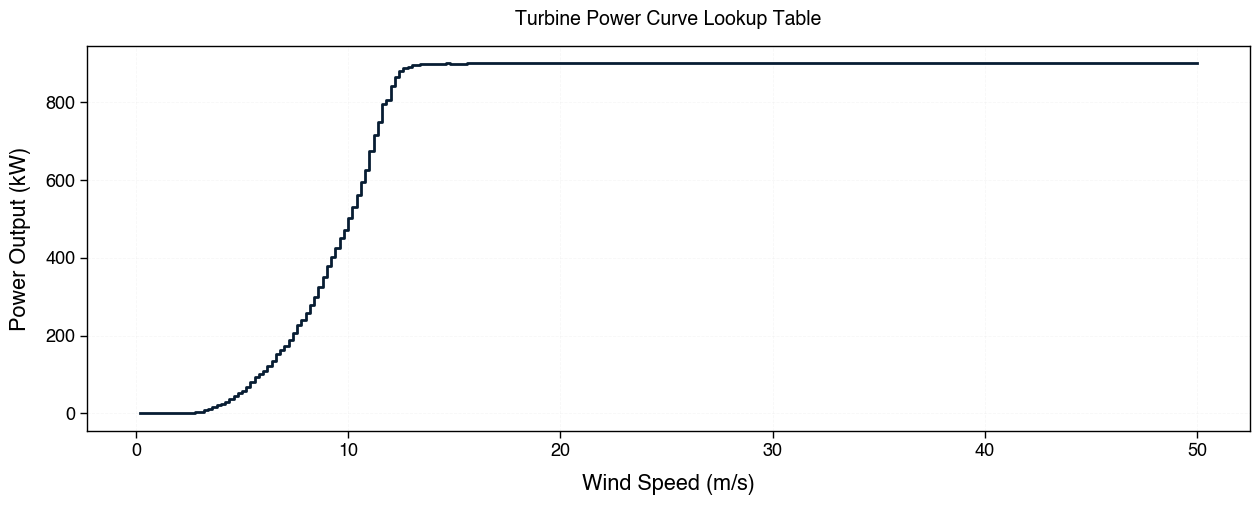

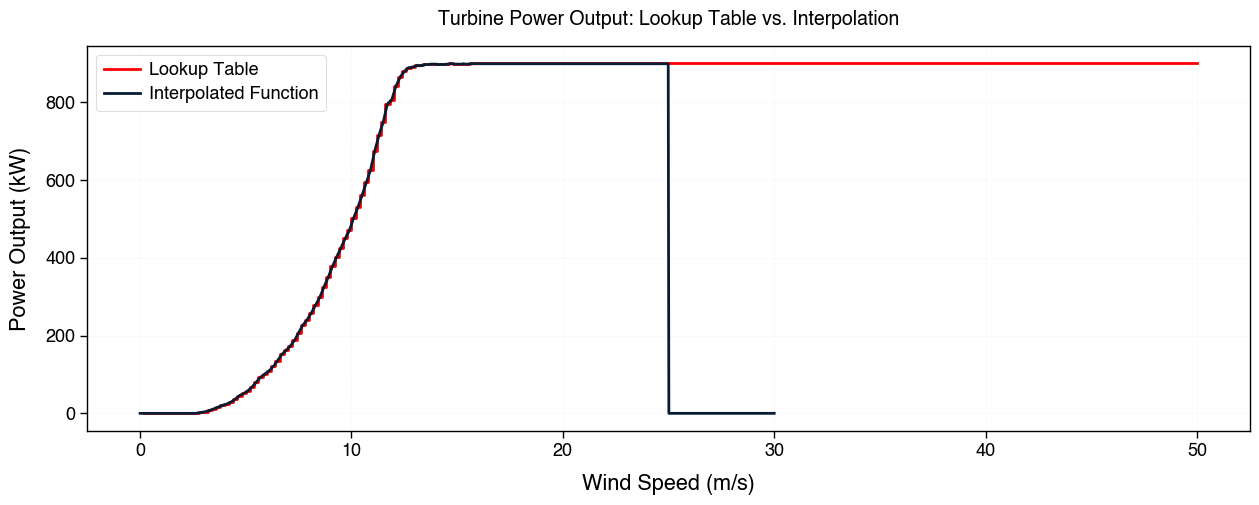

In [45]:
# --- Step 1: Group and Aggregate Data ---
gp = df_power_curve.groupby('wind_bin',observed=True)
lutm = gp['turbine_power_kw'].mean().round(2)
luts = gp['turbine_power_kw'].std()

# --- Step 2: Ensure Index is IntervalIndex ---
if not isinstance(lutm.index, pd.IntervalIndex):
    lutm.index = pd.IntervalIndex(lutm.index)
    luts.index = pd.IntervalIndex(luts.index)

# --- Step 3: Extend to Gusts ---
# Add new interval for high wind gusts and set power to max
gust_interval = pd.Interval(15.8, 50)
lutm.loc[gust_interval] = 900

# Cap power output for all intervals ending at or after 15.8 m/s
lutm[[i.right >= 15.8 for i in lutm.index]] = 900

# --- Step 4: Clean and Rebuild Index ---
# Filter out non-interval entries and enforce consistent closure
valid_intervals = [i for i in lutm.index if isinstance(i, pd.Interval)]
lutm = lutm.loc[valid_intervals]
lutm.index = pd.IntervalIndex(lutm.index, closed='right')

# --- Step 5: Plot Step Function of Lookup Table ---
plt.figure(figsize=(15, 5))
plt.step([i.right for i in lutm.index], lutm.values, where='pre')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Output (kW)")
plt.title("Turbine Power Curve Lookup Table")
plt.grid(True)
plt.show()

# --- Step 6: Prepare for Interpolation ---
wind_ms = lutm.index.mid.values                # Bin centres
power_kw = lutm.values / lutm.max()            # Normalized power

# --- Step 7: Define Interpolation Function ---
@np.vectorize
def turbine_max_power_kw(wind_speed_ms, max_power_kw=900, max_wind_speed_ms=25):
    """Interpolates power output based on wind speed using LUT."""
    if np.isnan(wind_speed_ms):
        return np.nan
    if wind_speed_ms > max_wind_speed_ms:
        return 0

    right_ind = np.searchsorted(wind_ms, wind_speed_ms)
    if right_ind == 0:
        return 0

    left_ind = right_ind - 1
    left_wind, right_wind = wind_ms[left_ind], wind_ms[right_ind]
    left_pow, right_pow = power_kw[left_ind], power_kw[right_ind]
    
    grad = (right_pow - left_pow) / (right_wind - left_wind)
    interp_power = left_pow + grad * (wind_speed_ms - left_wind)
    
    return interp_power * max_power_kw

# --- Step 8: Compare Lookup Table with Interpolated Function ---
ws = np.linspace(0, 30, 1000)

plt.figure(figsize=(15, 5))
step_plot = plt.step(lutm.index.right, lutm.to_numpy(), color='red', where='pre')
line_plot = plt.plot(ws, turbine_max_power_kw(ws, max_wind_speed_ms=25), label='Interpolated Curve')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Output (kW)")
plt.title("Turbine Power Output: Lookup Table vs. Interpolation")
plt.legend(['Lookup Table', 'Interpolated Function'], loc='upper left')
plt.grid(True)
plt.show()

In [46]:
pred_power_binning = turbine_max_power_kw(wind, max_wind_speed_ms=25)
binning_compare = pd.DataFrame({
    'Wind Speed (m/s)': wind,
    'Power Output (kW)': power,
    'Predicted Power Output (kW)': pred_power_binning
})

binning_compare['Residuals'] = binning_compare['Power Output (kW)'] - binning_compare['Predicted Power Output (kW)']
binning_compare['Residuals'] = binning_compare['Residuals'].abs()

b_r_score = r2_score(binning_compare['Power Output (kW)'], binning_compare['Predicted Power Output (kW)'])
b_rmse = root_mean_squared_error(binning_compare['Power Output (kW)'], binning_compare['Predicted Power Output (kW)'])
b_mae = mean_absolute_error(binning_compare['Power Output (kW)'], binning_compare['Predicted Power Output (kW)'])
b_mse = mean_squared_error(binning_compare['Power Output (kW)'], binning_compare['Predicted Power Output (kW)'])

binning_metrics = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE', 'MSE'],
    'Value': [b_r_score, b_rmse, b_mae, b_mse]
})

display(binning_metrics)

Metric        Value
0    R^2     0.917183
1   RMSE    96.692293
2    MAE    33.660188
3    MSE  9349.399594

#### 2.1.6.3 Method Comparison

In [47]:
# compare binning_metrics and weibull_metrics
comparison = pd.merge(weibull_metrics, binning_metrics, on='Metric', suffixes=('_weibull', '_binning'))

comparison

Metric  Value_weibull  Value_binning
0    R^2       0.961444       0.917183
1   RMSE      65.974801      96.692293
2    MAE      38.533740      33.660188
3    MSE    4352.674347    9349.399594

Based on the metrics provided, the Weibull model performs better overall compared to the binning method. The Weibull model has a higher R-squared value, which means it explains more of the variance in the data. It also has lower RMSE and MSE values, indicating smaller overall prediction errors, especially for large errors. Although the binning method has a slightly lower MAE, which means it has a lower average absolute error, this metric alone does not outweigh the benefits seen in the other three metrics. Therefore, the Weibull model is the better choice for this task.

#### 2.1.6.4 Cut In and Cut Out Speed

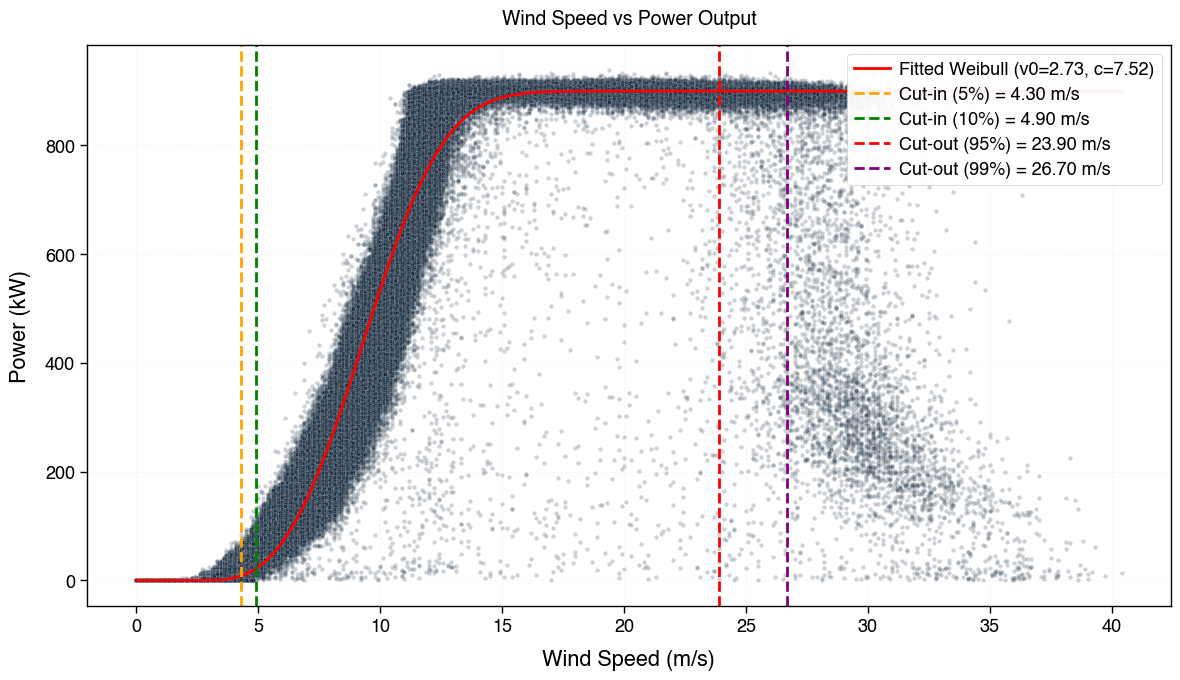

In [48]:
## Filter out rows with missing data

## Compute both quantiles for cut-in and cut-out
cutin_05 = df_power_curve[df_power_curve['turbine_power_kw'] >= 10]['wind_baseline_ms'].quantile(0.05)
cutin_10 = df_power_curve[df_power_curve['turbine_power_kw'] >= 10]['wind_baseline_ms'].quantile(0.10)
cutout_95 = df_power_curve[df_power_curve.turbine_power_kw == df_power_curve.turbine_power_kw.quantile(0.90)].wind_baseline_ms.quantile(0.95)
cutout_99 = df_power_curve[df_power_curve.turbine_power_kw == df_power_curve.turbine_power_kw.quantile(0.90)].wind_baseline_ms.quantile(0.99)

## Create scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_power_curve, x='wind_baseline_ms', y='turbine_power_kw', alpha=0.2, s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')

## Draw cut-in / cut-out lines
plt.axvline(cutin_05, color='orange', linestyle='--', label=f'Cut-in (5%) = {cutin_05:.2f} m/s')
plt.axvline(cutin_10, color='green', linestyle='--', label=f'Cut-in (10%) = {cutin_10:.2f} m/s')
plt.axvline(cutout_95, color='red', linestyle='--', label=f'Cut-out (95%) = {cutout_95:.2f} m/s')
plt.axvline(cutout_99, color='purple', linestyle='--', label=f'Cut-out (99%) = {cutout_99:.2f} m/s')

## Labels and legend
plt.title('Wind Speed vs Power Output')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.1.7 Treating Missing Values

#### 2.1.7.1 Resampling Data to 30 Minutes

In [49]:
ts_tt_30min = ts_tt_clean.resample('30min').agg({
    'turbine_power_kw': 'mean',
    'turbine_setpoint_kw': 'mean',
    'wind_baseline_ms': 'mean',
    'power_zero': 'sum',
    'turbine_power_baseline_missing': ['any', 'sum'],  # 'any' = any True, 'sum' = how many Trues
})

# Rename the multi-level columns for clarity
ts_tt_30min.columns = [
    'turbine_power_kw',
    'turbine_setpoint_kw',
    'wind_baseline_ms',
    'turbine_power_zero_count',
    'any_missing',
    'missing_count'
]

# Add total row count per period (i.e., number of 1-min entries per 30-min window)
ts_tt_30min['row_count'] = ts_tt_clean.resample('30min').size()

ts_tt_30min = ts_tt_30min.loc['2017-01-01':'2018-01-01']

ts_tt_30min.head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-01-01 00:00:00        894.033333                900.0         13.820000   
2017-01-01 00:30:00        898.266667                900.0         16.106667   
2017-01-01 01:00:00        902.866667                900.0         16.380000   
2017-01-01 01:30:00        907.833333                900.0         17.083333   
2017-01-01 02:00:00        907.000000                900.0         16.800000   

                     turbine_power_zero_count  any_missing  missing_count  \
Timestamp                                                                   
2017-01-01 00:00:00                         0        False              0   
2017-01-01 00:30:00                         0        False              0   
2017-01-01 01:00:00                         0        False              0   
2017-01-01 01:30:00                         0        False              0   
2017-01-01 02:00:00                         0        False              0   

                     row_count  
Timestamp                       
2017-01-01 00:00:00         30  
2017-01-01 00:30:00         30  
2017-01-01 01:00:00         30  
2017-01-01 01:30:00         30  
2017-01-01 02:00:00          1

In [50]:
ts_tt_30min.isna().sum()

turbine_power_kw            1012
turbine_setpoint_kw         1012
wind_baseline_ms            1012
turbine_power_zero_count       0
any_missing                    0
missing_count                  0
row_count                      0
dtype: int64

There is still 1012 points of missing values this equaites around 506 hours of data

#### 2.1.7.2 Scraping Weather Data

In sections 2.1.1 and 2.1.2, we identified gaps in the dataset where no data is available for certain time periods. To address this, we decided to incorporate historical wind speed data from timeanddate.com for Kirkwall. After inspecting the network requests made by the site, we found that the data is retrieved in JSON format via an internal API at `https://www.timeanddate.com/scripts/cityajax.php`. This API does not require any authentication headers.

The API accepts the following query parameters:

```python
query_params = {
    "n": "uk/kirkwall",
    "mode": "historic",
    "hd": date_str,
    "month": date.month,
    "year": date.year,
    "json": "1"
}
```

Using this, we created a scraper script that sends GET requests to collect wind speed data for each day from January 1, 2017, to January 1, 2018. This timeframe matches the coverage of our existing demand data, allowing us to align both datasets and fill the gaps in a consistent manner.

In [51]:
# load scraped wind data
df_wd_og = pd.read_csv(RAW_DATASET_PATH / 'kirkwall_weather.csv')

df_wd = df_wd_og.copy().rename(columns={
    'Time': 'Timestamp',
    'Wind Speed (m/s)': 'wind_scraped_ms',
    'Temperature (F)': 'temperature_scraped_F',
    })
# drop columns Icon, Description Wind Direction	Humidity (%)	Pressure (Hg)	Visibility (mi)
df_wd = df_wd.drop(columns=['Icon', 'Description', 'Wind Direction', 'Humidity (%)', 'Pressure (Hg)', 'Visibility (mi)'])

df_wd.head()

Timestamp  temperature_scraped_F wind_scraped_ms
0  2017-01-01 00:20:00                     41           10.28
1  2017-01-01 00:50:00                     43            9.39
2  2017-01-01 01:20:00                     41            9.83
3  2017-01-01 01:50:00                     39            7.15
4  2017-01-01 02:20:00                     41            8.94

In [52]:
# Convert timestamp to datetime
df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])

# Sort value based on timestamp
df_wd = df_wd.sort_values('Timestamp').reset_index(drop=True)

# aligning timestamp 00:20 into 00:30 and 00:50 to 01:00
df_wd['Timestamp'] = df_wd.Timestamp.apply(lambda x: x + pd.Timedelta(minutes=10))

df_wd['wind_scraped_ms'] = pd.to_numeric(df_wd['wind_scraped_ms'], errors='coerce').fillna(0.0)

# Convert temperature Fahrenheit to Celsius and keep 1 decimal point
df_wd['temperature_scraped_C'] = (df_wd['temperature_scraped_F'] - 32) * 5.0 / 9.0

df_wd['temperature_scraped_C'] = df_wd['temperature_scraped_C'].round(1)

# Convert Non Numeric Values to NaN in Temperature
df_wd['temperature_scraped_C'] = pd.to_numeric(df_wd['temperature_scraped_C'], errors='coerce')

# df_wd.to_csv(PROCESSED_DATASET_PATH / 'kirkwall_weather_cleaned.csv', index=True)

# resample to 30 mminutes
df_wd_timeindex = df_wd.copy()

df_wd_timeindex['Timestamp'] = pd.to_datetime(df_wd_timeindex['Timestamp'])

df_wd_timeindex = df_wd_timeindex.set_index('Timestamp')

#convert wind speed to numeric
df_wd_timeindex['wind_scraped_ms'] = pd.to_numeric(
    df_wd_timeindex['wind_scraped_ms'],
    errors='coerce'
).fillna(0) 

df_wd_timeindex = df_wd_timeindex[~df_wd_timeindex.index.duplicated(keep='first')]

# Select numeric columns and apply 30-minute resampling
ts_wd = df_wd_timeindex.select_dtypes(include='number').resample('30min').mean()

ts_wd.head()

temperature_scraped_F  wind_scraped_ms  \
Timestamp                                                     
2017-01-01 00:30:00                   41.0            10.28   
2017-01-01 01:00:00                   43.0             9.39   
2017-01-01 01:30:00                   41.0             9.83   
2017-01-01 02:00:00                   39.0             7.15   
2017-01-01 02:30:00                   41.0             8.94   

                     temperature_scraped_C  
Timestamp                                   
2017-01-01 00:30:00                    5.0  
2017-01-01 01:00:00                    6.1  
2017-01-01 01:30:00                    5.0  
2017-01-01 02:00:00                    3.9  
2017-01-01 02:30:00                    5.0

#### 2.1.7.3 Comparing Scraped and Baseline Wind

In [53]:
ts_combined = ts_tt_30min.merge(
    ts_wd[['wind_scraped_ms', 'temperature_scraped_C']],
    left_on='Timestamp',
    right_on='Timestamp',
    how='left'
)

## Filter 2017-01-01 to 2018-01-01
ts_combined = ts_combined.loc['2017-01-01':'2018-01-01']

ts_combined['hour'] = ts_combined.index.hour
ts_combined['month'] = ts_combined.index.month
ts_combined['season'] = ts_combined.index.month % 12 // 3 + 1
# rename season to Winter, Spring, Summer, Autumn
ts_combined['season'] = ts_combined['season'].replace({
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Autumn'
})
ts_combined['year'] = ts_combined.index.year
ts_combined['date'] = ts_combined.index.date


ts_combined.head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-01-01 00:00:00        894.033333                900.0         13.820000   
2017-01-01 00:30:00        898.266667                900.0         16.106667   
2017-01-01 01:00:00        902.866667                900.0         16.380000   
2017-01-01 01:30:00        907.833333                900.0         17.083333   
2017-01-01 02:00:00        907.000000                900.0         16.800000   

                     turbine_power_zero_count  any_missing  missing_count  \
Timestamp                                                                   
2017-01-01 00:00:00                         0        False              0   
2017-01-01 00:30:00                         0        False              0   
2017-01-01 01:00:00                         0        False              0   
2017-01-01 01:30:00                         0        False              0   
2017-01-01 02:00:00                         0        False              0   

                     row_count  wind_scraped_ms  temperature_scraped_C  hour  \
Timestamp                                                                      
2017-01-01 00:00:00         30              NaN                    NaN     0   
2017-01-01 00:30:00         30            10.28                    5.0     0   
2017-01-01 01:00:00         30             9.39                    6.1     1   
2017-01-01 01:30:00         30             9.83                    5.0     1   
2017-01-01 02:00:00          1             7.15                    3.9     2   

                     month  season  year        date  
Timestamp                                             
2017-01-01 00:00:00      1  Winter  2017  2017-01-01  
2017-01-01 00:30:00      1  Winter  2017  2017-01-01  
2017-01-01 01:00:00      1  Winter  2017  2017-01-01  
2017-01-01 01:30:00      1  Winter  2017  2017-01-01  
2017-01-01 02:00:00      1  Winter  2017  2017-01-01

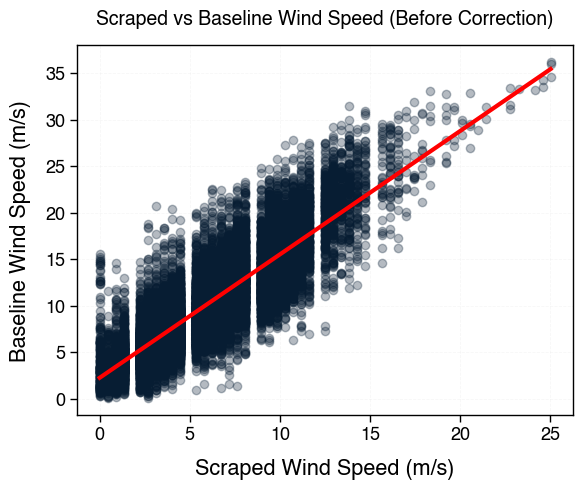

Correlation between scraped and baseline wind speed: 0.84


In [54]:
sns.regplot(
    data=ts_combined,
    x='wind_scraped_ms',
    y='wind_baseline_ms',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'},
)

plt.xlabel('Scraped Wind Speed (m/s)')
plt.ylabel('Baseline Wind Speed (m/s)')
plt.title('Scraped vs Baseline Wind Speed (Before Correction)')
plt.grid(True)
plt.show()

# Correlation between the two wind speed measurements
correlation = ts_combined['wind_scraped_ms'].corr(ts_combined['wind_baseline_ms'])
print(f"Correlation between scraped and baseline wind speed: {correlation:.2f}")


Since the scraped wind data consistently shows lower values over time compared to the baseline, this could be due to differences in measurement location, such as being recorded at a lower altitude or from a slightly different area in Orkney. Additionally, because the relationship between scraped and baseline wind speeds appears to be fairly linear and the correlation is quite high, we can justify applying a linear regression model to correct the scraped data.

In [55]:
## Drop rows with missing values for training
df_clean = ts_combined.dropna(subset=['wind_scraped_ms', 'wind_baseline_ms'])

## Fit linear regression
X = df_clean[['wind_scraped_ms']]
y = df_clean['wind_baseline_ms'].values

model = LinearRegression()
model.fit(X, y)

## Apply model to full dataset (including rows with NaNs in baseline)
ts_combined['wind_scraped_scaled_ms'] = np.nan  ## initialize with NaNs
mask = ts_combined['wind_scraped_ms'].notna()
ts_combined.loc[mask, 'wind_scraped_scaled_ms'] = model.predict(ts_combined.loc[mask, ['wind_scraped_ms']])

y_pred = model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

baseline_mask = ts_combined['wind_baseline_ms'].notna() & ts_combined['wind_scraped_ms'].notna()

print(f'Baseline Error Metrics:')
print(f"MAE: {mean_absolute_error(ts_combined.loc[baseline_mask, 'wind_baseline_ms'], ts_combined.loc[baseline_mask, 'wind_scraped_ms']):.2f} m/s")
print(f"MSE: {mean_squared_error(ts_combined.loc[baseline_mask, 'wind_baseline_ms'], ts_combined.loc[baseline_mask, 'wind_scraped_ms']):.2f} m²/s²")
print(f"RMSE: {root_mean_squared_error(ts_combined.loc[baseline_mask, 'wind_baseline_ms'], ts_combined.loc[baseline_mask, 'wind_scraped_ms']):.2f} m/s")
print(f"R² Score: {r2_score(ts_combined.loc[baseline_mask, 'wind_baseline_ms'], ts_combined.loc[baseline_mask, 'wind_scraped_ms']):.2f}")

print('')

print(f"Linear Regression Correction:")
print(f"MAE: {mae:.2f} m/s")
print(f"MSE: {mse:.2f} m²/s²")
print(f"RMSE: {rmse:.2f} m/s")
print(f"R² Score: {r2:.2f}")

ts_combined.head()

Baseline Error Metrics:
MAE: 4.33 m/s
MSE: 27.85 m²/s²
RMSE: 5.28 m/s
R² Score: 0.05

Linear Regression Correction:
MAE: 2.26 m/s
MSE: 8.55 m²/s²
RMSE: 2.92 m/s
R² Score: 0.71


turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-01-01 00:00:00        894.033333                900.0         13.820000   
2017-01-01 00:30:00        898.266667                900.0         16.106667   
2017-01-01 01:00:00        902.866667                900.0         16.380000   
2017-01-01 01:30:00        907.833333                900.0         17.083333   
2017-01-01 02:00:00        907.000000                900.0         16.800000   

                     turbine_power_zero_count  any_missing  missing_count  \
Timestamp                                                                   
2017-01-01 00:00:00                         0        False              0   
2017-01-01 00:30:00                         0        False              0   
2017-01-01 01:00:00                         0        False              0   
2017-01-01 01:30:00                         0        False              0   
2017-01-01 02:00:00                         0        False              0   

                     row_count  wind_scraped_ms  temperature_scraped_C  hour  \
Timestamp                                                                      
2017-01-01 00:00:00         30              NaN                    NaN     0   
2017-01-01 00:30:00         30            10.28                    5.0     0   
2017-01-01 01:00:00         30             9.39                    6.1     1   
2017-01-01 01:30:00         30             9.83                    5.0     1   
2017-01-01 02:00:00          1             7.15                    3.9     2   

                     month  season  year        date  wind_scraped_scaled_ms  
Timestamp                                                                     
2017-01-01 00:00:00      1  Winter  2017  2017-01-01                     NaN  
2017-01-01 00:30:00      1  Winter  2017  2017-01-01               15.884584  
2017-01-01 01:00:00      1  Winter  2017  2017-01-01               14.704483  
2017-01-01 01:30:00      1  Winter  2017  2017-01-01               15.287904  
2017-01-01 02:00:00      1  Winter  2017  2017-01-01               11.734339

The R² score increased from 0.05 to 0.71, which means the linear regression model explains 71% of the variance in the corrected wind speed values. The RMSE also dropped significantly, from 5.26 m/s to 2.92 m/s, indicating that the model provides much more accurate predictions.

We use linear regression in this case because it’s a simple and effective method for correcting systematic bias or scaling issues in sensor data. By fitting a straight line between the predicted and actual values, we can adjust the raw measurements to better reflect reality. This approach is especially useful when the relationship between the two variables is approximately linear, as it appears to be in this case.

---

#### 2.1.7.4 Filling Missing Values

In [56]:
missing_wind_mask = ts_combined['wind_baseline_ms'].isna()

ts_combined[missing_wind_mask].tail(10)

ts_combined['wind_final_ms'] = ts_combined['wind_baseline_ms']
mask = ts_combined['wind_baseline_ms'].isna()

# Fill missing with corrected scraped wind
ts_combined.loc[mask, 'wind_final_ms'] = ts_combined.loc[mask, 'wind_scraped_scaled_ms']

# Track data source
ts_combined['wind_data_source'] = 'baseline'
ts_combined.loc[mask, 'wind_data_source'] = 'scraped'


ts_combined.head()


turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-01-01 00:00:00        894.033333                900.0         13.820000   
2017-01-01 00:30:00        898.266667                900.0         16.106667   
2017-01-01 01:00:00        902.866667                900.0         16.380000   
2017-01-01 01:30:00        907.833333                900.0         17.083333   
2017-01-01 02:00:00        907.000000                900.0         16.800000   

                     turbine_power_zero_count  any_missing  missing_count  \
Timestamp                                                                   
2017-01-01 00:00:00                         0        False              0   
2017-01-01 00:30:00                         0        False              0   
2017-01-01 01:00:00                         0        False              0   
2017-01-01 01:30:00                         0        False              0   
2017-01-01 02:00:00                         0        False              0   

                     row_count  wind_scraped_ms  temperature_scraped_C  hour  \
Timestamp                                                                      
2017-01-01 00:00:00         30              NaN                    NaN     0   
2017-01-01 00:30:00         30            10.28                    5.0     0   
2017-01-01 01:00:00         30             9.39                    6.1     1   
2017-01-01 01:30:00         30             9.83                    5.0     1   
2017-01-01 02:00:00          1             7.15                    3.9     2   

                     month  season  year        date  wind_scraped_scaled_ms  \
Timestamp                                                                      
2017-01-01 00:00:00      1  Winter  2017  2017-01-01                     NaN   
2017-01-01 00:30:00      1  Winter  2017  2017-01-01               15.884584   
2017-01-01 01:00:00      1  Winter  2017  2017-01-01               14.704483   
2017-01-01 01:30:00      1  Winter  2017  2017-01-01               15.287904   
2017-01-01 02:00:00      1  Winter  2017  2017-01-01               11.734339   

                     wind_final_ms wind_data_source  
Timestamp                                            
2017-01-01 00:00:00      13.820000         baseline  
2017-01-01 00:30:00      16.106667         baseline  
2017-01-01 01:00:00      16.380000         baseline  
2017-01-01 01:30:00      17.083333         baseline  
2017-01-01 02:00:00      16.800000         baseline

### 2.1.8 Post-Cleaning Null Check

In [57]:
ts_combined.isna().sum()

turbine_power_kw            1012
turbine_setpoint_kw         1012
wind_baseline_ms            1012
turbine_power_zero_count       0
any_missing                    0
missing_count                  0
row_count                      0
wind_scraped_ms              987
temperature_scraped_C        987
hour                           0
month                          0
season                         0
year                           0
date                           0
wind_scraped_scaled_ms       987
wind_final_ms                 65
wind_data_source               0
dtype: int64

In [58]:
# Find where turbine_power_kw is NaN
post_clean_nan_mask = ts_combined['turbine_power_kw'].isna()

nan_streak = (post_clean_nan_mask != post_clean_nan_mask.shift()).cumsum()
nan_groups = ts_combined[post_clean_nan_mask].groupby(nan_streak)

# Collect start time, end time, and number of periods for each group
results = []
for _, group_df in nan_groups:
    start = group_df.index[0]
    end = group_df.index[-1]
    length = len(group_df)
    results.append({"start_time": start, "end_time": end, "periods": length})

# Create summary DataFrame
summary = pd.DataFrame(results)

summary


start_time            end_time  periods
0 2017-04-03 15:30:00 2017-04-24 02:30:00      983
1 2017-05-17 02:30:00 2017-05-17 08:00:00       12
2 2017-11-09 02:30:00 2017-11-09 03:00:00        2
3 2017-12-13 22:30:00 2017-12-14 05:00:00       14
4 2017-12-15 13:00:00 2017-12-15 13:00:00        1

This dataset after being preprocessed and resampled to 30 minute contains several periods where the turbine telemetry data (`turbine_power_kw`) is missing. Specifically, there are five distinct time intervals with missing values, the longest of which spans over 20 days in April.

These missing values occur in the column used to measure actual turbine output. Since curtailment is calculated as the difference between the theoretical maximum power (from the power curve) and the actual turbine power, these missing values prevent us from accurately computing curtailment during those periods.

The recommended approach is to drop these rows from curtailment calculations. This avoids introducing bias or false assumptions about turbine behavior during missing periods. If we attempted to estimate the missing values using the wind speed and the power curve, we would be assuming that the turbine was operating normally and not curtailed. However, if the turbine was actually curtailed or offline, this assumption would severely underestimate curtailment.

The caveat is that by dropping these periods, we lose potentially significant curtailment events. For example, during April—where the longest missing period occurs—there may have been substantial curtailment that cannot be quantified. This should be transparently reported. Instead of silently discarding the data, we should flag these gaps as periods of unknown curtailment.

In [59]:
# drop rows of ts_combined in post_clean_nan_mask
ts_combined = ts_combined[~post_clean_nan_mask]

ts_combined.isna().sum()


turbine_power_kw              0
turbine_setpoint_kw           0
wind_baseline_ms              0
turbine_power_zero_count      0
any_missing                   0
missing_count                 0
row_count                     0
wind_scraped_ms             922
temperature_scraped_C       922
hour                          0
month                         0
season                        0
year                          0
date                          0
wind_scraped_scaled_ms      922
wind_final_ms                 0
wind_data_source              0
dtype: int64

In [131]:
ts_combined.groupby('date')['turbine_energy_kwh'].sum().mean()

np.float64(9845.208665895954)

## 2.2 Theoretical Power Calculation

We have derived the power curve in the previous section now we can fill the maximum power that can be generated for each 30 minute interval

In [60]:
ts_combined['turbine_power_max_kw'] = delayed_weibull(
    ts_combined['wind_final_ms'],
    v0_fit,
    c_fit,
    pr=900
)

ts_combined.head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-01-01 00:00:00        894.033333                900.0         13.820000   
2017-01-01 00:30:00        898.266667                900.0         16.106667   
2017-01-01 01:00:00        902.866667                900.0         16.380000   
2017-01-01 01:30:00        907.833333                900.0         17.083333   
2017-01-01 02:00:00        907.000000                900.0         16.800000   

                     turbine_power_zero_count  any_missing  missing_count  \
Timestamp                                                                   
2017-01-01 00:00:00                         0        False              0   
2017-01-01 00:30:00                         0        False              0   
2017-01-01 01:00:00                         0        False              0   
2017-01-01 01:30:00                         0        False              0   
2017-01-01 02:00:00                         0        False              0   

                     row_count  wind_scraped_ms  temperature_scraped_C  hour  \
Timestamp                                                                      
2017-01-01 00:00:00         30              NaN                    NaN     0   
2017-01-01 00:30:00         30            10.28                    5.0     0   
2017-01-01 01:00:00         30             9.39                    6.1     1   
2017-01-01 01:30:00         30             9.83                    5.0     1   
2017-01-01 02:00:00          1             7.15                    3.9     2   

                     month  season  year        date  wind_scraped_scaled_ms  \
Timestamp                                                                      
2017-01-01 00:00:00      1  Winter  2017  2017-01-01                     NaN   
2017-01-01 00:30:00      1  Winter  2017  2017-01-01               15.884584   
2017-01-01 01:00:00      1  Winter  2017  2017-01-01               14.704483   
2017-01-01 01:30:00      1  Winter  2017  2017-01-01               15.287904   
2017-01-01 02:00:00      1  Winter  2017  2017-01-01               11.734339   

                     wind_final_ms wind_data_source  turbine_power_max_kw  
Timestamp                                                                  
2017-01-01 00:00:00      13.820000         baseline            863.247344  
2017-01-01 00:30:00      16.106667         baseline            896.715935  
2017-01-01 01:00:00      16.380000         baseline            897.688692  
2017-01-01 01:30:00      17.083333         baseline            899.124320  
2017-01-01 02:00:00      16.800000         baseline            898.690062

## 2.3 Curtailment

The **Active Network Management (ANM)** system in Orkney was introduced to help integrate more renewable energy into the local grid, which is limited in how much electricity it can export to the mainland. Because of this constraint, the ANM system automatically adjusts how much power each wind turbine can send to the grid based on real-time conditions.

The ANM system works by assigning a **power setpoint** to each turbine. This setpoint determines the maximum power the turbine is allowed to export at any given time:

* **0 kW** – the turbine is **fully curtailed** (no power export allowed)
* **Between 0 and 900 kW (or below installed capacity)** – the turbine is **marginally curtailed** (partially restricted)
* **900 kW or the installed capacity** – the turbine is **not curtailed** (can operate freely)

To detect curtailment in the data, we define it as any time the turbine's setpoint is **less than 900 kW**.

To calculate how much energy is being curtailed:

1. We estimate the **maximum possible output** of the turbine based on wind speed using a power curve model.
2. We subtract the **actual power output** from this theoretical maximum.
3. If the turbine was **not curtailed** (setpoint ≥ 900 kW), we set curtailment to **zero**.
4. Any **negative values** (e.g., if the turbine output was slightly higher than expected) are clipped to **zero** to avoid counting false curtailment.

This method allows us to estimate how much wind energy is lost due to grid constraints and ANM control. It gives us insight into the trade-offs between maximizing renewable energy use and maintaining grid stability on a limited-capacity island like Orkney.


In [61]:
ts_combined['curtailed_power_kw'] = (ts_combined['turbine_power_max_kw'] - ts_combined['turbine_power_kw']).where(ts_combined['turbine_setpoint_kw']<900,0).clip(lower=0)

ts_combined[ts_combined['curtailed_power_kw']>0].head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-01-02 11:00:00             448.2                840.0          9.686667   
2017-01-02 11:30:00             158.5                270.0         10.116667   
2017-01-05 08:30:00              33.0                330.0          5.993333   
2017-01-05 09:00:00               0.0                  0.0          6.843333   
2017-01-05 09:30:00               0.0                  0.0          9.066667   

                     turbine_power_zero_count  any_missing  missing_count  \
Timestamp                                                                   
2017-01-02 11:00:00                         1        False              0   
2017-01-02 11:30:00                        20        False              0   
2017-01-05 08:30:00                        18        False              0   
2017-01-05 09:00:00                        30        False              0   
2017-01-05 09:30:00                        30        False              0   

                     row_count  wind_scraped_ms  temperature_scraped_C  hour  \
Timestamp                                                                      
2017-01-02 11:00:00         30             3.58                    5.0    11   
2017-01-02 11:30:00         30             4.47                    6.1    11   
2017-01-05 08:30:00         30             3.58                    3.9     8   
2017-01-05 09:00:00         30             2.68                    3.9     9   
2017-01-05 09:30:00         30             3.13                    3.9     9   

                     month  season  year        date  wind_scraped_scaled_ms  \
Timestamp                                                                      
2017-01-02 11:00:00      1  Winter  2017  2017-01-02                7.000672   
2017-01-02 11:30:00      1  Winter  2017  2017-01-02                8.180773   
2017-01-05 08:30:00      1  Winter  2017  2017-01-05                7.000672   
2017-01-05 09:00:00      1  Winter  2017  2017-01-05                5.807310   
2017-01-05 09:30:00      1  Winter  2017  2017-01-05                6.403991   

                     wind_final_ms wind_data_source  turbine_power_max_kw  \
Timestamp                                                                   
2017-01-02 11:00:00       9.686667         baseline            491.133744   
2017-01-02 11:30:00      10.116667         baseline            550.056693   
2017-01-05 08:30:00       5.993333         baseline             70.285016   
2017-01-05 09:00:00       6.843333         baseline            135.322381   
2017-01-05 09:30:00       9.066667         baseline            404.193687   

                     curtailed_power_kw  
Timestamp                                
2017-01-02 11:00:00           42.933744  
2017-01-02 11:30:00          391.556693  
2017-01-05 08:30:00           37.285016  
2017-01-05 09:00:00          135.322381  
2017-01-05 09:30:00          404.193687

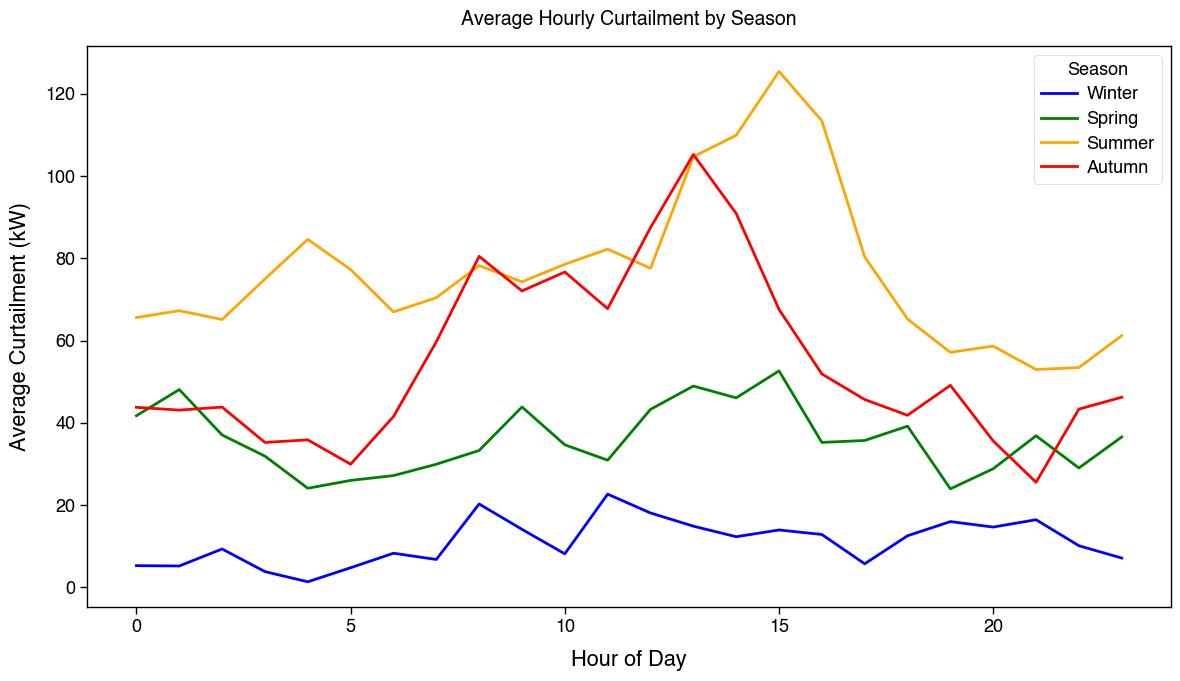

In [62]:
# hourly average curtailment per season
hourly_seasonal_curtailment = ts_combined.groupby(['season', 'hour'])['curtailed_power_kw'].mean().reset_index()

#plot into line chart
plt.figure(figsize=(12, 7))
plt.plot(
    hourly_seasonal_curtailment[hourly_seasonal_curtailment['season'] == 'Winter']['hour'],
    hourly_seasonal_curtailment[hourly_seasonal_curtailment['season'] == 'Winter']['curtailed_power_kw'],
    label='Winter',
    color='blue'
)
plt.plot(
    hourly_seasonal_curtailment[hourly_seasonal_curtailment['season'] == 'Spring']['hour'],
    hourly_seasonal_curtailment[hourly_seasonal_curtailment['season'] == 'Spring']['curtailed_power_kw'],
    label='Spring',
    color='green'
)
plt.plot(
    hourly_seasonal_curtailment[hourly_seasonal_curtailment['season'] == 'Summer']['hour'],
    hourly_seasonal_curtailment[hourly_seasonal_curtailment['season'] == 'Summer']['curtailed_power_kw'],
    label='Summer',
    color='orange'
)
plt.plot(
    hourly_seasonal_curtailment[hourly_seasonal_curtailment['season'] == 'Autumn']['hour'],
    hourly_seasonal_curtailment[hourly_seasonal_curtailment['season'] == 'Autumn']['curtailed_power_kw'],
    label='Autumn',
    color='red'
)
plt.title('Average Hourly Curtailment by Season')
plt.xlabel('Hour of Day')
plt.ylabel('Average Curtailment (kW)')
plt.legend(title='Season')
plt.grid()
plt.tight_layout()
plt.show()

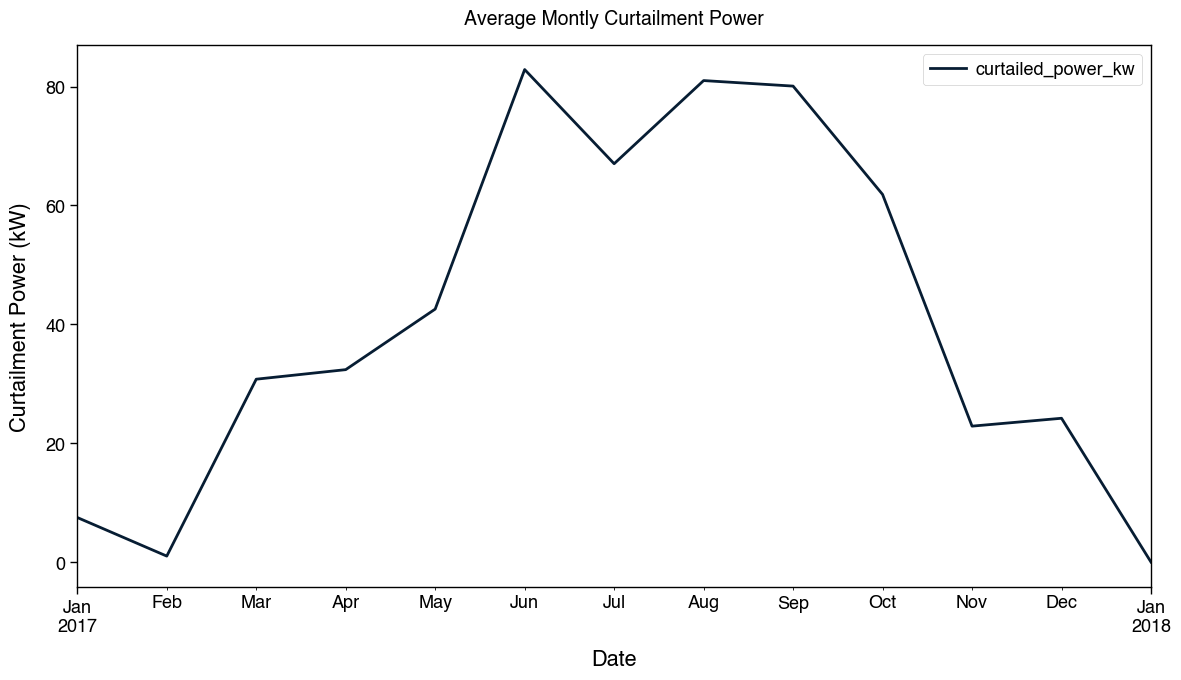

In [63]:
curtailed_month = ts_combined.resample('MS').agg({
    'curtailed_power_kw': 'mean',
    'turbine_power_kw': 'mean',
    'turbine_power_max_kw': 'mean',
    'turbine_setpoint_kw': 'mean',
})
# plot curtailed power in a line plot

curtailed_month.plot(y='curtailed_power_kw',use_index=True, figsize=(12,7))
plt.title('Average Montly Curtailment Power')
plt.xlabel('Date')
plt.ylabel('Curtailment Power (kW)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


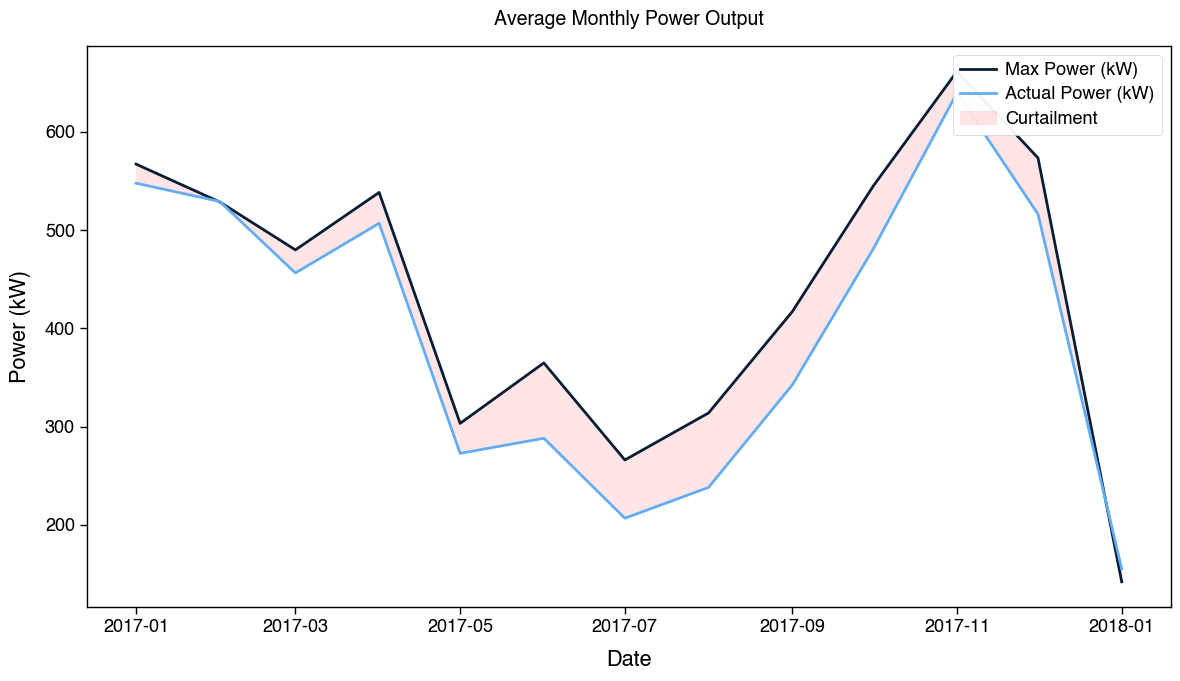

In [64]:
plt.figure(figsize=(12, 7))

plt.plot(curtailed_month.index, curtailed_month['turbine_power_max_kw'], label='Max Power (kW)')
plt.plot(curtailed_month.index, curtailed_month['turbine_power_kw'], label='Actual Power (kW)')
#shade the area between the two lines as curtailment
plt.fill_between(
    curtailed_month.index,
    curtailed_month['turbine_power_max_kw'],
    curtailed_month['turbine_power_kw'],
    color='red',
    alpha=0.1,
    label='Curtailment'
)
plt.title('Average Monthly Power Output')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

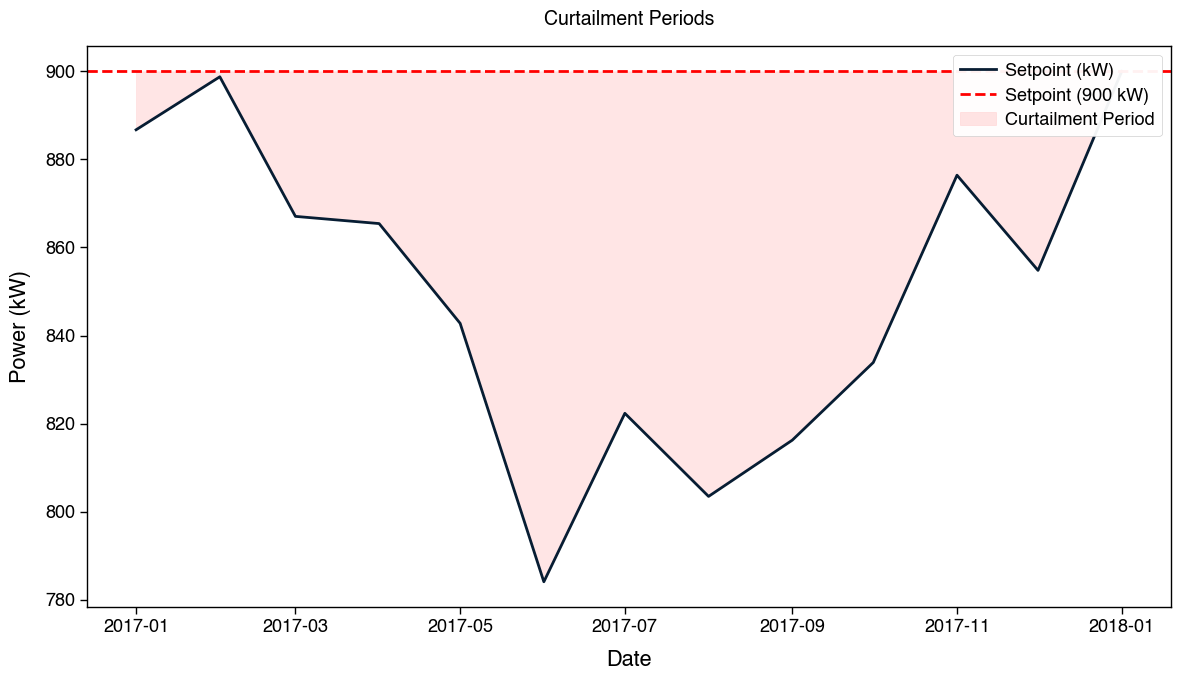

In [65]:
plt.figure(figsize=(12, 7))


plt.plot(curtailed_month.index, curtailed_month['turbine_setpoint_kw'], label='Setpoint (kW)')
# plt.plot(curtailed_month.index, curtailed_month['curtailed_power_kw'], label='Curtailment (kW)', color='red')
#shade the area between the two lines as curtailment
plt.axhline(y=900, color='red', linestyle='--', label='Setpoint (900 kW)')
plt.fill_between(
    curtailed_month.index,
    900,
    curtailed_month['turbine_setpoint_kw'],
    color='red',
    alpha=0.1,
    label='Curtailment Period'
)
plt.title('Curtailment Periods')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [66]:
pd.DataFrame([{
    'Average Curtailment Power (kW)': ts_combined['curtailed_power_kw'].mean(),
    'Standard Deviation Curtailment Power (kW)': ts_combined['curtailed_power_kw'].std(),
    'Max Curtailment Power (kW)': ts_combined['curtailed_power_kw'].max(),
    'Min Curtailment Power (kW)': ts_combined['curtailed_power_kw'].min(),
    'Average Maximum Power (kW)': ts_combined['turbine_power_max_kw'].mean(),
}]).T.rename(columns={0: 'Value'})

Value
Average Curtailment Power (kW)              45.385001
Standard Deviation Curtailment Power (kW)  168.431738
Max Curtailment Power (kW)                 900.000000
Min Curtailment Power (kW)                   0.000000
Average Maximum Power (kW)                 456.894360

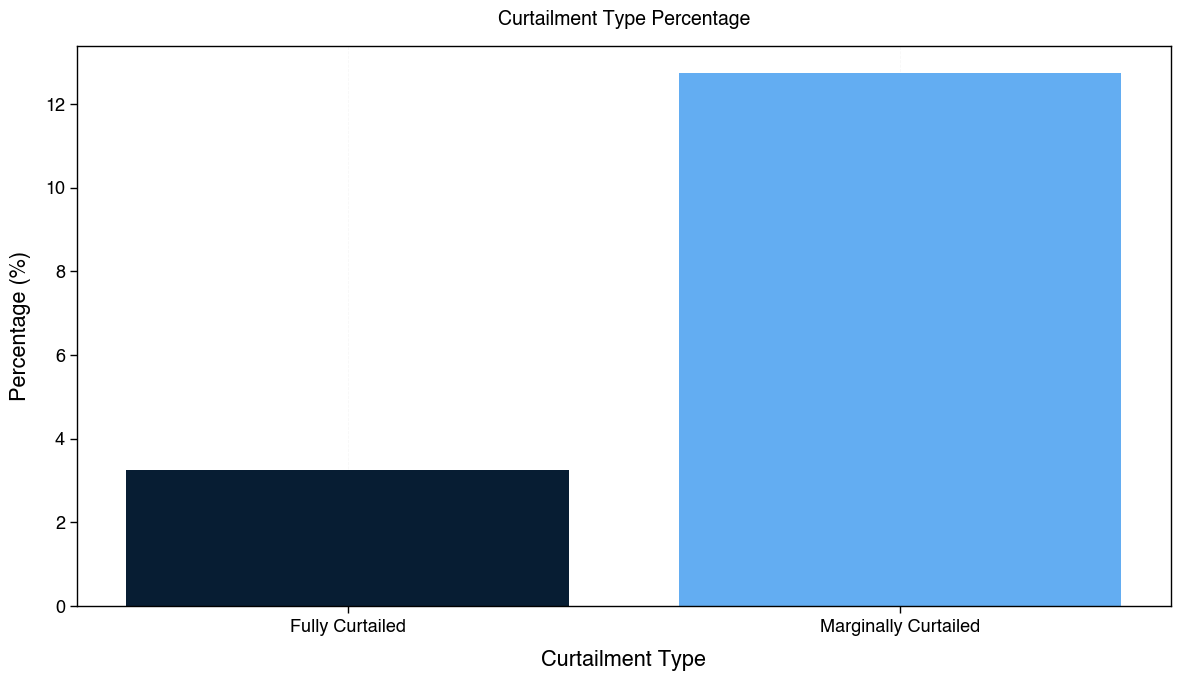

In [67]:
fully_curtailed = ts_combined[ts_combined['turbine_setpoint_kw'] == 0].shape[0]
marginally_curtailed = ts_combined[ts_combined['turbine_setpoint_kw'] < 900].shape[0]
total_data = ts_combined.shape[0]

curtailment_summary = pd.DataFrame({
    'Curtailment Type': ['Fully Curtailed', 'Marginally Curtailed'],
    'Count': [fully_curtailed, marginally_curtailed],
    'Percentage': [
        (fully_curtailed / total_data) * 100,
        (marginally_curtailed / total_data) * 100
    ]
})

#plot the curtailment summary
plt.figure(figsize=(12, 7))
plt.bar(
    curtailment_summary['Curtailment Type'],
    curtailment_summary['Percentage'],
    color=custom_colors[:len(curtailment_summary)]  # Slice to match number of bars
)
plt.title('Curtailment Type Percentage')
plt.xlabel('Curtailment Type')
plt.ylabel('Percentage (%)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



### 2.3.1 Curtailment Proportion

The **curtailment proportion** is a measure of how efficiently a wind turbine is operating relative to its maximum possible capacity. It is calculated by dividing the **average power output** by the **potential maximum capacity** of the turbine. This metric provides insight into the turbine's curtailment ration over time.


$$
\text{Curtailment Factor} = \frac{\text{Power Output}}{\text{Potential Maximum Capacity}}
$$


In [68]:
curtailment_factor = ts_combined['curtailed_power_kw'].sum()/ts_combined['turbine_power_kw'].sum()

print(f'Turbine Curtailment Proportion: {curtailment_factor:.2%}')


Turbine Curtailment Proportion: 11.03%


In [69]:
# Turbine load factor
load_factor = ts_combined['turbine_power_kw'].mean() / 900

print(f"Turbine Load Factor: {load_factor:.2%}")

Turbine Load Factor: 45.72%


## 2.4 Energy Calculation

In [70]:
ts_combined['turbine_energy_kwh'] = ts_combined['turbine_power_kw'] * 0.5
ts_combined['turbine_energy_max_kwh'] = ts_combined['turbine_power_max_kw'] * 0.5
ts_combined['curtailed_energy_kwh'] = ts_combined['curtailed_power_kw'] * 0.5

ts_combined = ts_combined.round(decimals=4)
ts_combined.head()

turbine_power_kw  turbine_setpoint_kw  wind_baseline_ms  \
Timestamp                                                                      
2017-01-01 00:00:00          894.0333                900.0           13.8200   
2017-01-01 00:30:00          898.2667                900.0           16.1067   
2017-01-01 01:00:00          902.8667                900.0           16.3800   
2017-01-01 01:30:00          907.8333                900.0           17.0833   
2017-01-01 02:00:00          907.0000                900.0           16.8000   

                     turbine_power_zero_count  any_missing  missing_count  \
Timestamp                                                                   
2017-01-01 00:00:00                         0        False              0   
2017-01-01 00:30:00                         0        False              0   
2017-01-01 01:00:00                         0        False              0   
2017-01-01 01:30:00                         0        False              0   
2017-01-01 02:00:00                         0        False              0   

                     row_count  wind_scraped_ms  temperature_scraped_C  hour  \
Timestamp                                                                      
2017-01-01 00:00:00         30              NaN                    NaN     0   
2017-01-01 00:30:00         30            10.28                    5.0     0   
2017-01-01 01:00:00         30             9.39                    6.1     1   
2017-01-01 01:30:00         30             9.83                    5.0     1   
2017-01-01 02:00:00          1             7.15                    3.9     2   

                     ...  year        date  wind_scraped_scaled_ms  \
Timestamp            ...                                             
2017-01-01 00:00:00  ...  2017  2017-01-01                     NaN   
2017-01-01 00:30:00  ...  2017  2017-01-01                 15.8846   
2017-01-01 01:00:00  ...  2017  2017-01-01                 14.7045   
2017-01-01 01:30:00  ...  2017  2017-01-01                 15.2879   
2017-01-01 02:00:00  ...  2017  2017-01-01                 11.7343   

                    wind_final_ms  wind_data_source  turbine_power_max_kw  \
Timestamp                                                                   
2017-01-01 00:00:00       13.8200          baseline              863.2473   
2017-01-01 00:30:00       16.1067          baseline              896.7159   
2017-01-01 01:00:00       16.3800          baseline              897.6887   
2017-01-01 01:30:00       17.0833          baseline              899.1243   
2017-01-01 02:00:00       16.8000          baseline              898.6901   

                    curtailed_power_kw  turbine_energy_kwh  \
Timestamp                                                    
2017-01-01 00:00:00                0.0            447.0167   
2017-01-01 00:30:00                0.0            449.1333   
2017-01-01 01:00:00                0.0            451.4333   
2017-01-01 01:30:00                0.0            453.9167   
2017-01-01 02:00:00                0.0            453.5000   

                     turbine_energy_max_kwh  curtailed_energy_kwh  
Timestamp                                                          
2017-01-01 00:00:00                431.6237                   0.0  
2017-01-01 00:30:00                448.3580                   0.0  
2017-01-01 01:00:00                448.8443                   0.0  
2017-01-01 01:30:00                449.5622                   0.0  
2017-01-01 02:00:00                449.3450                   0.0  

[5 rows x 22 columns]

Total curtailed energy (kWh): 0.38 GWh


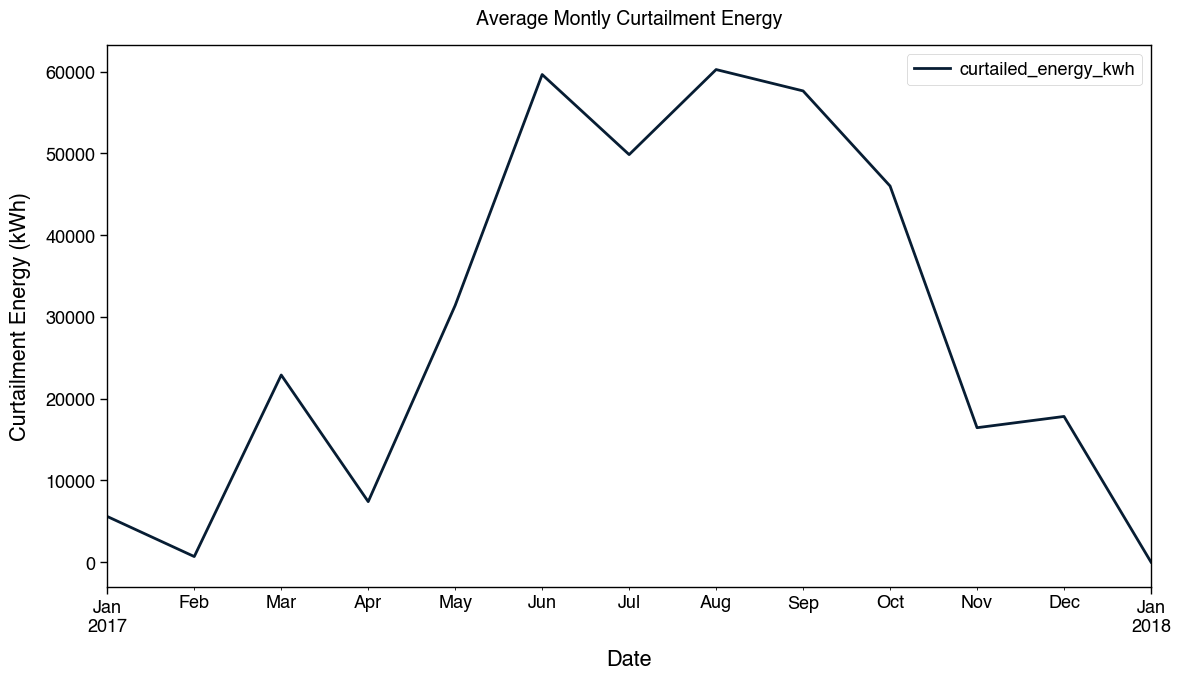

In [71]:
curtailed_energy_month = ts_combined.resample('ME').agg({
    'curtailed_energy_kwh': 'sum',
    'turbine_energy_kwh': 'sum',
    'turbine_energy_max_kwh': 'sum',
    'season': 'first',
    'month': 'first'
})

print(f"Total curtailed energy (kWh): {(curtailed_energy_month['curtailed_energy_kwh'].sum()/10**6):,.2f} GWh")
curtailed_energy_month.plot(y=['curtailed_energy_kwh'], use_index=True, figsize=(12,7))
plt.title('Average Montly Curtailment Energy')
plt.xlabel('Date')
plt.ylabel('Curtailment Energy (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

curtailed_energy_kwh  turbine_energy_kwh  turbine_energy_max_kwh  \
season                                                                     
Autumn           120121.3491        1.064345e+06            1.181302e+06   
Spring            61702.4772        6.566614e+05            7.038371e+05   
Summer           169798.5456        5.383733e+05            6.940989e+05   
Winter            24074.6708        1.147063e+06            1.202934e+06   

        curtailment_over_power_prop  curtailment_prop  
season                                                 
Autumn                     0.101686          0.319729  
Spring                     0.087666          0.164235  
Summer                     0.244632          0.451956  
Winter                     0.020013          0.064080

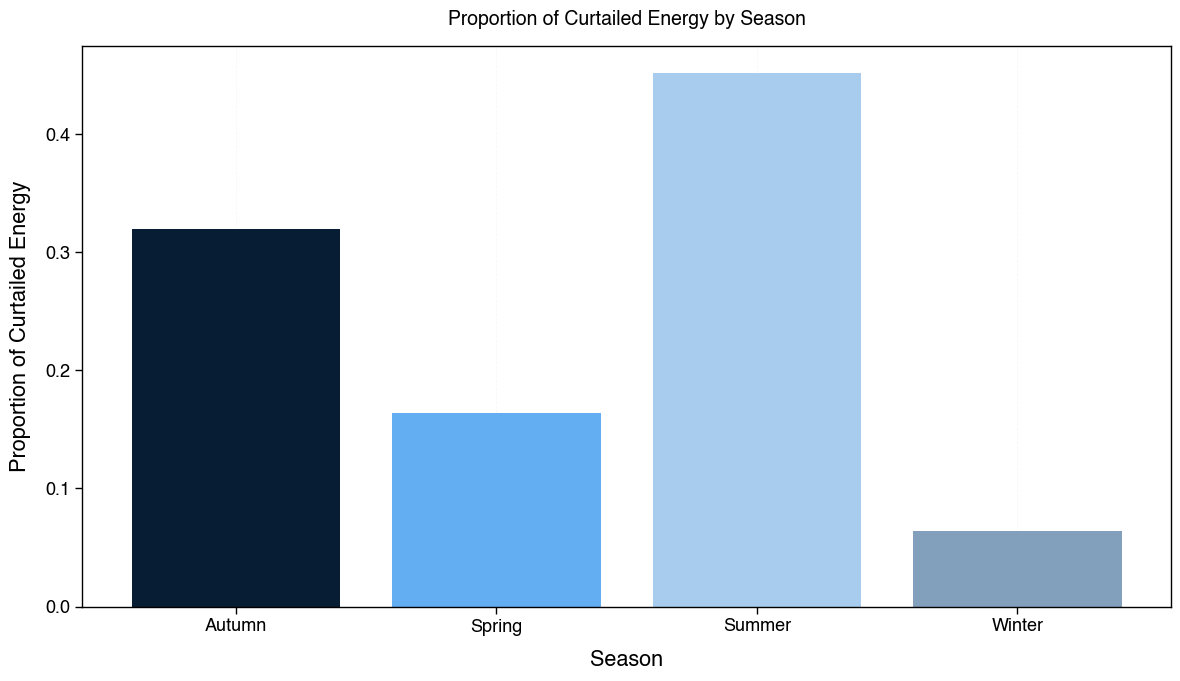

In [72]:
# Proportion of curtailed energy by season
seasonal_curtailment = curtailed_energy_month.groupby('season').agg({
    'curtailed_energy_kwh': 'sum',
    'turbine_energy_kwh': 'sum',
    'turbine_energy_max_kwh': 'sum'
})
seasonal_curtailment['curtailment_over_power_prop'] = seasonal_curtailment['curtailed_energy_kwh'] / seasonal_curtailment['turbine_energy_max_kwh']
seasonal_curtailment['curtailment_prop'] = seasonal_curtailment['curtailed_energy_kwh'] / seasonal_curtailment['curtailed_energy_kwh'].sum()
display(seasonal_curtailment)

#plot seasonal curtailment
plt.figure(figsize=(12, 7))
plt.bar(seasonal_curtailment.index, seasonal_curtailment['curtailment_prop'], color=custom_colors[:len(seasonal_curtailment)])
plt.title('Proportion of Curtailed Energy by Season')
plt.xlabel('Season')
plt.ylabel('Proportion of Curtailed Energy')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [73]:
ts_combined.groupby('season')['temperature_scraped_C'].agg(['mean','std','min','max']).round(2)

mean   std   min   max
season                         
Autumn   9.71  3.31   2.2  20.0
Spring   7.82  4.17 -17.8  21.1
Summer  13.13  2.15   6.1  20.0
Winter   5.87  2.77  -2.8  12.8

In [74]:
curtailed_percentage = ((curtailed_energy_month['curtailed_energy_kwh'].sum()/10**6)/(curtailed_energy_month['turbine_energy_kwh'].sum()/10**6))*100

print(f"Total curtailed energy (kWh): {(curtailed_energy_month['curtailed_energy_kwh'].sum()/10**6):,.2f} GWh")
print(f"Total energy produced (kWh): {(curtailed_energy_month['turbine_energy_kwh'].sum()/10**6):,.2f} GWh")
print(f"Total curtailed energy percentage: {curtailed_percentage:.2f}%")

Total curtailed energy (kWh): 0.38 GWh
Total energy produced (kWh): 3.41 GWh
Total curtailed energy percentage: 11.03%


## 2.5 Scale to 500 Turbine

| Location                                | ANM Zone | Commissioned | IC (kW) |
|-----------------------------------------|----------|--------------|---------|
| Thorfinn Wind Farm                      | 1a       | 01/04/2000   | 2,700   |
| Thorfinn Wind Energy Project (NM1500)   | 1a       | 01/04/2000   | 1,500   |
| Burgar Hill                             | 1a       | 01/11/2000   | 1,300   |
| Northfield Wind Energy Project Burray- A,C | 4a   | 01/02/2005   | 850     |
| Burgar Hill Wind Farm - A               | 1a       | 01/12/2006   | 5,000   |
| Birsay Energy                           | 1a       | 01/09/2009   | 900     |
| Gallow Hill, Westray                    | 1        | 11/09/2009   | 900     |
| Burgar Hill Renewables 1               | 1a       | 01/10/2009   | 2,300   |
| Flotta Wind Farm                        | 3        | 18/06/2010   | 2,000   |
| Hammars Hill                            | 1        | 23/08/2010   | 4,500   |
| Trumland Farm, Rousay                   | 1        | 18/02/2011   | 80      |
| Ore Brae Wind Farm                      | 3        | 21/09/2011   | 900     |
| Kingarly Hill Wind Turbine             | 1        | 22/09/2011   | 900     |
| Hatston Wind Turbine                   | Core     | 05/10/2011   | 900     |
| Braefoot Wind Farm                      | 2        | 21/10/2011   | 900     |
| Rothiesholm Head Wind Farm             | 2a       | 17/11/2011   | 900     |
| Thorkell Deerness                       | 4a       | 09/03/2012   | 910     |
| Cleat, Work Road, St. Ola              | Core     | 17/09/2012   | 83      |
| Spurness Wind Farm II                   | 2b       | 22/10/2012   | 10,000  |
| Fea, Holm                               | 4        | 06/11/2012   | 83      |
| Banks (Land Near), Rousay              | 1        | 26/11/2012   | 80      |
| Sandybanks, Eday                        | 1        | 27/11/2012   | 910     |
| Wasbister, South Ronaldsay             | 4a       | 28/11/2012   | 55      |
| Dalespot Hill                           | Core     | 29/01/2013   | 80      |
| Hammer, Skelwick, Westray              | 1        | 27/02/2013   | 500     |
| Barns of Ayre                           | 4        | 03/07/2013   | 2,730   |
| Scapa, St Ola                           | Core     | 26/09/2013   | 83      |
| Mount Pleasant, Haybrake Road South Ronaldsay | 4a | 08/10/2013   | 65      |
| Blackawall Cottage, Flotta             | 3        | 16/10/2013   | 83      |
| DG Westray                              | 1        | 17/10/2013   | 500     |
| Towerhill, St Ola                       | Core     | 03/03/2014   | 83.3    |
| East Hammer, Westray                   | 1        | 24/03/2014   | 55      |
| Rennibister, Firth                      | Core     | 28/03/2014   | 910     |
| New Holland, Holm                       | 4        | 20/11/2014   | 500     |
| Ludenhill Farm (Land Near)             | 1a       | 27/09/2016   | 500     |

Data on planning permissions granted by OIC16 show a total capacity of 6031.6kW for small turbines (under 50kW). The majority of these turbines are between 5 and 20kW as shown in (Figure 2.4).

[Orkney Energy Audit 2014](https://www.oref.co.uk/wp-content/uploads/2015/05/Orkney-wide-energy-audit-2014-Energy-Sources-and-Uses.pdf)

In [75]:
large_scale_turbines_table = '''
| Location                                | ANM Zone | Commissioned | IC (kW) |
|-----------------------------------------|----------|--------------|---------|
| Thorfinn Wind Farm                      | 1a       | 01/04/2000   | 2,700   |
| Thorfinn Wind Energy Project (NM1500)   | 1a       | 01/04/2000   | 1,500   |
| Burgar Hill                             | 1a       | 01/11/2000   | 1,300   |
| Northfield Wind Energy Project Burray- A,C | 4a   | 01/02/2005   | 850     |
| Burgar Hill Wind Farm - A               | 1a       | 01/12/2006   | 5,000   |
| Birsay Energy                           | 1a       | 01/09/2009   | 900     |
| Gallow Hill, Westray                    | 1        | 11/09/2009   | 900     |
| Burgar Hill Renewables 1               | 1a       | 01/10/2009   | 2,300   |
| Flotta Wind Farm                        | 3        | 18/06/2010   | 2,000   |
| Hammars Hill                            | 1        | 23/08/2010   | 4,500   |
| Trumland Farm, Rousay                   | 1        | 18/02/2011   | 80      |
| Ore Brae Wind Farm                      | 3        | 21/09/2011   | 900     |
| Kingarly Hill Wind Turbine             | 1        | 22/09/2011   | 900     |
| Hatston Wind Turbine                   | Core     | 05/10/2011   | 900     |
| Braefoot Wind Farm                      | 2        | 21/10/2011   | 900     |
| Rothiesholm Head Wind Farm             | 2a       | 17/11/2011   | 900     |
| Thorkell Deerness                       | 4a       | 09/03/2012   | 910     |
| Cleat, Work Road, St. Ola              | Core     | 17/09/2012   | 83      |
| Spurness Wind Farm II                   | 2b       | 22/10/2012   | 10,000  |
| Fea, Holm                               | 4        | 06/11/2012   | 83      |
| Banks (Land Near), Rousay              | 1        | 26/11/2012   | 80      |
| Sandybanks, Eday                        | 1        | 27/11/2012   | 910     |
| Wasbister, South Ronaldsay             | 4a       | 28/11/2012   | 55      |
| Dalespot Hill                           | Core     | 29/01/2013   | 80      |
| Hammer, Skelwick, Westray              | 1        | 27/02/2013   | 500     |
| Barns of Ayre                           | 4        | 03/07/2013   | 2,730   |
| Scapa, St Ola                           | Core     | 26/09/2013   | 83      |
| Mount Pleasant, Haybrake Road South Ronaldsay | 4a | 08/10/2013   | 65      |
| Blackawall Cottage, Flotta             | 3        | 16/10/2013   | 83      |
| DG Westray                              | 1        | 17/10/2013   | 500     |
| Towerhill, St Ola                       | Core     | 03/03/2014   | 83.3    |
| East Hammer, Westray                   | 1        | 24/03/2014   | 55      |
| Rennibister, Firth                      | Core     | 28/03/2014   | 910     |
| New Holland, Holm                       | 4        | 20/11/2014   | 500     |
| Ludenhill Farm (Land Near)             | 1a       | 27/09/2016   | 500     |
'''

small_scale_turbines_capacity = 4720.3 # kW

cleaned_table = '\n'.join([line for line in large_scale_turbines_table.split('\n') if not set(line.strip()) <= set('-| ')])

# Read again after removing the invalid separator line
df_large_scale_turbine = pd.read_csv(StringIO(cleaned_table), sep='|', skipinitialspace=True)

# Drop unnamed columns and clean up
df_large_scale_turbine = df_large_scale_turbine.loc[:, ~df_large_scale_turbine.columns.str.contains('^Unnamed')]

df_large_scale_turbine.columns = df_large_scale_turbine.columns.str.strip()

# Remove commas from numeric column and convert to float
df_large_scale_turbine["IC (kW)"] = df_large_scale_turbine["IC (kW)"].str.replace(',', '').astype(float)

reference_index = 11 # we are assuming Ore Brae Wind Farm is the reference turbine

df_large_scale_turbine['relative_position'] = df_large_scale_turbine.index - reference_index

df_large_scale_turbine


Location   ANM Zone   Commissioned  \
0         Thorfinn Wind Farm                        1a         01/04/2000      
1         Thorfinn Wind Energy Project (NM1500)     1a         01/04/2000      
2         Burgar Hill                               1a         01/11/2000      
3      Northfield Wind Energy Project Burray- A,C       4a     01/02/2005      
4         Burgar Hill Wind Farm - A                 1a         01/12/2006      
5         Birsay Energy                             1a         01/09/2009      
6         Gallow Hill, Westray                      1          11/09/2009      
7          Burgar Hill Renewables 1                 1a         01/10/2009      
8         Flotta Wind Farm                          3          18/06/2010      
9         Hammars Hill                              1          23/08/2010      
10        Trumland Farm, Rousay                     1          18/02/2011      
11        Ore Brae Wind Farm                        3          21/09/2011      
12         Kingarly Hill Wind Turbine               1          22/09/2011      
13         Hatston Wind Turbine                     Core       05/10/2011      
14        Braefoot Wind Farm                        2          21/10/2011      
15         Rothiesholm Head Wind Farm               2a         17/11/2011      
16        Thorkell Deerness                         4a         09/03/2012      
17         Cleat, Work Road, St. Ola                Core       17/09/2012      
18        Spurness Wind Farm II                     2b         22/10/2012      
19        Fea, Holm                                 4          06/11/2012      
20         Banks (Land Near), Rousay                1          26/11/2012      
21        Sandybanks, Eday                          1          27/11/2012      
22         Wasbister, South Ronaldsay               4a         28/11/2012      
23        Dalespot Hill                             Core       29/01/2013      
24         Hammer, Skelwick, Westray                1          27/02/2013      
25        Barns of Ayre                             4          03/07/2013      
26        Scapa, St Ola                             Core       26/09/2013      
27  Mount Pleasant, Haybrake Road South Ronaldsay         4a   08/10/2013      
28         Blackawall Cottage, Flotta               3          16/10/2013      
29        DG Westray                                1          17/10/2013      
30        Towerhill, St Ola                         Core       03/03/2014      
31         East Hammer, Westray                     1          24/03/2014      
32        Rennibister, Firth                        Core       28/03/2014      
33        New Holland, Holm                         4          20/11/2014      
34         Ludenhill Farm (Land Near)               1a         27/09/2016      

    IC (kW)  relative_position  
0    2700.0                -11  
1    1500.0                -10  
2    1300.0                 -9  
3     850.0                 -8  
4    5000.0                 -7  
5     900.0                 -6  
6     900.0                 -5  
7    2300.0                 -4  
8    2000.0                 -3  
9    4500.0                 -2  
10     80.0                 -1  
11    900.0                  0  
12    900.0                  1  
13    900.0                  2  
14    900.0                  3  
15    900.0                  4  
16    910.0                  5  
17     83.0                  6  
18  10000.0                  7  
19     83.0                  8  
20     80.0                  9  
21    910.0                 10  
22     55.0                 11  
23     80.0                 12  
24    500.0                 13  
25   2730.0                 14  
26     83.0                 15  
27     65.0                 16  
28     83.0                 17  
29    500.0                 18  
30     83.3                 19  
31     55.0                 20  
32    910.0                 21  
33    500.0                 22  
34    

In [76]:
df_large_scale_turbine['IC (kW)'].sum()

np.float64(44740.3)

We will scale our turbine telemetry data using a **proportional scaling approach**, based on the installed capacity of each turbine. This is a simplified method that assumes turbine output scales linearly with rated capacity. While this does not capture site-specific variations such as local wind conditions or turbine technology, it provides a reasonable approximation in the absence of detailed data for each location.

However, it is important to note that this method does **not account for curtailment differences** caused by the Active Network Management (ANM) system used in Orkney. The ANM operates on a **Last-In, First-Out (LIFO)** basis, meaning that newer turbines are curtailed more frequently than older ones. As a result, actual generation profiles may vary significantly across turbines depending on their commissioning date and ANM zone.

Despite these limitations, proportional scaling offers a practical way to estimate generation across multiple turbines and to explore system-level impacts, such as the potential for demand-side technologies to absorb curtailed wind energy.


In [77]:
ts_normalized = ts_combined.copy()

# normalized columns turbine_power_kw, turbine_setpoint_kw, turbine_power_max_kw, curtailed_power_kw, turbine_energy_kwh, turbine_energy_max_kwh, curtailed_energy_kwh by 900

ts_normalized['turbine_power_kw'] = ts_normalized['turbine_power_kw'] / 900
ts_normalized['turbine_setpoint_kw'] = ts_normalized['turbine_setpoint_kw'] / 900
ts_normalized['turbine_power_max_kw'] = ts_normalized['turbine_power_max_kw'] / 900
ts_normalized['curtailed_power_kw'] = ts_normalized['curtailed_power_kw'] / 900
ts_normalized['turbine_energy_kwh'] = ts_normalized['turbine_energy_kwh'] / 900
ts_normalized['turbine_energy_max_kwh'] = ts_normalized['turbine_energy_max_kwh'] / 900
ts_normalized['curtailed_energy_kwh'] = ts_normalized['curtailed_energy_kwh'] / 900

# drop all columns except the ones we normalized
ts_normalized = ts_normalized[['turbine_power_kw', 'turbine_setpoint_kw', 'turbine_power_max_kw', 'curtailed_power_kw', 'turbine_energy_kwh', 'turbine_energy_max_kwh', 'curtailed_energy_kwh']]

ts_normalized.head()

turbine_power_kw  turbine_setpoint_kw  \
Timestamp                                                    
2017-01-01 00:00:00          0.993370                  1.0   
2017-01-01 00:30:00          0.998074                  1.0   
2017-01-01 01:00:00          1.003185                  1.0   
2017-01-01 01:30:00          1.008704                  1.0   
2017-01-01 02:00:00          1.007778                  1.0   

                     turbine_power_max_kw  curtailed_power_kw  \
Timestamp                                                       
2017-01-01 00:00:00              0.959164                 0.0   
2017-01-01 00:30:00              0.996351                 0.0   
2017-01-01 01:00:00              0.997432                 0.0   
2017-01-01 01:30:00              0.999027                 0.0   
2017-01-01 02:00:00              0.998545                 0.0   

                     turbine_energy_kwh  turbine_energy_max_kwh  \
Timestamp                                                         
2017-01-01 00:00:00            0.496685                0.479582   
2017-01-01 00:30:00            0.499037                0.498176   
2017-01-01 01:00:00            0.501593                0.498716   
2017-01-01 01:30:00            0.504352                0.499514   
2017-01-01 02:00:00            0.503889                0.499272   

                     curtailed_energy_kwh  
Timestamp                                  
2017-01-01 00:00:00                   0.0  
2017-01-01 00:30:00                   0.0  
2017-01-01 01:00:00                   0.0  
2017-01-01 01:30:00                   0.0  
2017-01-01 02:00:00                   0.0

### 2.5.1 Scale Turbine Based on Installed Capacity

In [78]:
df_scaled_turbine = pd.DataFrame()

for turbine in df_large_scale_turbine['Location']:
    # get the turbine data
    turbine_IC = (df_large_scale_turbine[df_large_scale_turbine['Location'] == turbine]['IC (kW)'].values[0])
    # scale the turbine data by the IC (kW) of the turbine
    turbine_data = ts_normalized.copy() * turbine_IC
    # add a column for the turbine name
    turbine_data['turbine_ic'] = turbine_IC
    turbine_data['turbine_name'] = turbine
    
    # append to the dataframe
    df_scaled_turbine = pd.concat([df_scaled_turbine, turbine_data], axis=0)

# scaled our small scale turbines

df_small_scale_turbine = ts_normalized.copy() * small_scale_turbines_capacity
df_small_scale_turbine['turbine_name'] = 'Small Scale Turbines'
df_scaled_turbine = pd.concat([df_scaled_turbine, df_small_scale_turbine], axis=0)

#reorder timestamp to chronological order
df_scaled_turbine = df_scaled_turbine.sort_index()

df_scaled_turbine.head()

turbine_power_kw  turbine_setpoint_kw  turbine_power_max_kw  \
Timestamp                                                                 
2017-01-01       2682.099900               2700.0           2589.741900   
2017-01-01         79.469627                 80.0             76.733093   
2017-01-01        903.967003                910.0            872.838937   
2017-01-01         54.635368                 55.0             52.754002   
2017-01-01        496.685167                500.0            479.581833   

            curtailed_power_kw  turbine_energy_kwh  turbine_energy_max_kwh  \
Timestamp                                                                    
2017-01-01                 0.0         1341.050100             1294.871100   
2017-01-01                 0.0           39.734818               38.366551   
2017-01-01                 0.0          451.983552              436.419519   
2017-01-01                 0.0           27.317687               26.377004   
2017-01-01                 0.0          248.342611              239.790944   

            curtailed_energy_kwh  turbine_ic  \
Timestamp                                      
2017-01-01                   0.0      2700.0   
2017-01-01                   0.0        80.0   
2017-01-01                   0.0       910.0   
2017-01-01                   0.0        55.0   
2017-01-01                   0.0       500.0   

                                        turbine_name  
Timestamp                                             
2017-01-01  Thorfinn Wind Farm                        
2017-01-01   Banks (Land Near), Rousay                
2017-01-01  Sandybanks, Eday                          
2017-01-01   Wasbister, South Ronaldsay               
2017-01-01   Ludenhill Farm (Land Near)

In [79]:
# small scaled annual energy production
annual_small_scale_generation = df_scaled_turbine[df_scaled_turbine['turbine_name'] == 'Small Scale Turbines']['turbine_energy_kwh'].sum() / 10**6
annual_large_scale_generation = df_scaled_turbine[df_scaled_turbine['turbine_name'] != 'Small Scale Turbines']['turbine_energy_kwh'].sum() / 10**6

print(f"Annual Small Scale Turbine Generation: {annual_small_scale_generation:.2f} GWh")
print(f"Annual Large Scale Turbine Generation: {annual_large_scale_generation:.2f} GWh\n")

# total annual energy produced
total_annual_energy_scaled = df_scaled_turbine['turbine_energy_kwh'].sum()/10**6
# curtailment energy annually
total_annual_curtailment_energy_scaled = df_scaled_turbine['curtailed_energy_kwh'].sum()/10**6

print(f'Total annual energy produced (GWh): {total_annual_energy_scaled:.2f} GWh')
print(f'Total annual curtailed energy (GWh): {total_annual_curtailment_energy_scaled:.2f} GWh')
print(f"Percentage of curtailed energy: {(total_annual_curtailment_energy_scaled/total_annual_energy_scaled)*100:.2f}%")


Annual Small Scale Turbine Generation: 17.87 GWh
Annual Large Scale Turbine Generation: 169.34 GWh

Total annual energy produced (GWh): 187.21 GWh
Total annual curtailed energy (GWh): 20.65 GWh
Percentage of curtailed energy: 11.03%


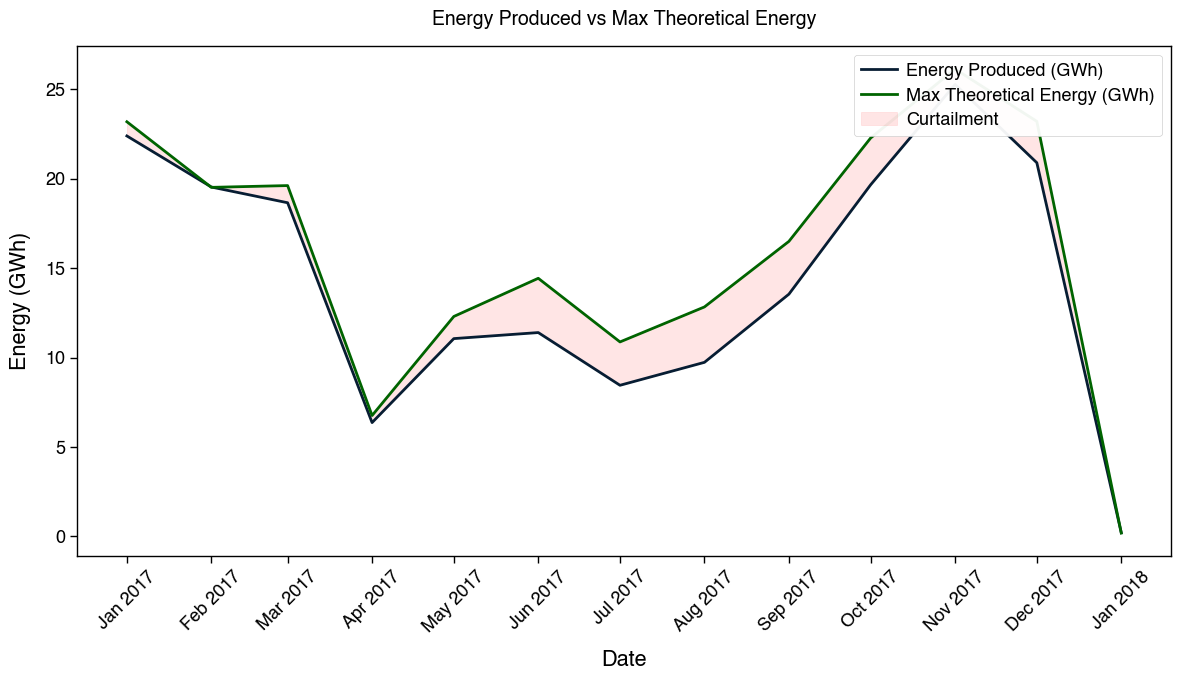

In [80]:
# Plot energy produced and max theoretical energy
#resample to daily
monthly_scaled_turbine = df_scaled_turbine.resample('MS').agg({
    'turbine_energy_kwh': 'sum',
    'turbine_energy_max_kwh': 'sum',
    'curtailed_energy_kwh': 'sum'
})
# Convert to GWh
monthly_scaled_turbine = monthly_scaled_turbine / 10**6

plt.figure(figsize=(12, 7))
plt.plot(monthly_scaled_turbine.index, monthly_scaled_turbine['turbine_energy_kwh'], label='Energy Produced (GWh)')
plt.plot(monthly_scaled_turbine.index, monthly_scaled_turbine['turbine_energy_max_kwh'], label='Max Theoretical Energy (GWh)', color='darkgreen')
# shade curtailment area
plt.fill_between(
    monthly_scaled_turbine.index,
    monthly_scaled_turbine['turbine_energy_max_kwh'],
    monthly_scaled_turbine['turbine_energy_kwh'],
    color='red',
    alpha=0.1,
    label='Curtailment'
)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2017
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.title('Energy Produced vs Max Theoretical Energy')
plt.xlabel('Date')
plt.ylabel('Energy (GWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [81]:
(
    df_scaled_turbine
    .groupby('turbine_name')
    .agg(
        average_power_kw=('turbine_power_kw', 'mean'),
        total_power_kw=('turbine_power_kw', 'sum'),
        installed_capacity_kW=('turbine_ic', 'first'),
        curtailed_power_sum_kw=('curtailed_power_kw', 'sum')
    )
    .assign(
        load_factor=lambda x: x['average_power_kw'] / x['installed_capacity_kW'],
        curtailment_pct=lambda x: x['curtailed_power_sum_kw'] / x['total_power_kw']
    )
    .reset_index()
    .sort_values('load_factor', ascending=False)
).head()


turbine_name  average_power_kw  \
7      Burgar Hill Wind Farm - A                      2286.141447   
29     Spurness Wind Farm II                          4572.282894   
1      Barns of Ayre                                  1248.233230   
22  Northfield Wind Energy Project Burray- A,C         388.644046   
2      Birsay Energy                                   411.505460   

    total_power_kw  installed_capacity_kW  curtailed_power_sum_kw  \
7     3.784936e+07                 5000.0            4.174412e+06   
29    7.569872e+07                10000.0            8.348823e+06   
1     2.066575e+07                 2730.0            2.279229e+06   
22    6.434391e+06                  850.0            7.096500e+05   
2     6.812884e+06                  900.0            7.513941e+05   

    load_factor  curtailment_pct  
7      0.457228          0.11029  
29     0.457228          0.11029  
1      0.457228          0.11029  
22     0.457228          0.11029  
2      0.457228          0.11029

### 2.5.2 Scale Turbine with LIFO Logic

In this section, we simulate the **Last In First Out (LIFO)** curtailment policy implemented by the **Active Network Management (ANM)** system in Orkney. Under this system, **newer turbines (commissioned later)** are curtailed **before** older turbines whenever network constraints require reduced generation. This results in **asymmetric curtailment** across the fleet, with **older turbines experiencing higher effective load factors** over time due to their preferential dispatch.

**Assumptions:**

To create a simplified and consistent simulation:

* We use a normalized time series based representative data from **Ore Brae Wind Farm**, a turbine with:

  * Installed Capacity (**IC**) = 900 kW
  * Commissioning Date = 21/09/2011
  * Baseline **Load Factor (LF\_baseline)** = **0.457228**, calculated as:

  $$
  \text{LF}_{\text{baseline}} = \frac{\bar{P}_{\text{OreBrae}}}{IC_{\text{OreBrae}}} = \frac{411.5}{900} \approx 0.457228
  $$

* The normalized generation profile is scaled to each turbine’s installed capacity using:

  $$
  P_{i,t} = P_{\text{normalized},t} \times IC_i
  $$

Each turbine is assigned a **`relative_position`** based on its commissioning order relative to Ore Brae:

* `relative_position = 0`: Baseline (Ore Brae)
* `relative_position < 0`: Older turbines → **higher priority**, **less curtailment**
* `relative_position > 0`: Newer turbines → **lower priority**, **more curtailment**

To simulate the impact of LIFO on generation, we adjust the **load factor** of each turbine based on its relative position. Specifically, we apply a **linear multiplier** to the baseline load factor:

$$
\text{LF}_i = \text{LF}_{\text{baseline}} \times \left(1 - r_i \cdot \delta \right)
$$

Where:

* $r_i$ = `relative_position` of turbine *i*
* $\delta$ = load factor change per position step (e.g., **0.02**, or 2% per step)
* LF is clipped between 0.2 and 1.3 of baseline for realism

This adjustment simulates the **cumulative disadvantage** that newer turbines face under LIFO dispatch.

The adjusted generation profile is then rescaled to match the desired average power output implied by the new load factor:

$$
\bar{P}_{i,\text{target}} = \text{LF}_i \times IC_i
$$

$$
P_{i,t}^{\text{scaled}} = \min\left(P^{\text{setpoint}}_{i,t}, \; P_{i,t} \times \left(\frac{\bar{P}_{i,\text{target}}}{\bar{P}_{i,\text{original}}} \right) \right)
$$

In [82]:
df_scaled_turbine_lifo = pd.DataFrame()

baseline_lf = load_factor
lf_change_per_step_up = 0.02
lf_change_per_step_down = 0.005

for turbine in df_large_scale_turbine['Location']:
    turbine_IC = df_large_scale_turbine[df_large_scale_turbine['Location'] == turbine]['IC (kW)'].values[0]
    relative_pos = df_large_scale_turbine[df_large_scale_turbine['Location'] == turbine]['relative_position'].values[0]

    # Scale the normalized power by IC (installed capacity)
    turbine_data = ts_normalized.copy() * turbine_IC

    # Calculate current average power
    current_avg_power = turbine_data['turbine_power_kw'].mean()

    if relative_pos != 0:
        lf_change_per_pos = 0.02

        # Positive means worse, negative means better
        lf_multiplier = 1 - (relative_pos * lf_change_per_step_up) if relative_pos > 0 else 1 - ((relative_pos) * lf_change_per_step_down)
        # Optional: Cap it to avoid unreasonable scaling
        lf_multiplier = max(0.7, min(1.1, lf_multiplier))  # allows 50% to 140% of baseline LF
        # print(f"Relative Position: {relative_pos}, LF Multiplier: {lf_multiplier:.2f}")

        adjusted_lf = baseline_lf * lf_multiplier
        adjusted_avg_power = adjusted_lf * turbine_IC

        # Rescale the power time series
        scaling_factor = adjusted_avg_power / current_avg_power
        turbine_data['turbine_power_kw'] *= scaling_factor
        

        # Clip values so they don't exceed technical limits
        turbine_data['turbine_power_kw'] = turbine_data['turbine_power_kw'].clip(
            upper=turbine_data['turbine_setpoint_kw'], lower=0)


        #recalculate currtailment, energy kwh and curtailed energy
        turbine_data['curtailed_power_kw'] = (turbine_data['turbine_power_max_kw'] - turbine_data['turbine_power_kw']).clip(lower=0)
        turbine_data['turbine_energy_kwh'] = turbine_data['turbine_power_kw'] * 0.5
        turbine_data['curtailed_energy_kwh'] = turbine_data['curtailed_power_kw'] * 0.5
    turbine_data['turbine_ic'] = turbine_IC
    turbine_data['turbine_name'] = turbine
    # append to the dataframe
    df_scaled_turbine_lifo = pd.concat([df_scaled_turbine_lifo, turbine_data], axis=0)


df_scaled_turbine_lifo = pd.concat([df_scaled_turbine_lifo, df_small_scale_turbine], axis=0)
# df_scaled_turbine_lifo = pd.concat([df_scaled_turbine_lifo], axis=0)

#reorder timestamp to chronological order
df_scaled_turbine_lifo = df_scaled_turbine_lifo.sort_index()

df_scaled_turbine_lifo.head()


turbine_power_kw  turbine_setpoint_kw  turbine_power_max_kw  \
Timestamp                                                                 
2017-01-01       2700.000000               2700.0           2589.741900   
2017-01-01         65.165094                 80.0             76.733093   
2017-01-01        723.173602                910.0            872.838937   
2017-01-01         42.615587                 55.0             52.754002   
2017-01-01        347.679617                500.0            479.581833   

            curtailed_power_kw  turbine_energy_kwh  turbine_energy_max_kwh  \
Timestamp                                                                    
2017-01-01            0.000000         1350.000000             1294.871100   
2017-01-01           11.567999           32.582547               38.366551   
2017-01-01          149.665334          361.586801              436.419519   
2017-01-01           10.138414           21.307794               26.377004   
2017-01-01          131.902217          173.839808              239.790944   

            curtailed_energy_kwh  turbine_ic  \
Timestamp                                      
2017-01-01              0.000000      2700.0   
2017-01-01              5.784000        80.0   
2017-01-01             74.832667       910.0   
2017-01-01              5.069207        55.0   
2017-01-01             65.951108       500.0   

                                        turbine_name  
Timestamp                                             
2017-01-01  Thorfinn Wind Farm                        
2017-01-01   Banks (Land Near), Rousay                
2017-01-01  Sandybanks, Eday                          
2017-01-01   Wasbister, South Ronaldsay               
2017-01-01   Ludenhill Farm (Land Near)

In [83]:
# small scaled annual energy production
annual_small_scale_generation_lifo = df_scaled_turbine_lifo[df_scaled_turbine_lifo['turbine_name'] == 'Small Scale Turbines']['turbine_energy_kwh'].sum() / 10**6
annual_large_scale_generation_lifo = df_scaled_turbine_lifo[df_scaled_turbine_lifo['turbine_name'] != 'Small Scale Turbines']['turbine_energy_kwh'].sum() / 10**6

print(f"Annual Small Scale Turbine Generation: {annual_small_scale_generation_lifo:.2f} GWh")
print(f"Annual Large Scale Turbine Generation: {annual_large_scale_generation_lifo:.2f} GWh\n")

# total annual energy produced
total_annual_energy_scaled_lifo = df_scaled_turbine_lifo['turbine_energy_kwh'].sum()/10**6
# curtailment energy annually
total_annual_curtailment_energy_scaled_lifo = df_scaled_turbine_lifo['curtailed_energy_kwh'].sum()/10**6

print(f'Total annual energy produced (GWh): {total_annual_energy_scaled_lifo:.2f} GWh')
print(f'Total annual curtailed energy (GWh): {total_annual_curtailment_energy_scaled_lifo:.2f} GWh')
print(f"Percentage of curtailed energy: {(total_annual_curtailment_energy_scaled_lifo/total_annual_energy_scaled_lifo)*100:.2f}%")

Annual Small Scale Turbine Generation: 17.87 GWh
Annual Large Scale Turbine Generation: 156.99 GWh

Total annual energy produced (GWh): 174.86 GWh
Total annual curtailed energy (GWh): 37.27 GWh
Percentage of curtailed energy: 21.32%


In [84]:
lifo_turbine_metrics = (
    df_scaled_turbine_lifo
    .groupby('turbine_name')
    .agg(
        average_power_kw=('turbine_power_kw', 'mean'),
        total_power_kw=('turbine_power_kw', 'sum'),
        installed_capacity_kW=('turbine_ic', 'first'),
        curtailed_power_sum_kw=('curtailed_power_kw', 'sum')
    )
    .assign(
        load_factor=lambda x: x['average_power_kw'] / x['installed_capacity_kW'],
        curtailment_pct=lambda x: x['curtailed_power_sum_kw'] / x['total_power_kw']
    )
    .reset_index()
    .sort_values('load_factor', ascending=False)
)

lifo_turbine_metrics


turbine_name  average_power_kw  \
31        Thorfinn Wind Farm                             1274.810434   
30        Thorfinn Wind Energy Project (NM1500)           706.323339   
5         Burgar Hill                                     610.473615   
22     Northfield Wind Energy Project Burray- A,C         398.040870   
7         Burgar Hill Wind Farm - A                      2334.726604   
2         Birsay Energy                                   419.023026   
14        Gallow Hill, Westray                            417.765662   
6          Burgar Hill Renewables 1                      1064.327071   
13        Flotta Wind Farm                                922.557291   
15        Hammars Hill                                   2068.923832   
34        Trumland Farm, Rousay                            36.653186   
23        Ore Brae Wind Farm                              411.505460   
18         Kingarly Hill Wind Turbine                     402.980457   
17         Hatston Wind Turbine                           394.853327   
4         Braefoot Wind Farm                              386.648866   
25         Rothiesholm Head Wind Farm                     378.431064   
32        Thorkell Deerness                               374.321821   
8          Cleat, Work Road, St. Ola                       33.382924   
29        Spurness Wind Farm II                          3930.644199   
12        Fea, Holm                                        31.865737   
0          Banks (Land Near), Rousay                       29.982763   
26        Sandybanks, Eday                                332.736167   
35         Wasbister, South Ronaldsay                      19.607697   
10        Dalespot Hill                                    27.789039   
16         Hammer, Skelwick, Westray                      169.111194   
1         Barns of Ayre                                   898.392669   
33        Towerhill, St Ola                                26.651064   
21        New Holland, Holm                               159.970370   
19         Ludenhill Farm (Land Near)                     159.970370   
9         DG Westray                                      159.970370   
3          Blackawall Cottage, Flotta                      26.555081   
11         East Hammer, Westray                            17.596741   
20  Mount Pleasant, Haybrake Road South Ronaldsay          20.796148   
24        Rennibister, Firth                              291.146074   
27        Scapa, St Ola                                    26.555081   
28                            Small Scale Turbines       2158.254694   

    total_power_kw  installed_capacity_kW  curtailed_power_sum_kw  \
31    2.110576e+07                 2700.0            2.644106e+06   
30    1.169389e+07                 1500.0            1.477760e+06   
5     1.010700e+07                 1300.0            1.288978e+06   
22    6.589965e+06                  850.0            8.486443e+05   
7     3.865373e+07                 5000.0            5.029190e+06   
2     6.937345e+06                  900.0            9.124800e+05   
14    6.916528e+06                  900.0            9.203012e+05   
6     1.762100e+07                 2300.0            2.373516e+06   
13    1.527386e+07                 2000.0            2.084211e+06   
15    3.425310e+07                 4500.0            4.738527e+06   
34    6.068301e+05                   80.0            8.520460e+04   
23    6.812884e+06                  900.0            7.513941e+05   
18    6.671744e+06                  900.0            1.051527e+06   
17    6.537192e+06                  900.0            1.151427e+06   
4     6.401359e+06                  900.0            1.264132e+06   
25    6.265305e+06                  900.0            1.385861e+06   
32    6.197272e+06                  910.0            1.529612e+06   
8     5.526877e+05                   83.0            1.514317e+05   
29    6.507575e+07                10000.0            1.968926e

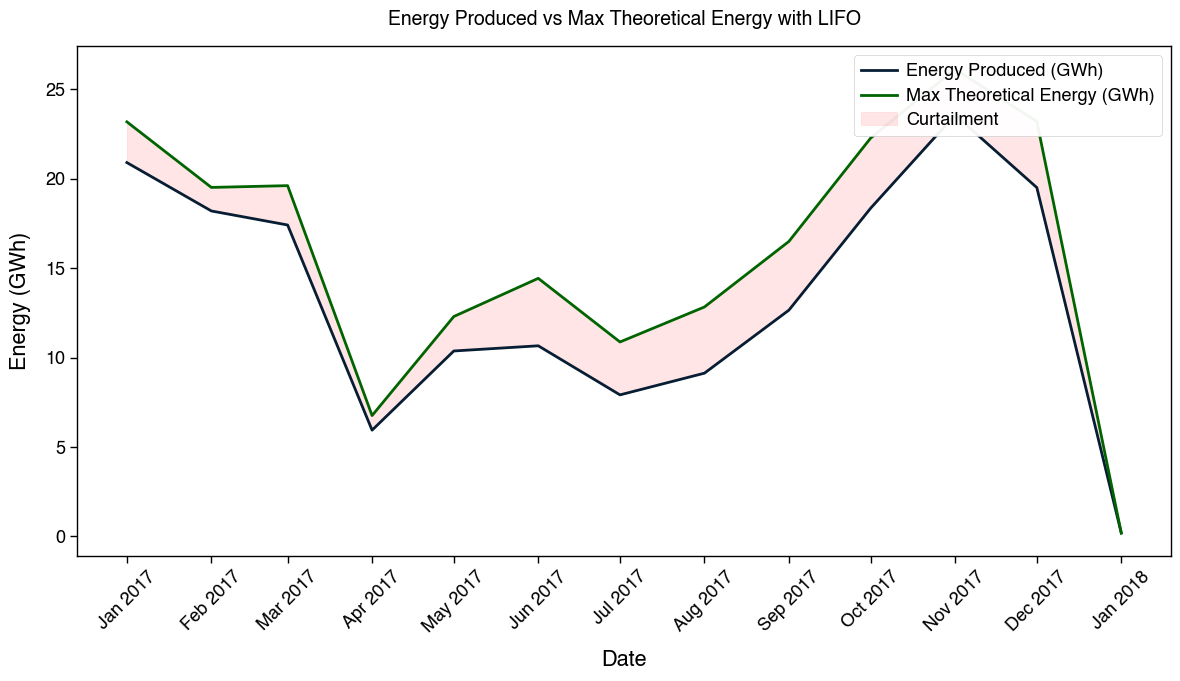

In [85]:
# Plot energy produced and max theoretical energy
#resample to daily
monthly_scaled_turbine_lifo = df_scaled_turbine_lifo.resample('MS').agg({
    'turbine_energy_kwh': 'sum',
    'turbine_energy_max_kwh': 'sum',
    'curtailed_energy_kwh': 'sum'
})
# Convert to GWh
monthly_scaled_turbine_lifo = monthly_scaled_turbine_lifo / 10**6

plt.figure(figsize=(12, 7))
plt.plot(monthly_scaled_turbine_lifo.index, monthly_scaled_turbine_lifo['turbine_energy_kwh'], label='Energy Produced (GWh)')
plt.plot(monthly_scaled_turbine_lifo.index, monthly_scaled_turbine_lifo['turbine_energy_max_kwh'], label='Max Theoretical Energy (GWh)', color='darkgreen')
# shade curtailment area
plt.fill_between(
    monthly_scaled_turbine_lifo.index,
    monthly_scaled_turbine_lifo['turbine_energy_max_kwh'],
    monthly_scaled_turbine_lifo['turbine_energy_kwh'],
    color='red',
    alpha=0.1,
    label='Curtailment'
)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2017
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.title('Energy Produced vs Max Theoretical Energy with LIFO')
plt.xlabel('Date')
plt.ylabel('Energy (GWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 2.7 Merge The Scaled Data

In [86]:
df_scaled_merge = df_scaled_turbine.groupby(df_scaled_turbine.index).sum()

df_scaled_merge.head()


turbine_power_kw  turbine_setpoint_kw  \
Timestamp                                                    
2017-01-01 00:00:00      49132.692709              49460.6   
2017-01-01 00:30:00      49365.344380              49460.6   
2017-01-01 01:00:00      49618.143002              49460.6   
2017-01-01 01:30:00      49891.088576              49460.6   
2017-01-01 02:00:00      49845.293556              49460.6   

                     turbine_power_max_kw  curtailed_power_kw  \
Timestamp                                                       
2017-01-01 00:00:00          47440.810452                 0.0   
2017-01-01 00:30:00          49280.118271                 0.0   
2017-01-01 01:00:00          49333.579684                 0.0   
2017-01-01 01:30:00          49412.474836                 0.0   
2017-01-01 02:00:00          49388.612845                 0.0   

                     turbine_energy_kwh  turbine_energy_max_kwh  \
Timestamp                                                         
2017-01-01 00:00:00        24566.349102            23720.407974   
2017-01-01 00:30:00        24682.669442            24640.061883   
2017-01-01 01:00:00        24809.068753            24666.787094   
2017-01-01 01:30:00        24945.547036            24706.240166   
2017-01-01 02:00:00        24922.646778            24694.303674   

                     curtailed_energy_kwh  turbine_ic  \
Timestamp                                               
2017-01-01 00:00:00                   0.0     44740.3   
2017-01-01 00:30:00                   0.0     44740.3   
2017-01-01 01:00:00                   0.0     44740.3   
2017-01-01 01:30:00                   0.0     44740.3   
2017-01-01 02:00:00                   0.0     44740.3   

                                                          turbine_name  
Timestamp                                                               
2017-01-01 00:00:00  Thorfinn Wind Farm                      Banks ...  
2017-01-01 00:30:00  Blackawall Cottage, Flotta             Fea, Ho...  
2017-01-01 01:00:00  Kingarly Hill Wind Turbine             Small S...  
2017-01-01 01:30:00  Gallow Hill, Westray                    Blacka...  
2017-01-01 02:00:00  Fea, Holm                               Wasbis...

In [87]:
df_scaled_merge_lifo = df_scaled_turbine_lifo.groupby(df_scaled_turbine_lifo.index).sum()

df_scaled_merge_lifo.head()


turbine_power_kw  turbine_setpoint_kw  \
Timestamp                                                    
2017-01-01 00:00:00      45652.680380              49460.6   
2017-01-01 00:30:00      45764.671451              49460.6   
2017-01-01 01:00:00      45886.216076              49460.6   
2017-01-01 01:30:00      46017.447278              49460.6   
2017-01-01 02:00:00      45995.429205              49460.6   

                     turbine_power_max_kw  curtailed_power_kw  \
Timestamp                                                       
2017-01-01 00:00:00          47440.810452         2892.778532   
2017-01-01 00:30:00          49280.118271         3605.518691   
2017-01-01 01:00:00          49333.579684         3536.274555   
2017-01-01 01:30:00          49412.474836         3470.848518   
2017-01-01 02:00:00          49388.612845         3477.140559   

                     turbine_energy_kwh  turbine_energy_max_kwh  \
Timestamp                                                         
2017-01-01 00:00:00        22826.340502            23720.407974   
2017-01-01 00:30:00        22882.335413            24640.061883   
2017-01-01 01:00:00        22943.107726            24666.787094   
2017-01-01 01:30:00        23008.723951            24706.240166   
2017-01-01 02:00:00        22997.714603            24694.303674   

                     curtailed_energy_kwh  turbine_ic  \
Timestamp                                               
2017-01-01 00:00:00           1446.389266     44740.3   
2017-01-01 00:30:00           1802.759345     44740.3   
2017-01-01 01:00:00           1768.137278     44740.3   
2017-01-01 01:30:00           1735.424259     44740.3   
2017-01-01 02:00:00           1738.570280     44740.3   

                                                          turbine_name  
Timestamp                                                               
2017-01-01 00:00:00  Thorfinn Wind Farm                      Banks ...  
2017-01-01 00:30:00  Blackawall Cottage, Flotta             Fea, Ho...  
2017-01-01 01:00:00  Kingarly Hill Wind Turbine             Small S...  
2017-01-01 01:30:00  Gallow Hill, Westray                    Blacka...  
2017-01-01 02:00:00  Fea, Holm                               Wasbis...

# 3. Residential Power Demand (Demand)

In [88]:
# load residential demand data
df_rd = pd.read_csv(RAW_DATASET_PATH / 'Residential_demand.csv')

# rename columns
df_rd = df_rd.rename(columns={
    'Demand_mean_kw': 'res_power_mean_kw',
    'N_households': 'res_sampled_households'
})

df_rd['Timestamp'] = pd.to_datetime(df_rd['Timestamp'])
df_rd['date'] = pd.to_datetime(df_rd['Timestamp']).dt.date
df_rd['hour'] = pd.to_datetime(df_rd['Timestamp']).dt.hour
df_rd['month'] = pd.to_datetime(df_rd['Timestamp']).dt.month
df_rd['year'] = pd.to_datetime(df_rd['Timestamp']).dt.year
df_rd['season'] = pd.to_datetime(df_rd['Timestamp']).dt.month % 12 // 3 + 1

# rename season to Winter, Spring, Summer, Autumn
df_rd['season'] = df_rd['season'].replace({
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Autumn'
})

ts_rd = df_rd.set_index('Timestamp').copy()

display(ts_rd.head())

print(f"Start date: {ts_rd.index.min()}")
print(f"End date: {ts_rd.index.max()}")

res_power_mean_kw  res_sampled_households        date  \
Timestamp                                                                    
2017-01-01 00:00:00           0.220106                    5428  2017-01-01   
2017-01-01 00:30:00           0.205945                    5429  2017-01-01   
2017-01-01 01:00:00           0.189090                    5429  2017-01-01   
2017-01-01 01:30:00           0.173118                    5429  2017-01-01   
2017-01-01 02:00:00           0.159051                    5429  2017-01-01   

                     hour  month  year  season  
Timestamp                                       
2017-01-01 00:00:00     0      1  2017  Winter  
2017-01-01 00:30:00     0      1  2017  Winter  
2017-01-01 01:00:00     1      1  2017  Winter  
2017-01-01 01:30:00     1      1  2017  Winter  
2017-01-01 02:00:00     2      1  2017  Winter

Start date: 2017-01-01 00:00:00
End date: 2018-01-01 23:30:00


The residential demand dataset contains half-hourly electricity demand data from January 1, 2017 to January 1, 2018. Each row represents the average power demand in kilowatts over a 30-minute interval. The column `res_power_mean_kw` records this average demand, while `res_sampled_household`s indicates the number of households sampled during that period. This data provides insight into residential electricity usage patterns over time and can be aligned with other datasets at a 30-minute resolution for comparative analysis.


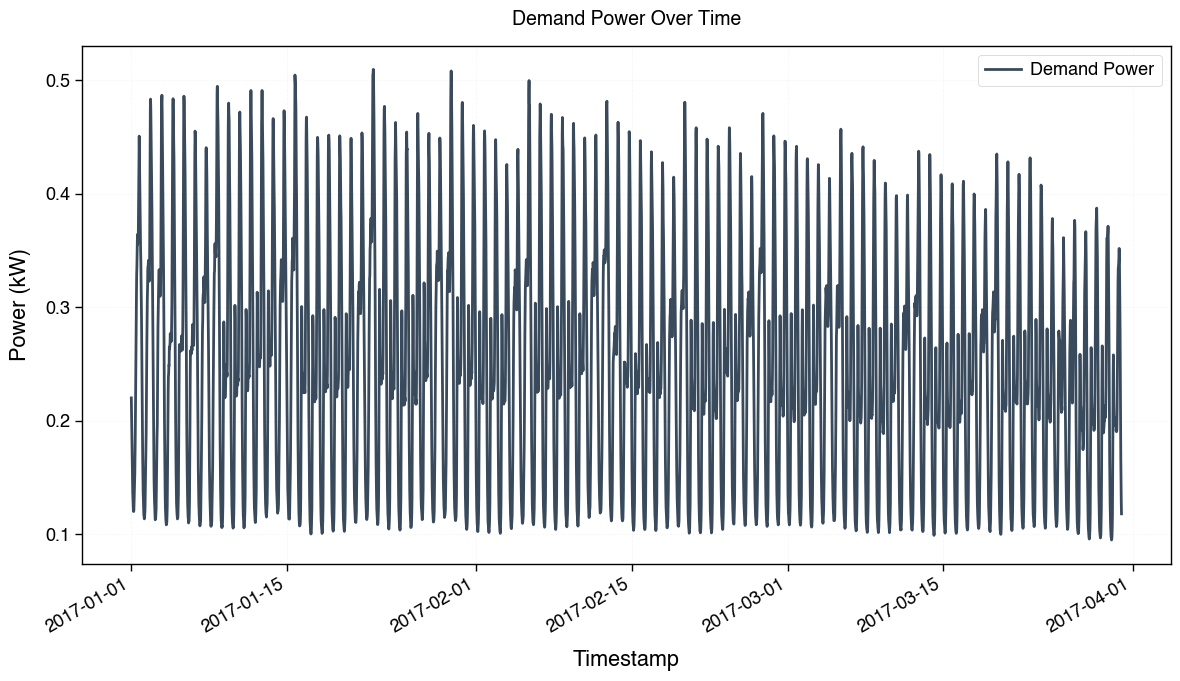

In [89]:
ts_rd_zoom = ts_rd[(ts_rd.index >= '2017-01-01') & (ts_rd.index <= '2017-03-31')]

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(ts_rd_zoom.index, ts_rd_zoom['res_power_mean_kw'], label='Demand Power', alpha=0.8)
ax.set_title('Demand Power Over Time')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Power (kW)')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

We could see some oscillation in the data that align with real life observation where there could be peak and off-peak usage of power. There is also a trend of power usage decreasing from January to April where weather might be warmer in april. We can confirm our hunches through time series decomposition

## 3.1 Time Series Analysis

### 3.1.1 Seasonal Decomposition

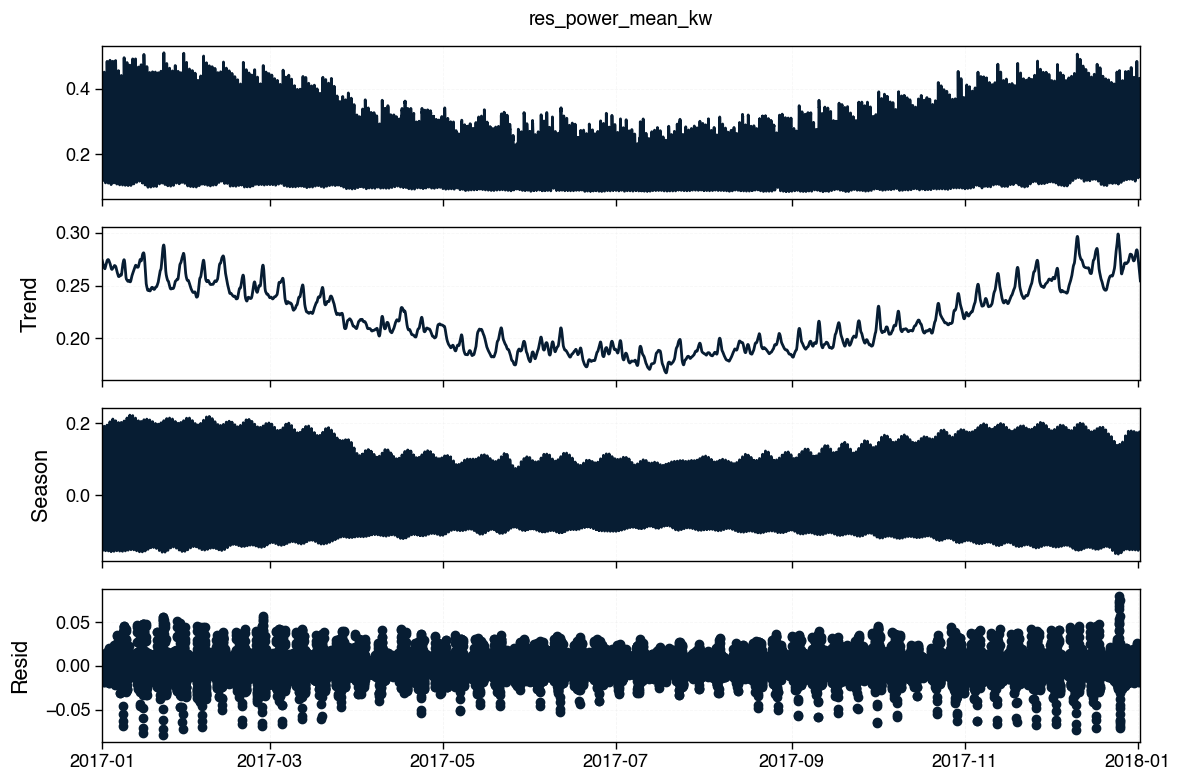

In [90]:
from statsmodels.tsa.seasonal import STL


stl = STL(ts_rd['res_power_mean_kw'], period=48)  # data is in 30-minute intervals, so period=48 for daily seasonality
res = stl.fit()

# Plot with custom size and layout
fig = res.plot()
fig.set_size_inches(12, 8)  # width, height in inches
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()


Since the data is from Orkney, Scotland, the pattern starts to make a lot more sense. Orkney has a cool and often windy climate, with long daylight hours in the summer and short, dark days in the winter. A lot of homes rely on electricity for heating and lighting, especially in rural areas where other energy options might be limited.

The increase demand around September probably marks the start of colder weather. People begin using electric heaters, lights, and maybe cooking indoors more often as the days get shorter.

The daily pattern also becomes more extreme later in the year. That’s likely because people use more electricity in the mornings and evenings when it's darker and colder outside. So the bigger daily swings in the seasonal component match what you’d expect for Orkney’s winter life—lights on earlier, heaters running longer, and more indoor activity overall.

### 3.1.2 Seasonal Decomposition by Season

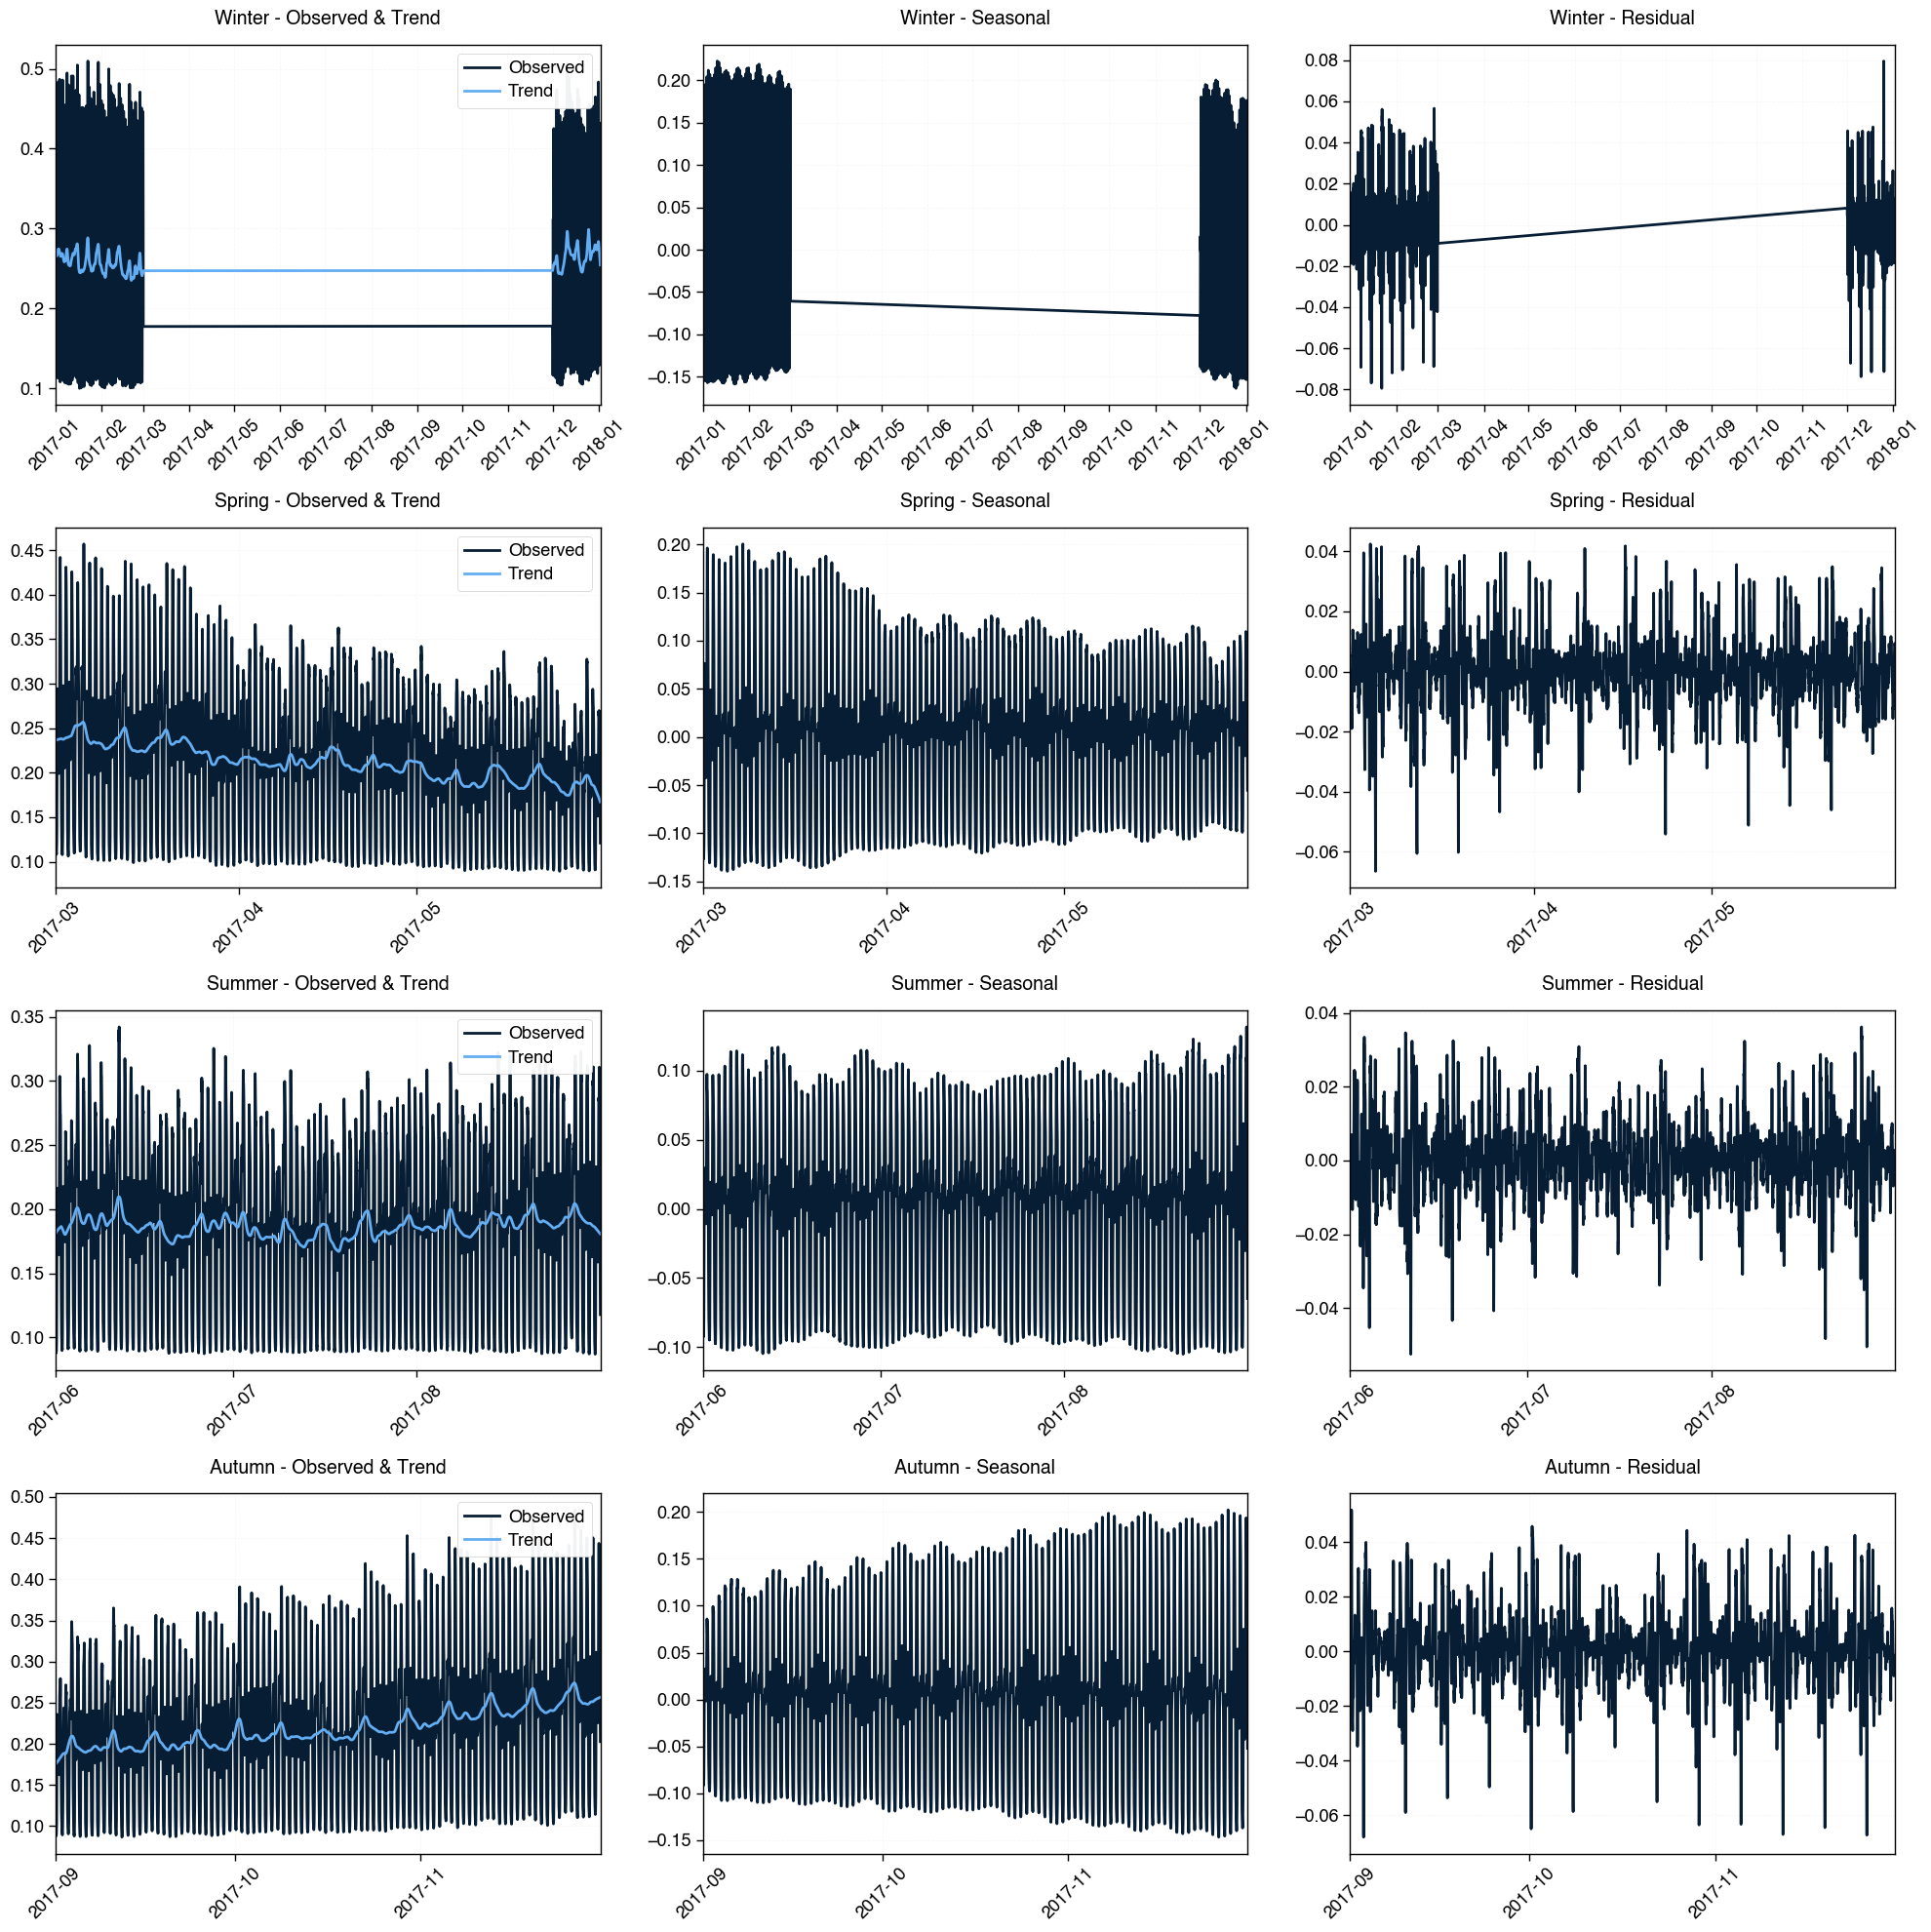

In [91]:
import matplotlib.dates as mdates

seasons = ts_rd['season'].unique()
fig, axs = plt.subplots(len(seasons), 3, figsize=(20, 20), sharex=False)

for i, season in enumerate(seasons):
    seasonal_df = ts_rd[ts_rd['season'] == season]
    stl = STL(seasonal_df['res_power_mean_kw'], period=48)
    res = stl.fit()

    # Get start and end for consistent x-axis
    x_start = seasonal_df.index.min()
    x_end = seasonal_df.index.max()

    # Observed + trend
    axs[i, 0].plot(seasonal_df.index, seasonal_df['res_power_mean_kw'], label='Observed')
    axs[i, 0].plot(seasonal_df.index, res.trend, label='Trend')
    axs[i, 0].set_title(f'{season} - Observed & Trend')
    axs[i, 0].legend()

    # Seasonal
    axs[i, 1].plot(seasonal_df.index, res.seasonal)
    axs[i, 1].set_title(f'{season} - Seasonal')

    # Residual
    axs[i, 2].plot(seasonal_df.index, res.resid)
    axs[i, 2].set_title(f'{season} - Residual')

    # Format x-axis for all three
    for ax in axs[i]:
        ax.set_xlim([x_start, x_end])
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

Looking at the STL plots for each season, we can see clear changes in how people use electricity throughout the year. In winter, demand stays pretty steady at first, then shoots up toward the end of the season. The trend line backs that up, showing a big rise in overall usage most likely because it’s colder and darker, so people are using more heating and lights. The seasonal pattern doesn’t really kick in until later in the winter, which could mean more consistent daily routines or heavier use during mornings and evenings. The residuals in winter are a bit all over the place, especially as demand ramps up, suggesting there might have been some unusual events or just more unpredictable usage.

Spring demand decreases slowly as the season ended, this mark the end of spring where weather is getting warmer day by day. We can see it clearly in the seasonal graph.

Summer looks more stable than any other season. the trend doesnt deviate that much as well as the seasonal aspect. This is also suggested by the residual plot where we can see it is between 0.4 and -0.4 where as other season might jump to -0.6 to -0.8.

Autum is the opposite of spring, demand started low and increases towards the end of the season

### 3.1.3 Average Demand by Season

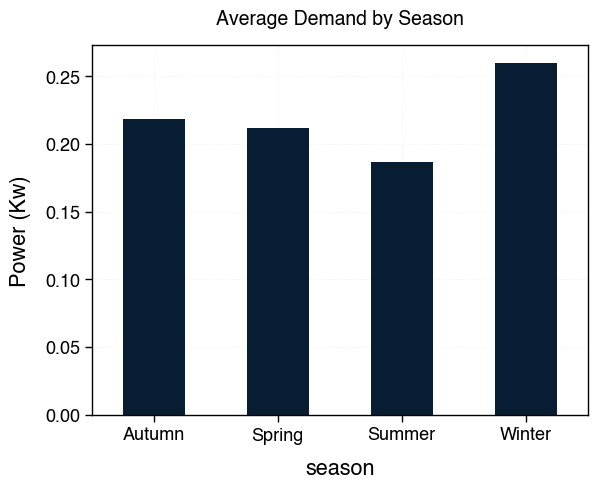

In [92]:
ts_rd.groupby('season')['res_power_mean_kw'].mean().plot(kind='bar', title='Average Demand by Season')
plt.ylabel('Power (Kw)')
#rotate x-axis labels for better readability
plt.xticks(rotation=0)
plt.show()

In [93]:
# factor of demand by season
season_percentage = ts_rd.groupby('season')['res_power_mean_kw'].sum() / ts_rd['res_power_mean_kw'].sum()
season_percentage = season_percentage.reset_index()

season_percentage.rename(columns={'res_power_mean_kw': 'proportion'}, inplace=True)

season_percentage

season  proportion
0  Autumn    0.248143
1  Spring    0.242703
2  Summer    0.214048
3  Winter    0.295105

### 3.1.4 Average Demand by Month

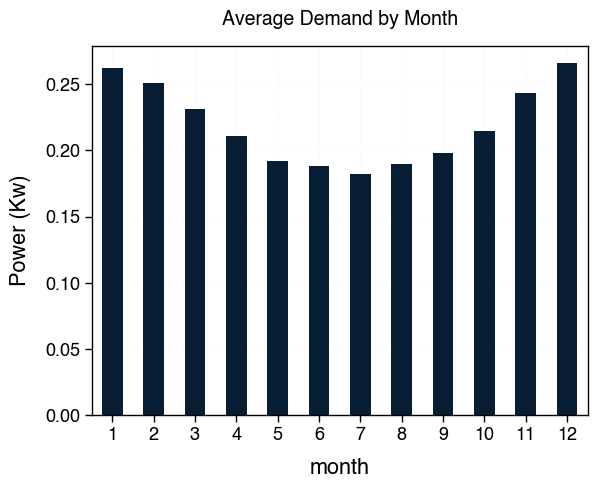

In [94]:
ts_rd.groupby('month')['res_power_mean_kw'].mean().plot(kind='bar', title='Average Demand by Month')
plt.ylabel('Power (Kw)')
#rotate x-axis labels for better readability
plt.xticks(rotation=0)
plt.show()

In [95]:
# factor of demand by season
month_percentage = ts_rd.groupby('month')['res_power_mean_kw'].sum() / ts_rd['res_power_mean_kw'].sum()
month_percentage = month_percentage.reset_index()

month_percentage.rename(columns={'res_power_mean_kw': 'proportion'}, inplace=True)

month_percentage

month  proportion
0       1    0.104735
1       2    0.087611
2       3    0.089456
3       4    0.079034
4       5    0.074213
5       6    0.070306
6       7    0.070456
7       8    0.073286
8       9    0.074066
9      10    0.083075
10     11    0.091002
11     12    0.102759

### 3.1.5 Hourly Usage

Mean: 0.22 kW


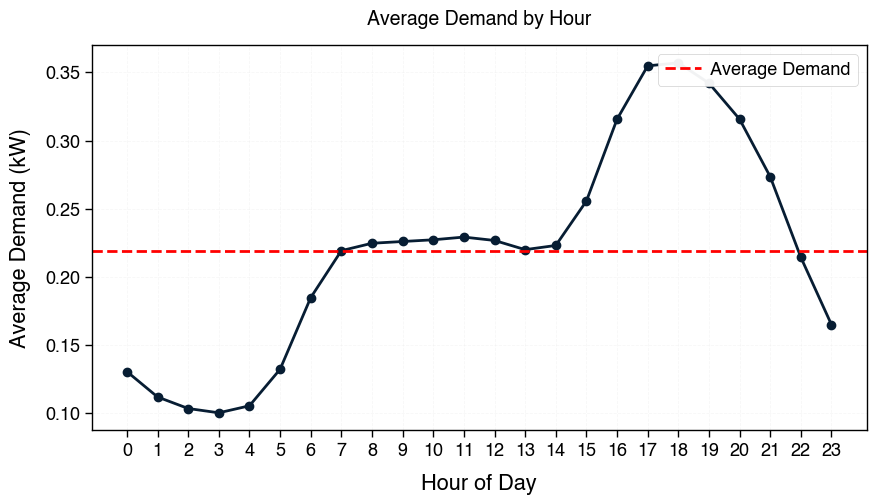

In [96]:
hourly_avg = ts_rd.groupby('hour')['res_power_mean_kw'].mean().reset_index()

print(f'Mean: {hourly_avg["res_power_mean_kw"].mean():.2f} kW')

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg['hour'], hourly_avg['res_power_mean_kw'], marker='o')
# plot mean line
plt.axhline(y=hourly_avg['res_power_mean_kw'].mean(), color='r', linestyle='--', label='Average Demand')
plt.title("Average Demand by Hour")
plt.legend()
plt.xlabel("Hour of Day")
plt.ylabel("Average Demand (kW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## 3.2 Energy Conversion

In [97]:
ts_rd['res_energy_kwh'] = ts_rd['res_power_mean_kw'] * 0.5

ts_rd.tail()

res_power_mean_kw  res_sampled_households        date  \
Timestamp                                                                    
2018-01-01 21:30:00           0.305905                   10730  2018-01-01   
2018-01-01 22:00:00           0.282975                   10731  2018-01-01   
2018-01-01 22:30:00           0.256498                   10731  2018-01-01   
2018-01-01 23:00:00           0.245829                   10731  2018-01-01   
2018-01-01 23:30:00           0.218793                   10731  2018-01-01   

                     hour  month  year  season  res_energy_kwh  
Timestamp                                                       
2018-01-01 21:30:00    21      1  2018  Winter        0.152953  
2018-01-01 22:00:00    22      1  2018  Winter        0.141488  
2018-01-01 22:30:00    22      1  2018  Winter        0.128249  
2018-01-01 23:00:00    23      1  2018  Winter        0.122914  
2018-01-01 23:30:00    23      1  2018  Winter        0.109397

In [98]:
daily_consumption = ts_rd.groupby("date")["res_energy_kwh"].sum().reset_index()
avg_daily_consumption = daily_consumption['res_energy_kwh'].mean()
max_consumption = daily_consumption['res_energy_kwh'].max()
annual_consumption = daily_consumption['res_energy_kwh'].sum()

print(f"Annual consumption: {annual_consumption:.2f} kWh")
print(f"Average daily consumption: {avg_daily_consumption:.2f} kWh")
print(f"Min daily consumption: {daily_consumption['res_energy_kwh'].min():.2f} kWh")
print(f"Max daily consumption: {max_consumption:.2f} kWh")



Annual consumption: 1924.49 kWh
Average daily consumption: 5.26 kWh
Min daily consumption: 4.01 kWh
Max daily consumption: 7.14 kWh


In [99]:
# total residential demand scaled to 10358 households
total_residential_demand = (ts_rd['res_energy_kwh'].sum() * 10358)/10**6

print(f"Annual total residential demand (kWh): {total_residential_demand:.2f} GWh")

Annual total residential demand (kWh): 19.93 GWh


## 3.3 Scaling the Demand

**Table 4.6: Total Estimated Annual Electricity Consumption for Orkney (GWh)**

| Year        | 2005  | 2006  | 2007  | 2008  | 2009  | 2010  | 2011  | 2012  | 2013  | 2014  | 2015  | 2016  | 2017  |
|-------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Domestic    | 84.5  | 84.2  | 85.5  | 84.0  | 81.0  | 83.1  | 83.9  | 83.2  | 79.8  | 82.2  | 81.6  | 80.0  | 81.8  |
| Non-Domestic| 53.6  | 59.7  | 64.1  | 54.3  | 52.6  | 66.0  | 58.1  | 58.8  | 60.3  | 61.9  | 62.4  | 55.3  | 56.3  |
| **Total**   | 138.1 | 143.9 | 149.6 | 138.3 | 133.6 | 149.1 | 142.0 | 142.0 | 140.0 | 144.1 | 144.0 | 135.3 | 138.1 |

Data from BEIS


In [100]:
'''
| Year        | 2005  | 2006  | 2007  | 2008  | 2009  | 2010  | 2011  | 2012  | 2013  | 2014  | 2015  | 2016  | 2017  |
|-------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Domestic    | 84.5  | 84.2  | 85.5  | 84.0  | 81.0  | 83.1  | 83.9  | 83.2  | 79.8  | 82.2  | 81.6  | 80.0  | 81.8  |
| Non-Domestic| 53.6  | 59.7  | 64.1  | 54.3  | 52.6  | 66.0  | 58.1  | 58.8  | 60.3  | 61.9  | 62.4  | 55.3  | 56.3  |
| **Total**   | 138.1 | 143.9 | 149.6 | 138.3 | 133.6 | 149.1 | 142.0 | 142.0 | 140.0 | 144.1 | 144.0 | 135.3 | 138.1 |

'''
domestic_demand = np.array([84.5, 84.2, 85.5, 84.0, 81.0, 83.1, 83.9, 83.2, 79.8, 82.2, 81.6, 80.0])
non_domestic_demand = np.array([53.6, 59.7, 64.1, 54.3, 52.6, 66.0, 58.1, 58.8, 60.3, 61.9, 62.4, 55.3])

domestion_demand_mean = np.mean(domestic_demand)
non_domestic_demand_mean = np.mean(non_domestic_demand)

household_demand = domestion_demand_mean * 10**6 / 10358

print(f"Domestic demand mean: {domestion_demand_mean:.2f} GWh")
print(f"Domestic demand mean per household: {household_demand:.2f} kWh")

scaling_factor = household_demand / annual_consumption

print(f"Scaling factor: {scaling_factor:.2f}")

print(f"\nNon-Domestic demand mean: {non_domestic_demand_mean:.2f} GWh")

Domestic demand mean: 82.75 GWh
Domestic demand mean per household: 7988.99 kWh
Scaling factor: 4.15

Non-Domestic demand mean: 58.92 GWh


In [145]:
2700/365

7.397260273972603

In [101]:
ts_rd.head()

# multiply res_demand_mean_kw and res_energy_kwh by scaling factor
ts_rd_scaled = ts_rd.copy()
ts_rd_scaled['res_power_mean_kw'] = ts_rd_scaled['res_power_mean_kw'] * scaling_factor *10358
ts_rd_scaled['res_energy_kwh'] = ts_rd_scaled['res_energy_kwh'] * scaling_factor *10358

ts_rd_scaled.tail()

res_power_mean_kw  res_sampled_households        date  \
Timestamp                                                                    
2018-01-01 21:30:00       13153.426887                   10730  2018-01-01   
2018-01-01 22:00:00       12167.489308                   10731  2018-01-01   
2018-01-01 22:30:00       11029.011409                   10731  2018-01-01   
2018-01-01 23:00:00       10570.245610                   10731  2018-01-01   
2018-01-01 23:30:00        9407.750153                   10731  2018-01-01   

                     hour  month  year  season  res_energy_kwh  
Timestamp                                                       
2018-01-01 21:30:00    21      1  2018  Winter     6576.713444  
2018-01-01 22:00:00    22      1  2018  Winter     6083.744654  
2018-01-01 22:30:00    22      1  2018  Winter     5514.505704  
2018-01-01 23:00:00    23      1  2018  Winter     5285.122805  
2018-01-01 23:30:00    23      1  2018  Winter     4703.875077

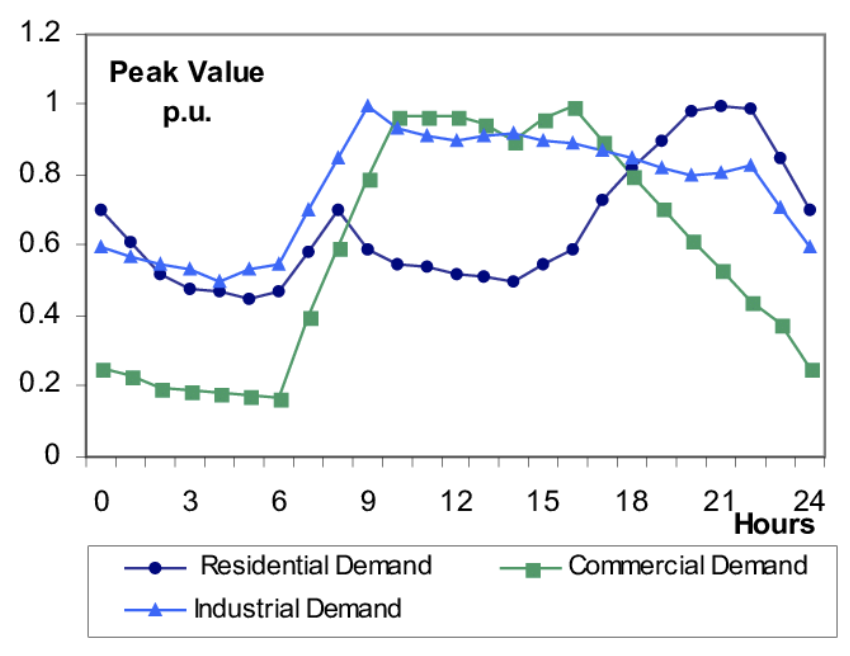
https://www.researchgate.net/publication/3266841_Cost_assignment_model_for_electrical_transmission_system_expansion_An_approach_through_the_Kernel_theory
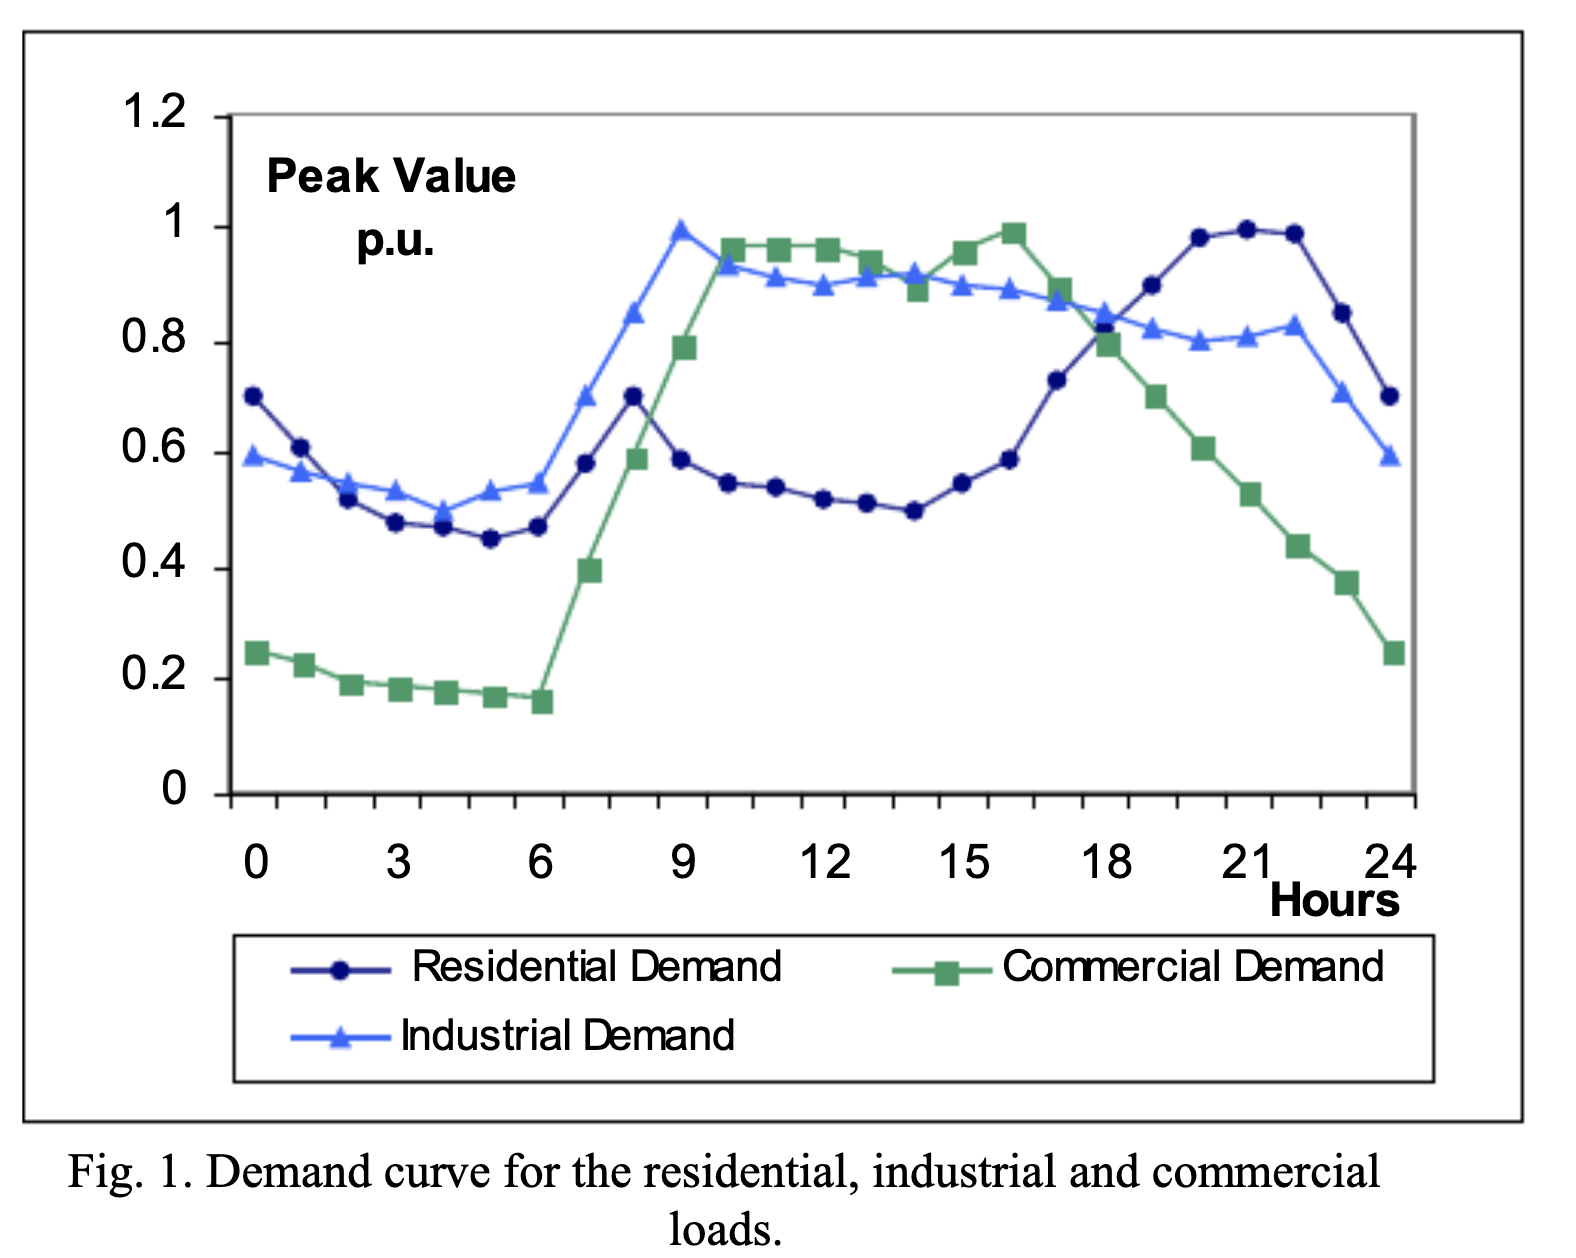

In [102]:
# Set seed for reproducibility
np.random.seed(42)

# Demand levels
off_peak = 0.25
peak = 0.9
peak_margin = 0.1
off_peak_margin = 0.02

# Time segments (0–23)
off_peak_period = list(range(0, 6))  # Midnight to 5 AM
ramp_up_period = list(range(6, 9))   # 6–8 AM
peak_period = list(range(9, 17))     # 9 AM – 4 PM
ramp_down_period = list(range(17, 21))  # 5 PM – 8 PM
late_evening_period = list(range(21, 24))  # 9 PM – 11 PM

# Create base demand profile: hours 0–23
demand_profile = pd.DataFrame({'hour': range(24)})
demand_profile['demand_factor'] = off_peak  # Default value

# Ramp-up: linear rise from off-peak to peak
demand_profile.loc[demand_profile['hour'].isin(ramp_up_period), 'demand_factor'] = np.linspace(
    off_peak, peak, len(ramp_up_period)
)

# Ramp-down: linear drop from peak to low evening usage
demand_profile.loc[demand_profile['hour'].isin(ramp_down_period), 'demand_factor'] = np.linspace(
    peak, off_peak + 0.1, len(ramp_down_period)
)

# Late evening: drop from intermediate usage back to off-peak
demand_profile.loc[demand_profile['hour'].isin(late_evening_period), 'demand_factor'] = np.linspace(
    off_peak + 0.1, off_peak, len(late_evening_period)
)

# Add random oscillation to off-peak hours
off_peak_hours = demand_profile['hour'].isin(off_peak_period)
demand_profile.loc[off_peak_hours, 'demand_factor'] = np.clip(
    np.random.normal(loc=off_peak, scale=0.01, size=off_peak_hours.sum()), 0, 1
)

# Add random oscillation to peak hours
peak_hours = demand_profile['hour'].isin(peak_period)
demand_profile.loc[peak_hours, 'demand_factor'] = np.clip(
    np.random.normal(loc=peak, scale=0.02, size=peak_hours.sum()), 0, 1
)

# # Plot the demand profile
# plt.figure(figsize=(12, 7))
# plt.plot(demand_profile['hour'], demand_profile['demand_factor'], marker='o', label='Commercial Demand')
# plt.title('Simulated Commercial Power Demand Profile with Random Fluctuations')
# plt.xlabel('Hour of Day')
# plt.ylabel('Demand Factor')
# plt.xticks(range(0, 24))
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

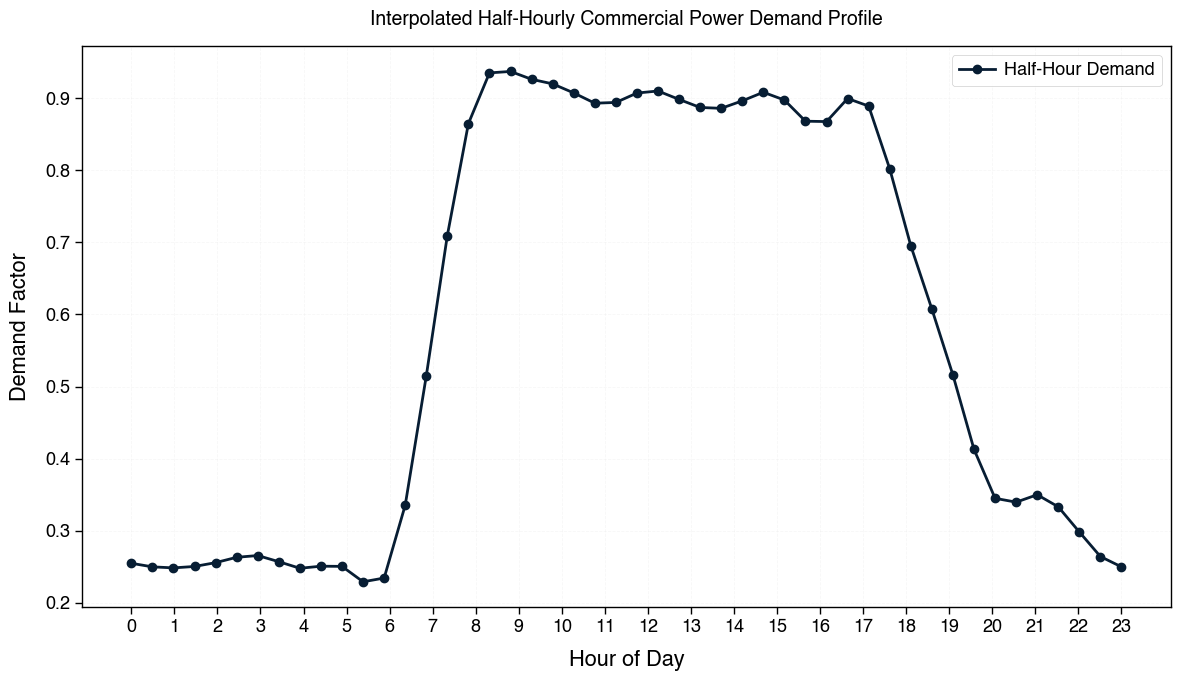

In [103]:
# Interpolate to 48 half-hour intervals
interp_func = interp1d(demand_profile['hour'], demand_profile['demand_factor'], kind='cubic')
half_hour_points = np.linspace(0, 23, 48)
half_hour_demand = interp_func(half_hour_points)

# Build new DataFrame with 30-minute intervals
half_hour_profile = pd.DataFrame({
    'half_hour': half_hour_points,
    'demand_factor': half_hour_demand
})

# Plot
plt.figure(figsize=(12, 7))
plt.plot(half_hour_profile['half_hour'], half_hour_profile['demand_factor'], marker='o', label='Half-Hour Demand')
plt.title('Interpolated Half-Hourly Commercial Power Demand Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Demand Factor')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [104]:

non_domestic_demand_kwh = non_domestic_demand_mean * 10**6

dates = pd.date_range(start='2017-01-01', end='2018-01-01 23:30', freq='30min')
non_res_demand = pd.DataFrame(index=dates)
non_res_demand['month'] = non_res_demand.index.month

# Normalize the daily profile so each day's demand sums to 1
half_hour_profile['demand_factor'] /= half_hour_profile['demand_factor'].sum()

daily_profile = half_hour_profile['demand_factor'].values

# Step 3: Repeat daily profile to match number of days in the year
n_days = non_res_demand.index.normalize().nunique()  # should be 366
full_year_profile = np.tile(daily_profile, n_days)[:len(non_res_demand)]
non_res_demand['base_profile'] = full_year_profile

# Step 4: Join monthly proportions to non_res_demand using 'month'
non_res_demand = non_res_demand.reset_index().rename(columns={'index': 'Timestamp'})
non_res_demand = non_res_demand.merge(month_percentage.rename(columns={'month': 'month', 'proportion': 'month_proportion'}),
              on='month', how='left')

# Step 5: Scale each month's total demand to match its share of the annual energy
annual_energy_kwh = non_domestic_demand_mean * 10**6
monthly_energy_targets = month_percentage.copy()
monthly_energy_targets['monthly_kwh'] = monthly_energy_targets['proportion'] * annual_energy_kwh

# Sum of base profile per month
monthly_base_sum = non_res_demand.groupby('month')['base_profile'].sum().rename('base_month_sum')
month_scaling = monthly_energy_targets.merge(monthly_base_sum, on='month')
month_scaling['scaling_factor'] = month_scaling['monthly_kwh'] / month_scaling['base_month_sum']

# Merge scaling factor back to main non_res_demand
non_res_demand = non_res_demand.merge(month_scaling[['month', 'scaling_factor']], on='month', how='left')

# Step 6: Apply scaling factor
non_res_demand['non_res_energy_kwh'] = non_res_demand['base_profile'] * non_res_demand['scaling_factor']
non_res_demand['non_res_demand_kw'] = non_res_demand['non_res_energy_kwh'] * 2

# Optional: Set timestamp as index again
non_res_demand = non_res_demand.set_index('Timestamp')

non_res_demand.tail()


month  base_profile  month_proportion  scaling_factor  \
Timestamp                                                                    
2018-01-01 21:30:00      1      0.012492          0.104735   192859.372445   
2018-01-01 22:00:00      1      0.011893          0.104735   192859.372445   
2018-01-01 22:30:00      1      0.010648          0.104735   192859.372445   
2018-01-01 23:00:00      1      0.009433          0.104735   192859.372445   
2018-01-01 23:30:00      1      0.008922          0.104735   192859.372445   

                     non_res_energy_kwh  non_res_demand_kw  
Timestamp                                                   
2018-01-01 21:30:00         2409.137152        4818.274304  
2018-01-01 22:00:00         2293.641338        4587.282677  
2018-01-01 22:30:00         2053.609431        4107.218863  
2018-01-01 23:00:00         1819.238256        3638.476512  
2018-01-01 23:30:00         1720.724637        3441.449273

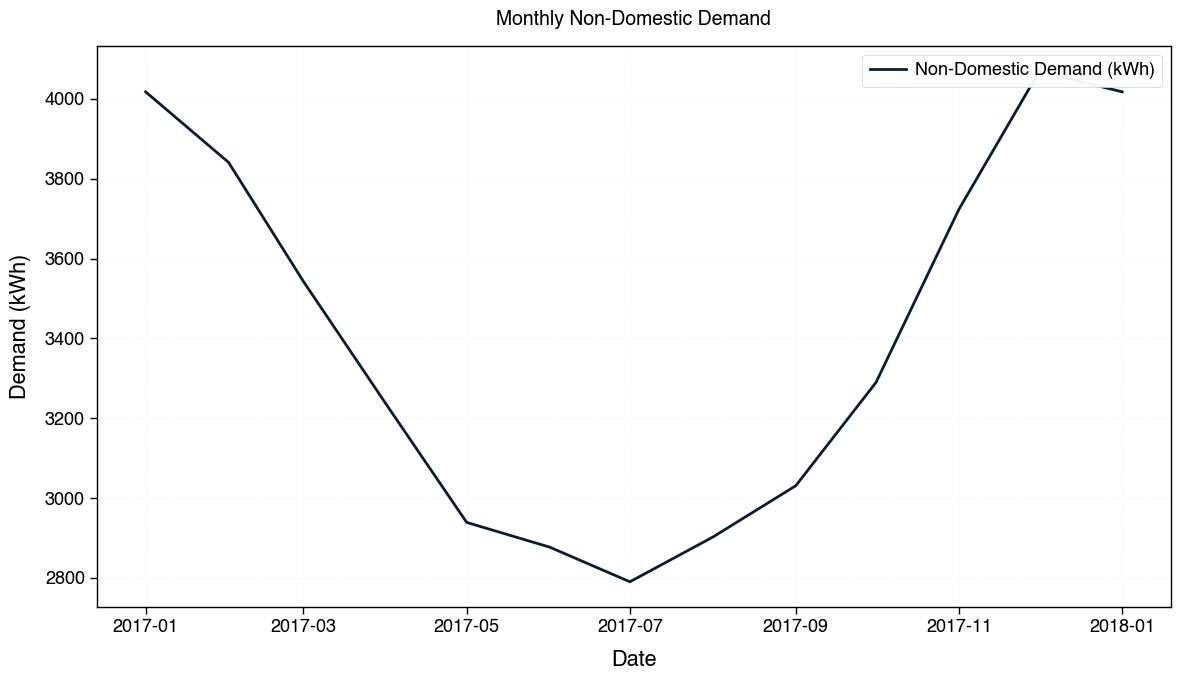

In [105]:
#monthly non_domestic demand
monthly_non_domestic_demand = non_res_demand.resample('MS').mean()
#plot
plt.figure(figsize=(12, 7))
plt.plot(monthly_non_domestic_demand.index, monthly_non_domestic_demand['non_res_energy_kwh'], label='Non-Domestic Demand (kWh)')
plt.title('Monthly Non-Domestic Demand')
plt.xlabel('Date')
plt.ylabel('Demand (kWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 3.4 Final Demannd Data

In [106]:
ts_merge_demand = pd.merge(
    ts_rd_scaled,
    non_res_demand[['non_res_energy_kwh', 'non_res_demand_kw']],
    how='left',
    left_index=True,
    right_index=True,
)
ts_merge_demand['demand_total_power_kw'] = ts_merge_demand['res_power_mean_kw'] + ts_merge_demand['non_res_demand_kw']
ts_merge_demand['demand_total_energy_kwh'] = ts_merge_demand['res_energy_kwh'] + ts_merge_demand['non_res_energy_kwh']
ts_merge_demand.drop(columns=['res_sampled_households'], inplace=True)
# move date, hour, month, year, season to the back
ts_merge_demand = ts_merge_demand[['date','hour', 'month', 'year', 'season','res_power_mean_kw', 'res_energy_kwh', 'non_res_energy_kwh', 'non_res_demand_kw', 'demand_total_power_kw', 'demand_total_energy_kwh']]
ts_merge_demand.head()

date  hour  month  year  season  res_power_mean_kw  \
Timestamp                                                                       
2017-01-01 00:00:00  2017-01-01     0      1  2017  Winter        9464.226632   
2017-01-01 00:30:00  2017-01-01     0      1  2017  Winter        8855.310155   
2017-01-01 01:00:00  2017-01-01     1      1  2017  Winter        8130.562583   
2017-01-01 01:30:00  2017-01-01     1      1  2017  Winter        7443.799967   
2017-01-01 02:00:00  2017-01-01     2      1  2017  Winter        6838.923602   

                     res_energy_kwh  non_res_energy_kwh  non_res_demand_kw  \
Timestamp                                                                    
2017-01-01 00:00:00     4732.113316         1754.912968        3509.825936   
2017-01-01 00:30:00     4427.655078         1720.969228        3441.938456   
2017-01-01 01:00:00     4065.281292         1711.100672        3422.201343   
2017-01-01 01:30:00     3721.899984         1724.680320        3449.360640   
2017-01-01 02:00:00     3419.461801         1761.081193        3522.162386   

                     demand_total_power_kw  demand_total_energy_kwh  
Timestamp                                                            
2017-01-01 00:00:00           12974.052568              6487.026284  
2017-01-01 00:30:00           12297.248611              6148.624306  
2017-01-01 01:00:00           11552.763927              5776.381963  
2017-01-01 01:30:00           10893.160607              5446.580303  
2017-01-01 02:00:00           10361.085988              5180.542994

In [107]:
ts_merge_demand.demand_total_energy_kwh.sum() / 10**6

np.float64(141.67500000000004)

# 4. Demand Generation Model

In [108]:
ts_supply_demand = pd.merge(
    df_scaled_merge_lifo.drop(columns=['turbine_name']).rename(columns={
        'curtailed_power_kw': 'curtailed_from_potential_kw',
        'curtailed_energy_kwh': 'curtailed_from_potential_kwh',
        }),
    ts_merge_demand,
    how='left',
    left_index=True,
    right_index=True,
)

ts_supply_demand['curtailed_due_to_low_demand_kw'] = (ts_supply_demand['turbine_power_max_kw'] - ts_supply_demand['demand_total_power_kw']).clip(lower=0)
ts_supply_demand['curtailed_due_to_low_demand_kwh'] = ts_supply_demand['curtailed_due_to_low_demand_kw'] * 0.5

ordered_columns = [
    'date','hour', 'month', 'season', 'year',
    'turbine_ic', 'turbine_power_max_kw','turbine_energy_max_kwh', 'turbine_setpoint_kw', 
    'turbine_power_kw', 'turbine_energy_kwh',
    'curtailed_from_potential_kw', 'curtailed_from_potential_kwh',
    'res_power_mean_kw', 'res_energy_kwh',
    'demand_total_power_kw', 'demand_total_energy_kwh',
    'curtailed_due_to_low_demand_kw', 'curtailed_due_to_low_demand_kwh'
]

ts_supply_demand = ts_supply_demand[ordered_columns]

ts_supply_demand.head()

date  hour  month  season  year  turbine_ic  \
Timestamp                                                                
2017-01-01 00:00:00  2017-01-01     0      1  Winter  2017     44740.3   
2017-01-01 00:30:00  2017-01-01     0      1  Winter  2017     44740.3   
2017-01-01 01:00:00  2017-01-01     1      1  Winter  2017     44740.3   
2017-01-01 01:30:00  2017-01-01     1      1  Winter  2017     44740.3   
2017-01-01 02:00:00  2017-01-01     2      1  Winter  2017     44740.3   

                     turbine_power_max_kw  turbine_energy_max_kwh  \
Timestamp                                                           
2017-01-01 00:00:00          47440.810452            23720.407974   
2017-01-01 00:30:00          49280.118271            24640.061883   
2017-01-01 01:00:00          49333.579684            24666.787094   
2017-01-01 01:30:00          49412.474836            24706.240166   
2017-01-01 02:00:00          49388.612845            24694.303674   

                     turbine_setpoint_kw  turbine_power_kw  \
Timestamp                                                    
2017-01-01 00:00:00              49460.6      45652.680380   
2017-01-01 00:30:00              49460.6      45764.671451   
2017-01-01 01:00:00              49460.6      45886.216076   
2017-01-01 01:30:00              49460.6      46017.447278   
2017-01-01 02:00:00              49460.6      45995.429205   

                     turbine_energy_kwh  curtailed_from_potential_kw  \
Timestamp                                                              
2017-01-01 00:00:00        22826.340502                  2892.778532   
2017-01-01 00:30:00        22882.335413                  3605.518691   
2017-01-01 01:00:00        22943.107726                  3536.274555   
2017-01-01 01:30:00        23008.723951                  3470.848518   
2017-01-01 02:00:00        22997.714603                  3477.140559   

                     curtailed_from_potential_kwh  res_power_mean_kw  \
Timestamp                                                              
2017-01-01 00:00:00                   1446.389266        9464.226632   
2017-01-01 00:30:00                   1802.759345        8855.310155   
2017-01-01 01:00:00                   1768.137278        8130.562583   
2017-01-01 01:30:00                   1735.424259        7443.799967   
2017-01-01 02:00:00                   1738.570280        6838.923602   

                     res_energy_kwh  demand_total_power_kw  \
Timestamp                                                    
2017-01-01 00:00:00     4732.113316           12974.052568   
2017-01-01 00:30:00     4427.655078           12297.248611   
2017-01-01 01:00:00     4065.281292           11552.763927   
2017-01-01 01:30:00     3721.899984           10893.160607   
2017-01-01 02:00:00     3419.461801           10361.085988   

                     demand_total_energy_kwh  curtailed_due_to_low_demand_kw  \
Timestamp                                                                      
2017-01-01 00:00:00              6487.026284                    34466.757884   
2017-01-01 00:30:00              6148.624306                    36982.869659   
2017-01-01 01:00:00              5776.381963                    37780.815757   
2017-01-01 01:30:00              5446.580303                    38519.314229   
2017-01-01 02:00:00              5180.542994                    39027.526857   

                     curtailed_due_to_low_demand_kwh  
Timestamp                                             
2017-01-01 00:00:00                     17233.378942  
2017-01-01 00:30:00                     18491.434830  
2017-01-01 01:00:00                     18890.407878  
2017-01-01 01:30:00                     19259.657115  
2017-01-01 02:00:00                     19513.763428

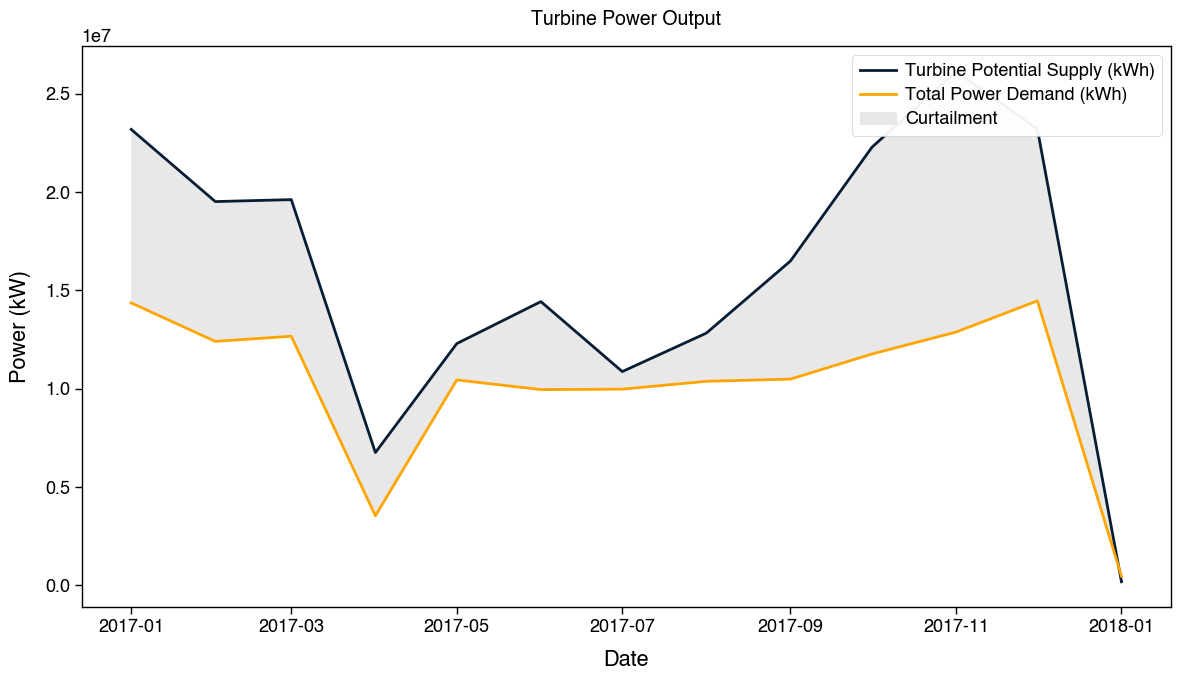

In [109]:
monthly_supply_demand = ts_supply_demand.groupby(['year','month']).agg({
    'turbine_energy_kwh': 'sum',
    'turbine_energy_max_kwh': 'sum',
    'curtailed_from_potential_kwh': 'sum',
    'demand_total_energy_kwh': 'sum',
    'curtailed_due_to_low_demand_kwh': 'sum'
}).reset_index()

# Create a datetime column from year and month (assume day=1)
monthly_supply_demand['date'] = pd.to_datetime(dict(
    year=monthly_supply_demand['year'],
    month=monthly_supply_demand['month'],
    day=1
))

# Set as index and sort
monthly_supply_demand = monthly_supply_demand.set_index('date').sort_index()


# plot df_scaled_turbine power output resampled to monthly
plt.figure(figsize=(12, 7))
plt.plot(monthly_supply_demand.index, monthly_supply_demand['turbine_energy_max_kwh'], label='Turbine Potential Supply (kWh)', alpha=1)
plt.plot(monthly_supply_demand.index, monthly_supply_demand['demand_total_energy_kwh'], label='Total Power Demand (kWh)', color='orange',alpha=1)

#shade curtailment area
plt.fill_between(
    monthly_supply_demand.index,
    monthly_supply_demand['turbine_energy_max_kwh'],
    monthly_supply_demand['demand_total_energy_kwh'],
    color='lightgrey',
    alpha=0.5,
    label='Curtailment'
)
plt.title('Turbine Power Output')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
ts_supply_demand['']

In [110]:
energy_produced = (1+((ts_supply_demand['turbine_energy_kwh'].sum() / 10**6)-(ts_supply_demand['demand_total_energy_kwh'].sum() / 10**6))/(ts_supply_demand['demand_total_energy_kwh'].sum() / 10**6))
print(f"Orkney produced {energy_produced:.2%}% of its energy demand")

Orkney produced 130.62%% of its energy demand


In [132]:
ts_combined.groupby('date')['turbine_energy_kwh'].sum().mean()

np.float64(9845.208665895954)

In [133]:
ts_rd.groupby('date')['res_energy_kwh'].sum().mean()

np.float64(5.258170009323258)

In [134]:
ts_combined.groupby('date')['turbine_energy_max_kwh'].sum().mean()

np.float64(10931.13154566474)

## 4.1 Quantum Heater

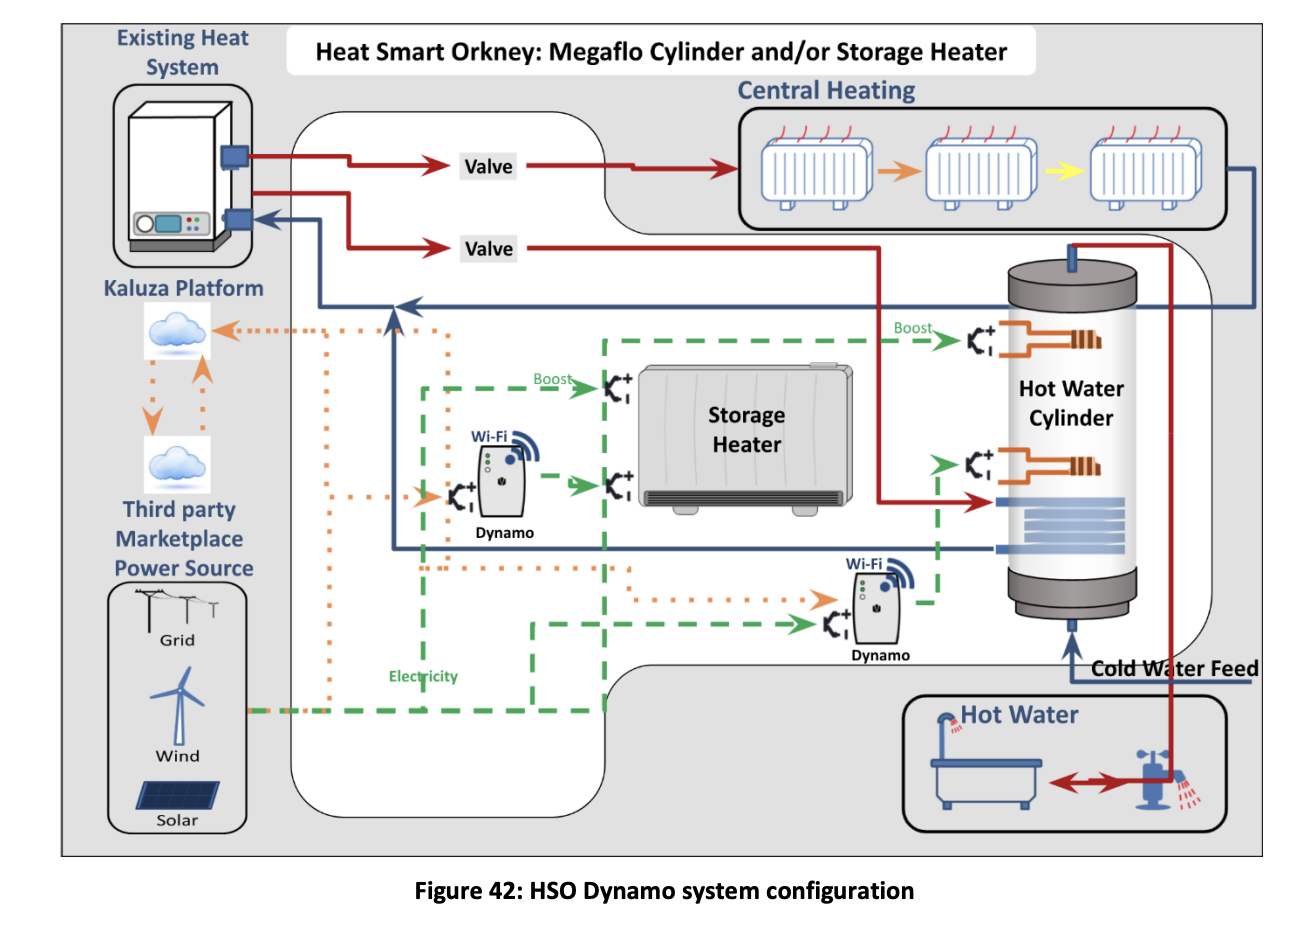

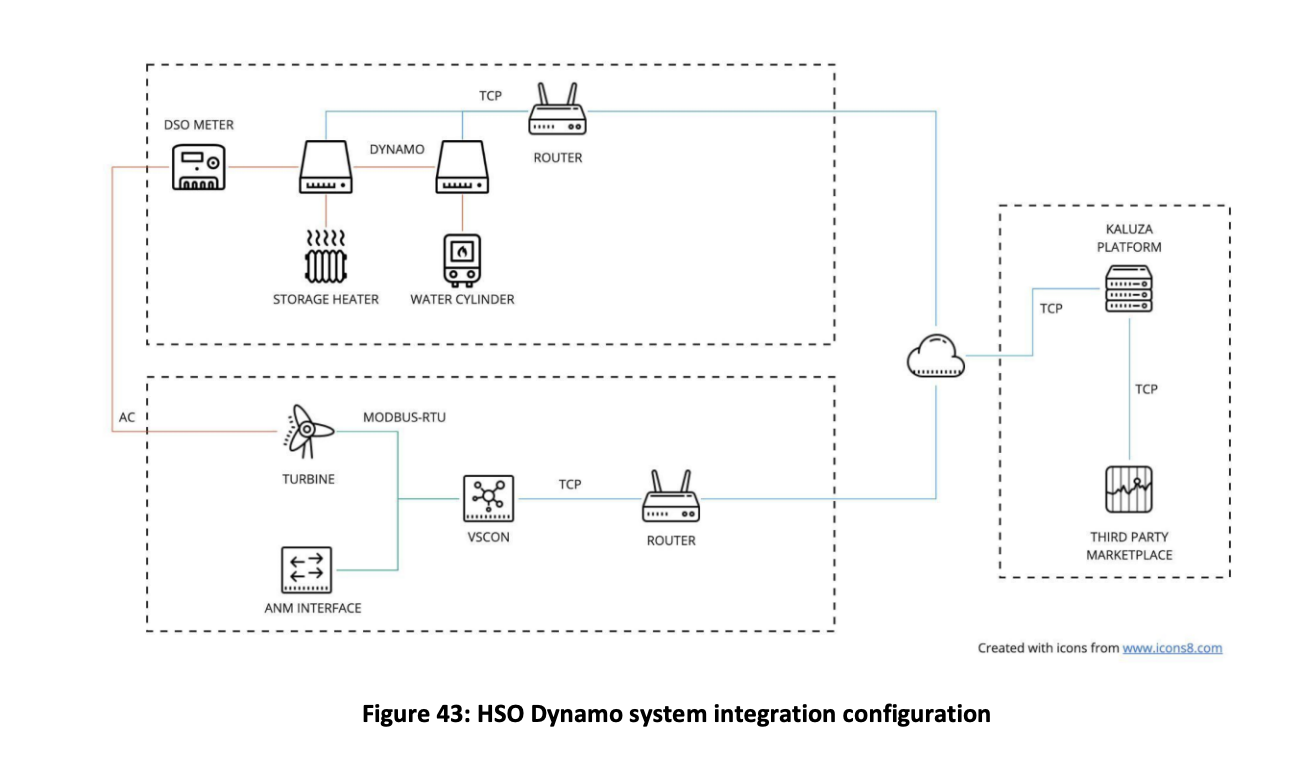

In [111]:
lifo_turbine_metrics

turbine_name  average_power_kw  \
31        Thorfinn Wind Farm                             1274.810434   
30        Thorfinn Wind Energy Project (NM1500)           706.323339   
5         Burgar Hill                                     610.473615   
22     Northfield Wind Energy Project Burray- A,C         398.040870   
7         Burgar Hill Wind Farm - A                      2334.726604   
2         Birsay Energy                                   419.023026   
14        Gallow Hill, Westray                            417.765662   
6          Burgar Hill Renewables 1                      1064.327071   
13        Flotta Wind Farm                                922.557291   
15        Hammars Hill                                   2068.923832   
34        Trumland Farm, Rousay                            36.653186   
23        Ore Brae Wind Farm                              411.505460   
18         Kingarly Hill Wind Turbine                     402.980457   
17         Hatston Wind Turbine                           394.853327   
4         Braefoot Wind Farm                              386.648866   
25         Rothiesholm Head Wind Farm                     378.431064   
32        Thorkell Deerness                               374.321821   
8          Cleat, Work Road, St. Ola                       33.382924   
29        Spurness Wind Farm II                          3930.644199   
12        Fea, Holm                                        31.865737   
0          Banks (Land Near), Rousay                       29.982763   
26        Sandybanks, Eday                                332.736167   
35         Wasbister, South Ronaldsay                      19.607697   
10        Dalespot Hill                                    27.789039   
16         Hammer, Skelwick, Westray                      169.111194   
1         Barns of Ayre                                   898.392669   
33        Towerhill, St Ola                                26.651064   
21        New Holland, Holm                               159.970370   
19         Ludenhill Farm (Land Near)                     159.970370   
9         DG Westray                                      159.970370   
3          Blackawall Cottage, Flotta                      26.555081   
11         East Hammer, Westray                            17.596741   
20  Mount Pleasant, Haybrake Road South Ronaldsay          20.796148   
24        Rennibister, Firth                              291.146074   
27        Scapa, St Ola                                    26.555081   
28                            Small Scale Turbines       2158.254694   

    total_power_kw  installed_capacity_kW  curtailed_power_sum_kw  \
31    2.110576e+07                 2700.0            2.644106e+06   
30    1.169389e+07                 1500.0            1.477760e+06   
5     1.010700e+07                 1300.0            1.288978e+06   
22    6.589965e+06                  850.0            8.486443e+05   
7     3.865373e+07                 5000.0            5.029190e+06   
2     6.937345e+06                  900.0            9.124800e+05   
14    6.916528e+06                  900.0            9.203012e+05   
6     1.762100e+07                 2300.0            2.373516e+06   
13    1.527386e+07                 2000.0            2.084211e+06   
15    3.425310e+07                 4500.0            4.738527e+06   
34    6.068301e+05                   80.0            8.520460e+04   
23    6.812884e+06                  900.0            7.513941e+05   
18    6.671744e+06                  900.0            1.051527e+06   
17    6.537192e+06                  900.0            1.151427e+06   
4     6.401359e+06                  900.0            1.264132e+06   
25    6.265305e+06                  900.0            1.385861e+06   
32    6.197272e+06                  910.0            1.529612e+06   
8     5.526877e+05                   83.0            1.514317e+05   
29    6.507575e+07                10000.0            1.968926e

In [112]:
EPSILON = 1e-6  # tolerance for floating point comparison

def simulate_qheater_absorption(
    df,
    q_heater,
    season_factors,
    heater_mix,
    qheater_adoption_rate,
    total_households = 10358,
    heating_periods = list(range(5, 10)) + list(range(16, 23)),
    curtailment_flag = True,
    offpeak_charging = False,
    offpeak_charging_periods = list(range(0, 5)) + list(range(22, 24))
):

    n_adopted_households = total_households * qheater_adoption_rate

    qheater_max_storage_capacity = sum(q_heater[size]['max_storage_capacity'] for size in heater_mix) * 0.5
    qheater_max_output = sum(q_heater[size]['output_rating'] for size in heater_mix)
    qheater_half_hour_usage = qheater_max_output * 0.5
    qheater_max_input_rating = sum(q_heater[size]['input_rating'] for size in heater_mix)
    qheater_max_energy_draw_per_interval = qheater_max_input_rating * 0.5

    depletion = {s: qheater_half_hour_usage * f for s, f in season_factors.items()}

    ts_model = pd.DataFrame(index=df.index)
    ts_model['season'] = df['season']
    ts_model['hour'] = df['hour']
    ts_model['date'] = df['date']
    ts_model['curtailment_energy_kwh'] = df['curtailed_due_to_low_demand_kwh']

    ts_model['is_heating_active'] = ts_model['hour'].isin(heating_periods)
    ts_model['season_factor'] = ts_model['season'].map(season_factors)
    ts_model['seasonal_max_storage_kwh'] = qheater_max_storage_capacity * ts_model['season_factor'] * n_adopted_households
    ts_model['storage_threshold_kwh'] = 0.5 * ts_model['seasonal_max_storage_kwh']
    ts_model['max_draw_kwh'] = qheater_max_energy_draw_per_interval * n_adopted_households
    ts_model['expected_depletion_kwh'] = np.where(
    ts_model['is_heating_active'],
    ts_model['season'].map(depletion) * n_adopted_households,
    0
)

    n = len(ts_model)
    charging_energy = np.zeros(n)
    depleted_energy = np.zeros(n)
    storage_energy = np.zeros(n)
    absorption_ratio = np.zeros(n)
    curtailment_unabsorbed = np.zeros(n)


    # previous_storage_kwh = 0.0 # set initial storage as 0.2 of max storage
    previous_storage_kwh = qheater_max_storage_capacity * 0.2 * n_adopted_households
    charging_enabled = True

    for i in tqdm.tqdm(range(n)):
        is_active = ts_model['is_heating_active'].iat[i]
        curtailment = ts_model['curtailment_energy_kwh'].iat[i]
        seasonal_max = ts_model['seasonal_max_storage_kwh'].iat[i]
        expected_depletion_kwh = ts_model['expected_depletion_kwh'].iat[i] if is_active else 0.0
        if is_active:
            expected_depletion_kwh = ts_model['expected_depletion_kwh'].iat[i]
        elif charging_enabled:
            expected_depletion_kwh = 0.0
        else:
            expected_depletion_kwh = -0.1 # when not active and not charging, we assume a small loss
        depletion_kwh = min(previous_storage_kwh, expected_depletion_kwh)
        available_storage = max(0, seasonal_max - previous_storage_kwh)
        max_draw = ts_model['max_draw_kwh'].iat[i]
        storage_threshold = ts_model['storage_threshold_kwh'].iat[i]
        res_energy_available = df['demand_total_energy_kwh'].iat[i]
        
        if offpeak_charging:
            if charging_enabled and ts_model['hour'].iat[i] in offpeak_charging_periods:
                charge_kwh = min(max_draw, available_storage, curtailment, res_energy_available) if curtailment_flag else min(max_draw, available_storage)
            else:
                charge_kwh = 0.0
        else:
            if charging_enabled:
                charge_kwh = min(max_draw, available_storage, curtailment, res_energy_available) if curtailment_flag else min(max_draw, available_storage)
            else:
                charge_kwh = 0.0
            

        # Apply hysteresis
        if charging_enabled and previous_storage_kwh + charge_kwh >= seasonal_max - EPSILON:
            charging_enabled = False
        elif not charging_enabled and previous_storage_kwh < storage_threshold + EPSILON:
            charging_enabled = True

        new_storage = previous_storage_kwh + charge_kwh - depletion_kwh
        new_storage = max(0.0, min(new_storage, seasonal_max))

        charging_energy[i] = charge_kwh
        depleted_energy[i] = depletion_kwh
        storage_energy[i] = new_storage
        absorption_ratio[i] = charge_kwh / curtailment if curtailment > 0 else 0.0
        curtailment_unabsorbed[i] = max(curtailment - charge_kwh, 0.0)

        previous_storage_kwh = new_storage

    ts_model['qheater_charging_energy_kwh'] = charging_energy
    ts_model['qheater_depleted_energy_kwh'] = depleted_energy
    ts_model['qheater_storage_energy_kwh'] = storage_energy
    ts_model['qheater_curtailment_absorption_ratio'] = absorption_ratio
    ts_model['curtailment_unabsorbed_energy_kwh'] = curtailment_unabsorbed

    return ts_model

q_heater = {
    500:  {'input_rating': 1.02, 'output_rating': 0.50, 'boost_mode_rating': 0.34, 'max_storage_capacity': 7.14},
    700:  {'input_rating': 1.56, 'output_rating': 0.70, 'boost_mode_rating': 0.52, 'max_storage_capacity': 10.92},
    1000: {'input_rating': 2.22, 'output_rating': 1.00, 'boost_mode_rating': 0.74, 'max_storage_capacity': 15.54},
    1250: {'input_rating': 2.76, 'output_rating': 1.25, 'boost_mode_rating': 0.92, 'max_storage_capacity': 19.32},
    1500: {'input_rating': 3.30, 'output_rating': 1.50, 'boost_mode_rating': 1.10, 'max_storage_capacity': 23.10}
}

season_factors = {
    'Winter': 0.9,
    'Autumn': 0.6,
    'Spring': 0.6,
    'Summer': 0.05
}

heater_mix = [700,700]

qheater_adoption_rate = 0.05

offpeak_charging = list(np.arange(0,8,1))

theoretical_heater_demand = simulate_qheater_absorption(
    ts_supply_demand,
    q_heater,
    season_factors,
    heater_mix,
    qheater_adoption_rate,
    curtailment_flag=False
)

offpeak_heater_demand = simulate_qheater_absorption(
    ts_supply_demand,
    q_heater,
    season_factors,
    heater_mix,
    qheater_adoption_rate,
    curtailment_flag=False,
    offpeak_charging = True,
    offpeak_charging_periods=offpeak_charging
)

curtailment_heater_demand = simulate_qheater_absorption(
    ts_supply_demand,
    q_heater,
    season_factors,
    heater_mix,
    qheater_adoption_rate,
    curtailment_flag=True
)


100%|██████████| 16556/16556 [00:00<00:00, 27352.90it/s]


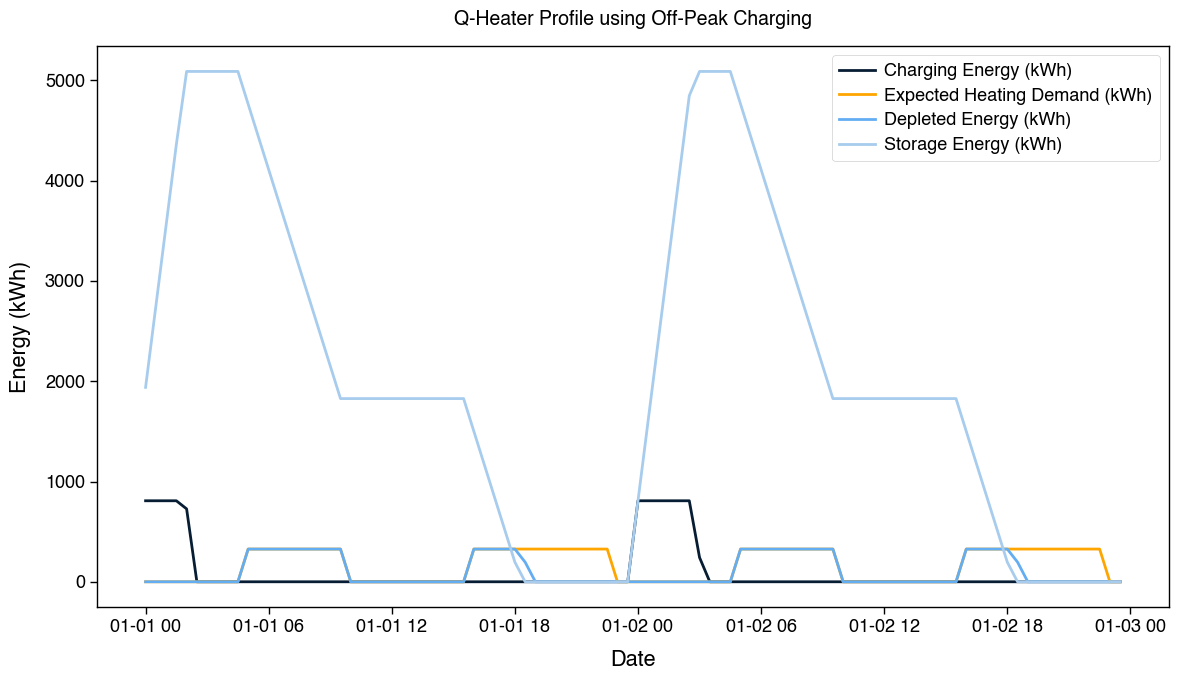

In [113]:
day_2_offpeak = offpeak_heater_demand.head(48*2)

plt.figure(figsize=(12, 7))
plt.plot(day_2_offpeak.index, day_2_offpeak['qheater_charging_energy_kwh'], label='Charging Energy (kWh)')
plt.plot(day_2_offpeak.index, day_2_offpeak['expected_depletion_kwh'], label='Expected Heating Demand (kWh)', color='orange')
plt.plot(day_2_offpeak.index, day_2_offpeak['qheater_depleted_energy_kwh'], label='Depleted Energy (kWh)')
plt.plot(day_2_offpeak.index, day_2_offpeak['qheater_storage_energy_kwh'], label='Storage Energy (kWh)')
plt.title('Q-Heater Profile using Off-Peak Charging')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

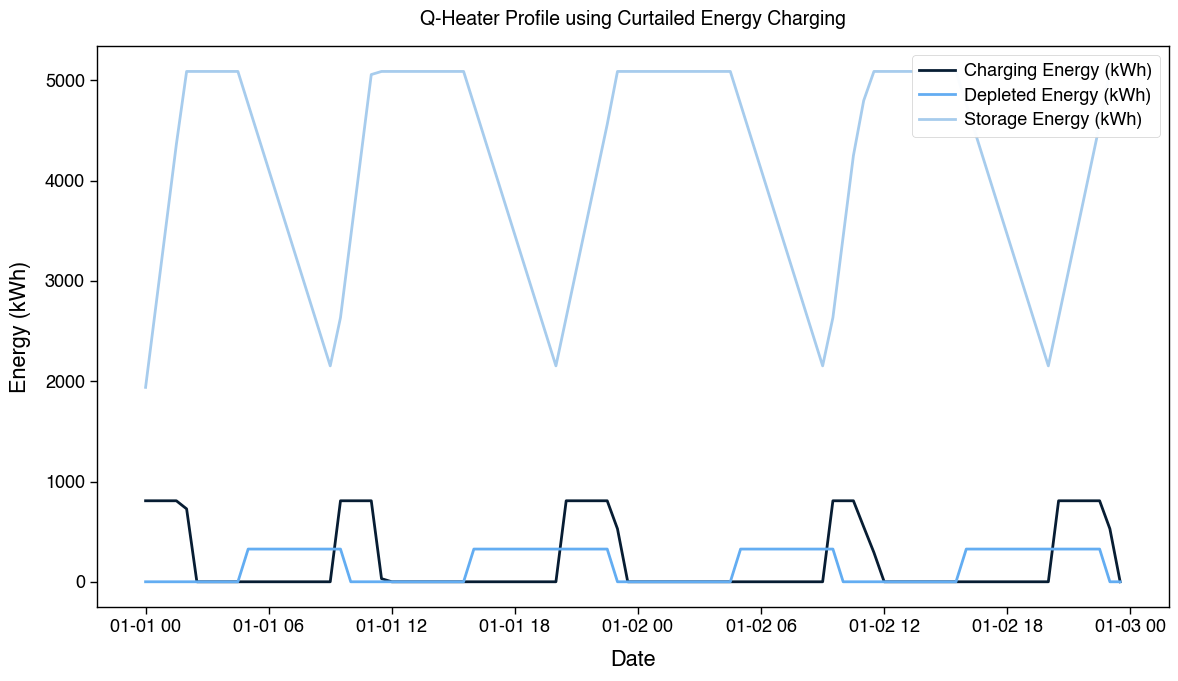

In [114]:
day_2_curtailment = curtailment_heater_demand.head(48*2)

plt.figure(figsize=(12, 7))
plt.plot(day_2_curtailment.index, day_2_curtailment['qheater_charging_energy_kwh'], label='Charging Energy (kWh)')
plt.plot(day_2_curtailment.index, day_2_curtailment['qheater_depleted_energy_kwh'], label='Depleted Energy (kWh)')
plt.plot(day_2_curtailment.index, day_2_curtailment['qheater_storage_energy_kwh'], label='Storage Energy (kWh)')
# plt.plot(day_2_curtailment.index, day_2_curtailment['expected_depletion_kwh'], label='Expected Depletion (kWh)', color='orange', alpha=0.01)
plt.title('Q-Heater Profile using Curtailed Energy Charging')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

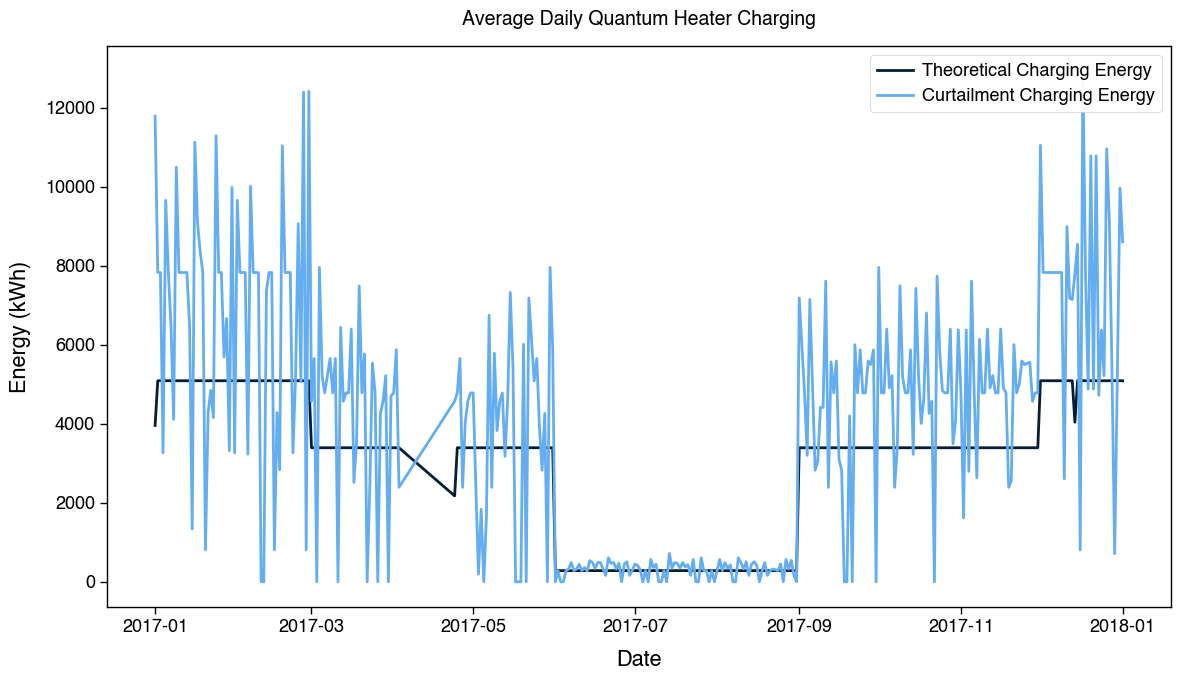

In [115]:
# check how many periods (count) of qheater_chargin_energy_kwh is greater than 0 in a day 
offpeak_daily_charging = (
    offpeak_heater_demand
    .groupby([offpeak_heater_demand.index.date, offpeak_heater_demand.season])
    .agg(
        curtailment_energy_kwh=('curtailment_energy_kwh', 'sum'),
        hours_charging=('qheater_charging_energy_kwh', lambda x: (x > 0).sum() / 2),
        total_charging_energy_kwh=('qheater_charging_energy_kwh', 'sum')
    )
    .reset_index()
    .rename(columns={'level_0': 'date'})
)
curtailment_daily_charging = (
    curtailment_heater_demand
    .groupby([curtailment_heater_demand.index.date, curtailment_heater_demand.season])
    .agg(
        curtailment_energy_kwh=('curtailment_energy_kwh', 'sum'),
        hours_charging=('qheater_charging_energy_kwh', lambda x: (x > 0).sum() / 2),
        total_charging_energy_kwh=('qheater_charging_energy_kwh', 'sum')
    )
    .reset_index()
    .rename(columns={'level_0': 'date'})
)

demand_daily = (
    ts_supply_demand
    .groupby([ts_supply_demand.index.date, ts_supply_demand.season])
    .agg(
        demand_energy_kwh=('demand_total_energy_kwh', 'sum'),
        demand_power_kw=('demand_total_power_kw', 'mean')
    )
    .reset_index()
    .rename(columns={'level_0': 'date'})
)

plt.figure(figsize=(12, 7))
plt.plot(
    offpeak_daily_charging['date'],
    offpeak_daily_charging['total_charging_energy_kwh'],
    label='Theoretical Charging Energy'
)
plt.plot(
    curtailment_daily_charging['date'],
    curtailment_daily_charging['total_charging_energy_kwh'],
    label='Curtailment Charging Energy'
)
plt.title('Average Daily Quantum Heater Charging')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [139]:
demand_daily

date  season  demand_energy_kwh  demand_power_kw
0    2017-01-01  Winter      469770.960792     19573.790033
1    2017-01-02  Winter      475786.607695     19824.441987
2    2017-01-03  Winter      474667.442410     19777.810100
3    2017-01-04  Winter      466003.358250     19416.806594
4    2017-01-05  Winter      469663.302298     19569.304262
..          ...     ...                ...              ...
341  2017-12-28  Winter      475619.873873     19817.494745
342  2017-12-29  Winter      484361.335203     20181.722300
343  2017-12-30  Winter      478192.666549     19924.694440
344  2017-12-31  Winter      486799.321299     20283.305054
345  2018-01-01  Winter      470230.653336     19592.943889

[346 rows x 4 columns]

In [141]:
curtailment_daily_charging.hours_charging.mean()

np.float64(2.939306358381503)

In [116]:
print("Average Quantum Heater Charging Hours by Season using Off-Peak Charging")
display(offpeak_daily_charging.groupby('season')['hours_charging'].mean())

print(f"\nAverage Quantum Heater Charging Hours by Season using Curtailment Charging")
display(curtailment_daily_charging.groupby('season')['hours_charging'].mean())


Average Quantum Heater Charging Hours by Season using Off-Peak Charging


season
Autumn    2.500000
Spring    2.486111
Summer    0.500000
Winter    3.478022
Name: hours_charging, dtype: float64


Average Quantum Heater Charging Hours by Season using Curtailment Charging


season
Autumn    3.203297
Spring    2.819444
Summer    0.831522
Winter    4.901099
Name: hours_charging, dtype: float64

In [146]:
(curtailment_heater_demand['expected_depletion_kwh'].sum() / 10358*qheater_adoption_rate)

np.float64(7.715399999999999)

In [117]:
# Check depleted vs expected depletion
expected_depletion = curtailment_heater_demand['expected_depletion_kwh'].sum()
depleted_energy = curtailment_heater_demand['qheater_depleted_energy_kwh'].sum()
print(f"Expected heating energy need: {expected_depletion:.2f} kWh")
print(f"Realised heating energy: {depleted_energy:.2f} kWh")
print(f"Proportion of heating achieved only by curtailment energy: {(depleted_energy/expected_depletion)*100:.2f}%")

Expected heating energy need: 1598322.26 kWh
Realised heating energy: 1373454.74 kWh
Proportion of heating achieved only by curtailment energy: 85.93%


In [118]:
# calculate unrealised heating demand
unrealised_heating_demand_offpeak = (offpeak_heater_demand['expected_depletion_kwh'].sum() - offpeak_heater_demand['qheater_charging_energy_kwh'].sum())
unrealised_heating_demand_curtailment = (curtailment_heater_demand['expected_depletion_kwh'].sum() - curtailment_heater_demand['qheater_charging_energy_kwh'].sum())

print(f"Annual unrealised heating demand using off-peak charging (kWh): {unrealised_heating_demand_offpeak:.2f} kWh")
print(f"Annual unrealised heating demand using curtailment (kWh): {unrealised_heating_demand_curtailment:.2f} kWh\n")

# per household
unrealised_heating_demand_offpeak_per_household = unrealised_heating_demand_offpeak / (qheater_adoption_rate * 10358)
unrealsed_heating_demand_curtailment_per_household = unrealised_heating_demand_curtailment / (qheater_adoption_rate * 10358)
print(f"Annual unrealised heating demand using off-peak charging per household (kWh): {unrealised_heating_demand_offpeak_per_household:.2f} kWh")
print(f"Annual unrealised heating demand using curtailment per household (kWh): {unrealsed_heating_demand_curtailment_per_household:.2f} kWh\n")


fixed_rate_energy_price = 0.15 # pence per kWh
curtailment_energy_price = fixed_rate_energy_price *0.2 # 20% of fixed rate energy price

unrealised_heating_cost = unrealsed_heating_demand_curtailment_per_household * fixed_rate_energy_price
curtailment_energy_cost = (curtailment_heater_demand['qheater_charging_energy_kwh'].sum()/(qheater_adoption_rate*10358) )* curtailment_energy_price

print(f"Annual unrealised heating cost using curtailment paid using normal rate (kWh): {unrealised_heating_cost:,.2f} GBP")
print(f"Annual curtailment energy cost using curtailment (kWh): {curtailment_energy_cost:,.2f} GBP")


Annual unrealised heating demand using off-peak charging (kWh): 559419.01 kWh
Annual unrealised heating demand using curtailment (kWh): 216475.84 kWh

Annual unrealised heating demand using off-peak charging per household (kWh): 1080.17 kWh
Annual unrealised heating demand using curtailment per household (kWh): 417.99 kWh

Annual unrealised heating cost using curtailment paid using normal rate (kWh): 62.70 GBP
Annual curtailment energy cost using curtailment (kWh): 80.05 GBP


### 4.1.1 Sensitivity Analysis

In [119]:
from joblib import Parallel, delayed
import os

os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

def simulate_and_label(rate):
    df = simulate_qheater_absorption(
        ts_supply_demand,
        q_heater,
        season_factors,
        heater_mix,
        rate
    )
    df = df.copy()
    df['adoption_rate'] = rate
    return df

adoption_rate = list(np.round(np.arange(0.00, 1.01, 0.05),2))

# Parallel execution using joblib
results = Parallel(n_jobs=6)(delayed(simulate_and_label)(rate) for rate in adoption_rate)

# Concatenate results into one DataFrame
sensitivity_results = pd.concat(results)

100%|██████████| 16556/16556 [00:00<00:00, 27661.06it/s]


In [120]:
# calculate the total charging energy for each adoption rate
((sensitivity_results.groupby('adoption_rate')['qheater_charging_energy_kwh'].sum())/10**6).reset_index().rename(columns={'qheater_charging_energy_kwh': 'total_charging_energy_gwh'})

adoption_rate  total_charging_energy_gwh
0            0.00                   0.000000
1            0.05                   1.381846
2            0.10                   2.743006
3            0.15                   4.084108
4            0.20                   5.416012
5            0.25                   6.743852
6            0.30                   8.053806
7            0.35                   9.339934
8            0.40                  10.617465
9            0.45                  11.870901
10           0.50                  13.133511
11           0.55                  14.391309
12           0.60                  15.630076
13           0.65                  16.827560
14           0.70                  18.025772
15           0.75                  19.203718
16           0.80                  20.385462
17           0.85                  21.497325
18           0.90                  22.600520
19           0.95                  23.689858
20           1.00                  24.791136

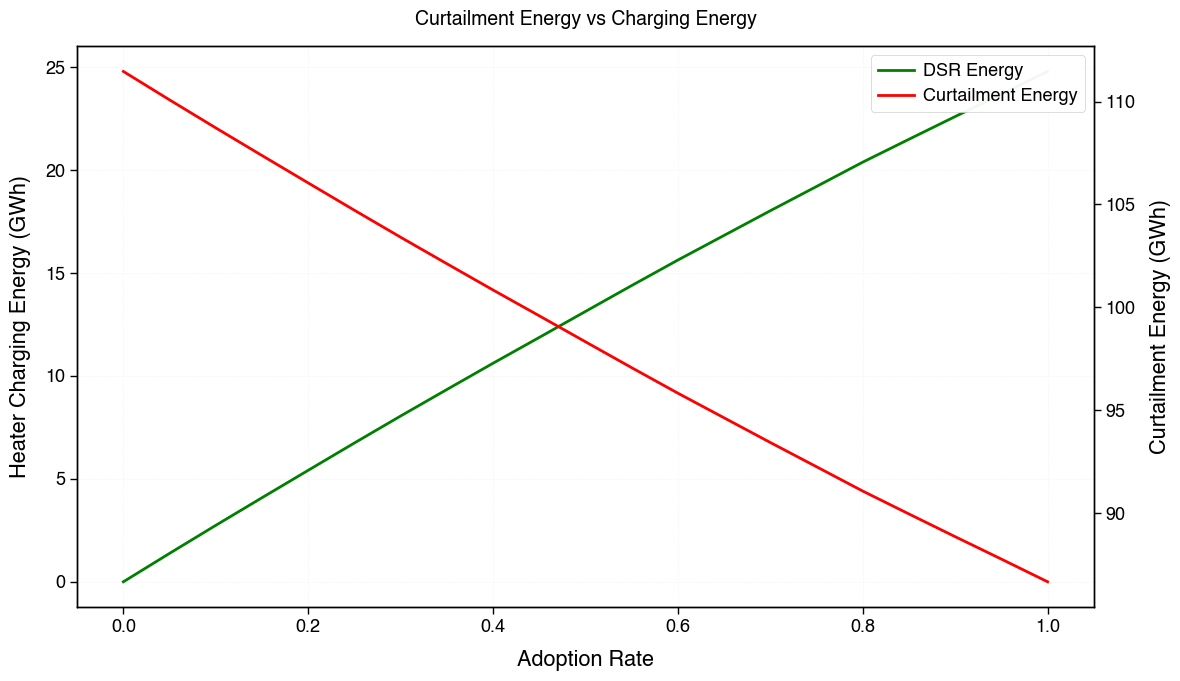

In [121]:
# Precompute the values
adoption_rate = sensitivity_results['adoption_rate'].unique()
adoption_rate.sort()
charging_energy = (
    sensitivity_results.groupby('adoption_rate')['qheater_charging_energy_kwh'].sum()
) / 10**6  # GWh
curtailment_energy = (
    sensitivity_results.groupby('adoption_rate')['curtailment_unabsorbed_energy_kwh'].sum()
) / 10**6  # GWh

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))


ax1.set_xlabel('Adoption Rate')
ax1.set_ylabel('Heater Charging Energy (GWh)')
line1, = ax1.plot(adoption_rate, charging_energy, color='green', label='DSR Energy')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Curtailment Energy (GWh)')
line2, = ax2.plot(adoption_rate, curtailment_energy, color='red', label='Curtailment Energy')
ax2.tick_params(axis='y')

# Combine both legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

# Title and layout
plt.title('Curtailment Energy vs Charging Energy')
fig.tight_layout()
plt.grid()
plt.show()

## 4.2 Electric Vehicle

The UK Government have dataset of number of vehicles registered within each county from 2009 until 2017 for each quarter. We can access this data from [Vehicle Lincensing Data](https://www.gov.uk/government/statistical-data-sets/vehicle-licensing-statistics-data-tables)

| Year     | Private | Company | Total |
|----------|---------|---------|-------|
| 2017 Q4  | 124     | 16      | 140   |
| 2016 Q4  | 84      | 12      | 96    |
| 2015 Q4  | 51      | 12      | 63    |
| 2014 Q4  | 31      | 7       | 38    |
| 2013 Q4  | 5       | 2       | 7     |

We also found questionnaire data sampled from 29 respondents regarding where these people charge their EV and rround 21 of EV owner charge their car at their home

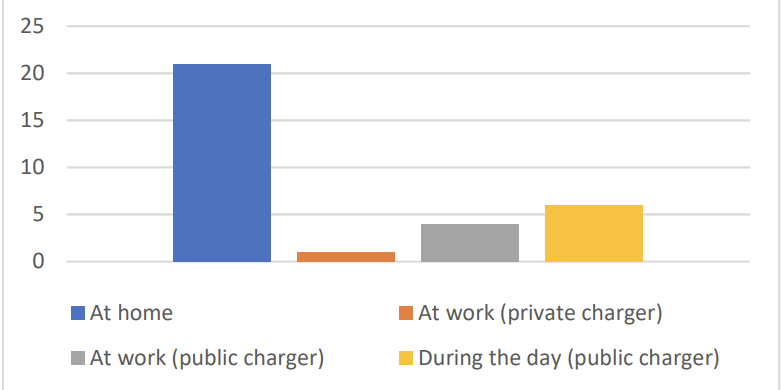


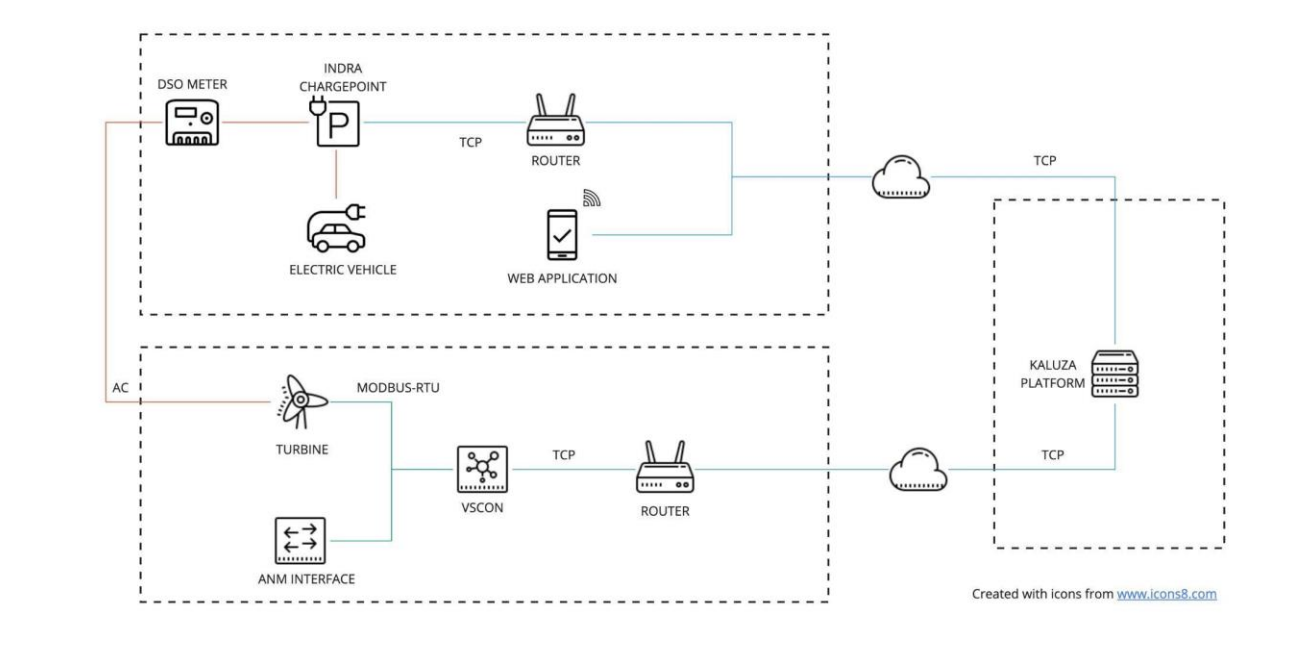

In [122]:
def simulate_ev_absorption(
    df_scaled_merge,
    adoption_rate,
    n_ev = 124,
    battery_capacity = 40,
    home_charger_power = 7.4,
    charge_at_home = round(22/29,2),
    charging_period = list(range(17, 24)) + list(range(0, 8)),
    curtailment_flag = True,
):

    n_adopted_ev = n_ev *charge_at_home * adoption_rate

    charger_half_hour_input = home_charger_power * 0.5


    ts_model = pd.DataFrame(index=df_scaled_merge.index)
    ts_model['season'] = df_scaled_merge['season']
    ts_model['hour'] = df_scaled_merge['hour']
    ts_model['date'] = df_scaled_merge['date']
    ts_model['curtailment_energy_kwh'] = df_scaled_merge['curtailed_due_to_low_demand_kwh']

    ts_model['is_charger_active'] = ts_model['hour'].isin(charging_period)
    ts_model['max_battery_storage'] = battery_capacity* n_adopted_ev
    ts_model['storage_threshold_kwh'] = 0.95 * ts_model['max_battery_storage']
    ts_model['max_draw_kwh'] = charger_half_hour_input * n_adopted_ev * 0.9 #90% efficiency
    
    n = len(ts_model)
    charging_energy = np.zeros(n)
    storage_energy = np.zeros(n)
    absorption_ratio = np.zeros(n)
    curtailment_unabsorbed = np.zeros(n)

    previous_storage_kwh = 0.0
    start_capacity = 0.2 * battery_capacity * n_adopted_ev

    in_charging_session = False  # Track whether we are currently in a session

    for i in tqdm.tqdm(range(n)):
        is_active = ts_model['is_charger_active'].iat[i]
        curtailment = ts_model['curtailment_energy_kwh'].iat[i]
        max_storage = ts_model['max_battery_storage'].iat[i]
        available_storage = max(0, max_storage - previous_storage_kwh)
        max_draw = ts_model['max_draw_kwh'].iat[i]
        storage_threshold = ts_model['storage_threshold_kwh'].iat[i]

        # Detect the start of a new charging session
        if is_active and not in_charging_session:
            previous_storage_kwh = start_capacity
            in_charging_session = True
        elif not is_active:
            in_charging_session = False
            charging_energy[i] = 0.0
            storage_energy[i] = start_capacity
            continue

        # Charging logic
        charge_kwh = min(max_draw, available_storage, curtailment) if curtailment_flag else min(max_draw, available_storage)
        new_storage = previous_storage_kwh + charge_kwh
        new_storage = max(0.0, min(new_storage, max_storage))

        charging_energy[i] = charge_kwh
        storage_energy[i] = new_storage
        absorption_ratio[i] = charge_kwh / curtailment if curtailment > 0 else 0.0
        curtailment_unabsorbed[i] = max(curtailment - charge_kwh, 0.0)

        previous_storage_kwh = new_storage


    ts_model['ev_charging_energy_kwh'] = charging_energy
    ts_model['ev_storage_energy_kwh'] = storage_energy
    ts_model['ev_curtailment_absorption_ratio'] = absorption_ratio
    ts_model['ev_unabsorbed_energy_kwh'] = curtailment_unabsorbed

    return ts_model

theoretical_ev_charging = simulate_ev_absorption(
    ts_supply_demand,
    0.5,
    curtailment_flag=False
)

curtailment_ev_charging = simulate_ev_absorption(
    ts_supply_demand,
    0.5,
    curtailment_flag=True
)

100%|██████████| 16556/16556 [00:00<00:00, 39192.20it/s]


In [123]:
potential_ev_energy = theoretical_ev_charging.ev_charging_energy_kwh.sum()/10**6
curtailment_ev_energy = curtailment_ev_charging.ev_charging_energy_kwh.sum()/10**6

print(f"Annual EV charging energy (kWh): {potential_ev_energy:.2f} GWh")
print(f"Annual EV charging energy using curtailment (kWh): {curtailment_ev_energy:.2f} GWh")
print(f"Proportion of theoretical charging and using curtailment: {(curtailment_ev_energy/potential_ev_energy)*100:2f}%")

Annual EV charging energy (kWh): 0.52 GWh
Annual EV charging energy using curtailment (kWh): 0.42 GWh
Proportion of theoretical charging and using curtailment: 80.450944%


### 4.2.1 Sensitivity Analysis

In [124]:
def ev_simulate_and_label(rate):
    df =  simulate_ev_absorption(ts_supply_demand, rate, curtailment_flag=True)
    df['adoption_rate'] = rate
    return df

adoption_rate = list(np.round(np.arange(0.00, 1.01, 0.05),2))

# Parallel execution using joblib
ev_results = Parallel(n_jobs=6)(delayed(ev_simulate_and_label)(rate) for rate in adoption_rate)

# Concatenate results into one DataFrame
ev_sensitivity_results = pd.concat(ev_results)


100%|██████████| 16556/16556 [00:00<00:00, 38278.47it/s]


In [125]:
((ev_sensitivity_results.groupby('adoption_rate')['ev_charging_energy_kwh'].sum())/10**6).reset_index().rename(columns={'ev_charging_energy_kwh': 'total_charging_energy_gwh'})

adoption_rate  total_charging_energy_gwh
0            0.00                   0.000000
1            0.05                   0.042202
2            0.10                   0.084352
3            0.15                   0.126483
4            0.20                   0.168601
5            0.25                   0.210685
6            0.30                   0.252745
7            0.35                   0.294788
8            0.40                   0.336832
9            0.45                   0.378859
10           0.50                   0.420859
11           0.55                   0.462818
12           0.60                   0.504736
13           0.65                   0.546644
14           0.70                   0.588541
15           0.75                   0.630415
16           0.80                   0.672264
17           0.85                   0.714098
18           0.90                   0.755912
19           0.95                   0.797707
20           1.00                   0.839475

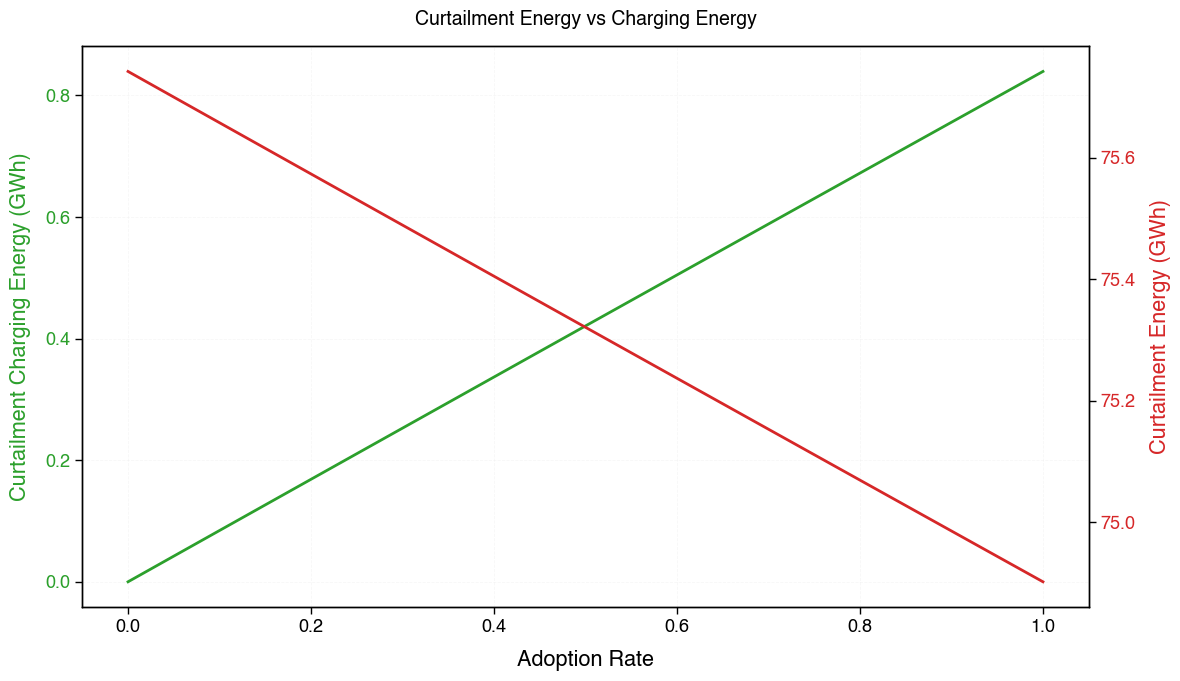

In [126]:
# Precompute the values
adoption_rate = ev_sensitivity_results['adoption_rate'].unique()
adoption_rate.sort()
charging_energy = (
    ev_sensitivity_results.groupby('adoption_rate')['ev_charging_energy_kwh'].sum()
) / 10**6  # GWh
curtailment_energy = (
    ev_sensitivity_results.groupby('adoption_rate')['ev_unabsorbed_energy_kwh'].sum()
) / 10**6  # GWh

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

color1 = 'tab:green'
ax1.set_xlabel('Adoption Rate')
ax1.set_ylabel('Curtailment Charging Energy (GWh)', color=color1)
ax1.plot(adoption_rate, charging_energy, color=color1, label='EV Charging Energy')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Curtailment Energy (GWh)', color=color2)
ax2.plot(adoption_rate, curtailment_energy, color=color2, label='Curtailment Energy')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Curtailment Energy vs Charging Energy')
fig.tight_layout()
plt.grid()
plt.show()

# 5. Energy Use for Heating

## 5.1 Kerosene

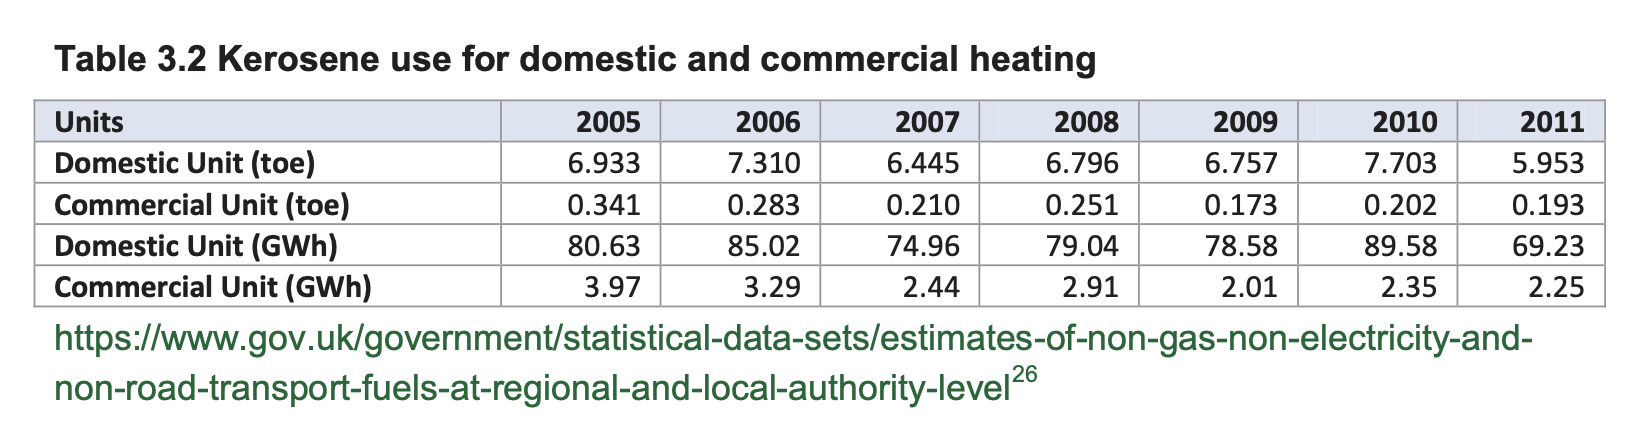

Overall 41% of Orkney’s households rely on electric
heating while 36% of households rely on oil.

In [127]:
kerosene_domestic_usage = np.array([80.63,85.02,74.96, 79.04, 78.58, 89.58, 69.23])
per_household_oil_usage_annually = (kerosene_domestic_usage.mean()/(10358*0.36))*10**6

print(f"Annual per household oil usage on average (kWh): {per_household_oil_usage_annually:.2f} kWh")

oil_price_per_litre = 0.6 # GBP

kerosene_kwh_litre = 10.35 # kWh/litre

per_household_oil_usage_liter = per_household_oil_usage_annually / kerosene_kwh_litre
print(f"Annual per household oil usage on average (litre): {per_household_oil_usage_liter:.2f} litre\n")

annual_oil_cost = per_household_oil_usage_liter * oil_price_per_litre
print(f"Annual per household oil cost on average (GBP): {annual_oil_cost:.2f} GBP")


Annual per household oil usage on average (kWh): 21340.76 kWh
Annual per household oil usage on average (litre): 2061.91 litre

Annual per household oil cost on average (GBP): 1237.15 GBP


## 5.2 Electricity

In [128]:
#2005-2016 household energy consumption
# domestic_demand_mean = 82.75000000000001
